<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Egypt/COMI/COMI_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "COMI"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

Open   High    Low  Close       Volume
2009-01-04   8.06   8.30   8.06   8.12  14236982.76
2009-01-05   8.11   8.32   8.11   8.20  21634207.60
2009-01-06   8.31   8.31   7.79   7.94  34526383.34
2009-01-08   7.76   8.16   7.68   7.92  28332398.16
2009-01-11   7.90   8.21   7.79   7.98  17588159.40
...           ...    ...    ...    ...          ...
2018-12-25  58.58  58.15  57.26  57.66  14868207.60
2018-12-26  57.66  58.41  57.92  58.11  15019459.26
2018-12-27  58.11  59.19  58.41  58.62  44193207.66
2018-12-30  58.62  59.20  58.40  58.73  10250381.82
2018-12-31  58.73  59.99  58.80  59.26  52718881.20

[2410 rows x 5 columns]

Open         High          Low        Close        Volume
count  2410.000000  2410.000000  2410.000000  2410.000000  2.410000e+03
mean     29.382506    29.744739    29.034137    29.396614  5.770845e+07
std      20.101342    20.290421    19.905895    20.104024  6.039583e+07
min       6.490000     6.710000     6.290000     6.590000  6.101658e+05
25%      12.940000    13.100000    12.782500    12.940000  2.322839e+07
50%      21.210000    21.480000    21.065000    21.295000  4.141007e+07
75%      37.100000    37.485000    36.895000    37.205000  7.314775e+07
max      75.990000    77.200000    74.660000    75.990000  9.099566e+08

21

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close       Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
2009-03-17   6.83   6.83   6.67   6.76  15552448.08   17          1         76             31             0               0               0                 0      3        1    12        1             2          12   6.801021   6.950064  -7.615311   6.724468   6.895767   6.924052       6.945       6.970   7.335589   6.91750   6.680127   6.8830   6.824167   6.91750   6.743333   7.194024                7.340200                  6.91750                6.494800                7.551549                  6.91750                6.283451                7.762899                  6.91750                6.072101                7.974249                  6.91750                5.860751   6.895767   6.771437   7.171216                7.318467                 6.895767                6.473068                7.529817                 6.895767                6.261718                7.741167                 6.895767                6.050368                7.952517                 6.895767   
2009-03-18   6.82   6.88   6.68   6.77  20611386.86   18          2         77             31             0               0               0                 0      3        1    12        2             4          12   6.799470   6.946299  -7.594605   6.712849   6.867819   6.894807       6.945       6.940   7.275142   6.86125   6.691062   6.8115   6.791389   6.86125   6.765000   7.155972                7.223388                  6.86125                6.499112                7.404457                  6.86125                6.318043                7.585526                  6.86125                6.136974                7.766594                  6.86125                5.955906   6.867819   6.767722   7.129036                7.229957                 6.867819                6.505681                7.411026                 6.867819                6.324612                7.592095                 6.867819                6.143544                7.773163                 6.867819   
2009-03-19   6.80   6.82   6.66   6.74  20324456.52   19          3         78             31             0               0               0                 0      3        1    12        3             3          12   6.796497   6.942554  -7.574313   6.696790   6.839415   6.864176       6.860       6.880   7.219531   6.80125   6.689447   6.7705   6.764444   6.80125   6.755000   7.117320                7.045675                  6.80125                6.556825                7.167888                  6.80125                6.434612                7.290101                  6.80125                6.312399                7.412313                  6.80125                6.190187   6.839415   6.749241   7.087096                7.083840                 6.839415                6.594989                7.206053                 6.839415                6.472777                7.328266                 6.839415                6.350564                7.450478                 6.839415   
2009-03-22   6.70   6.71   6.64   6.67  15840169.46   22          6      

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2360.000000  2360.000000  2360.000000  2360.000000  2.360000e+03  2360.000000  2360.000000  2360.000000    2360.000000   2360.000000     2360.000000     2360.000000       2360.000000  2360.000000  2360.000000  2360.000000  2360.000000   2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000  2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000  2360.000000  2360.000000  2360.000000             2360.000000              2360.000000             2360.000000             2360.000000              2360.000000             2360.000000             2360.000000   
mean     29.847030    30.213386    29.494966    29.861924  5.844054e+07    15.882203     2.375424   188.467373      30.476271      0.033051        0.025847        0.011017          0.005932     6.695339     2.558051    27.335169     2.375424      2.024576    27.335169    29.787619    29.593024     0.728800    29.861552    29.785010    29.872141    29.862004    29.841790    29.854045    29.785073    29.861773    29.785000    29.810569    29.785073    29.836473    29.632148               30.941280                29.785073               28.628865               31.519384                29.785073               28.050761               32.097488                29.785073               27.472657               32.675592                29.785073               26.894554    29.785010    29.842792    29.655038               30.941218                29.785010               28.628803               31.519322                29.785010               28.050699               32.097426   
std      20.054891    20.243791    19.859004    20.056827  6.078636e+07     8.751316     2.038769   104.159779       0.767800      0.178807        0.158714        0.104404          0.076808     3.409332     1.104933    14.894740     2.038769      1.412200    14.894740    20.012612    19.932549    36.114596    20.054205    20.016830    20.001383    20.017075    19.988163    19.971443    20.023436    20.053901    20.026495    20.029500    20.023436    20.042734    19.975072               20.530203                20.023436               19.616644               20.818852                20.023436               19.452760               21.129753                20.023436               19.316146               21.461940                20.023436               19.207384    20.016830    20.041301    19.982190               20.523183                20.016830               19.610505               20.811645                20.016830               19.446873               21.122372   
min       6.610000     6.710000     6.540000     6.590000  6.101658e+05     1.000000     0

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
2009-03-17  0.003171  0.001702  0.001908  0.002450  0.016432   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  0.000536  0.001226  0.469164  0.001605  0.002492  0.001749    0.003923    0.003521  0.011259  0.002991  0.000790  0.002619  0.001937  0.002991  0.001140  0.005117                0.007394                 0.002991                0.041875                0.009479                 0.002991                0.111260                0.011496                 0.002991                0.198220                0.013414                 0.002991                0.271114  0.002492  0.001996  0.005075                0.006565                 0.002492                0.047650                0.008625                 0.002492                0.132706                0.010647                 0.002492                0.216124                0.012555                 0.002492   
2009-03-18  0.003027  0.002412  0.002055  0.002594  0.021995   18          2         77             31             0               0               0                 0      3        1    12        2             4          12  0.000513  0.001168  0.469304  0.001437  0.002078  0.001318    0.003923    0.003071  0.010404  0.002160  0.000948  0.001570  0.001455  0.002160  0.001455  0.004540                0.005737                 0.002160                0.041938                0.007440                 0.002160                0.111737                0.009092                 0.002160                0.199041                0.010665                 0.002160                0.272223  0.002078  0.001942  0.004437                0.005312                 0.002078                0.048129                0.006981                 0.002078                0.133560                0.008633                 0.002078                0.217286                0.010193                 0.002078   
2009-03-19  0.002739  0.001561  0.001762  0.002161  0.021680   19          3         78             31             0               0               0                 0      3        1    12        3             3          12  0.000469  0.001111  0.469440  0.001204  0.001657  0.000867    0.002665    0.002172  0.009617  0.001274  0.000925  0.000968  0.001060  0.001274  0.001309  0.003954                0.003216                 0.001274                0.042783                0.004160                 0.001274                0.113346                0.005088                 0.001274                0.201260                0.005974                 0.001274                0.274952  0.001657  0.001674  0.003803                0.003244                 0.001657                0.049440                0.004145                 0.001657                0.135573                0.005070                 0.001657                0.219870                0.005942                 0.001657   
2009-03-22  0.001297  0.000000  0.001468  0.001153  0.016748   22          6         81     

139385

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptrrraazq
  JVM stdout: /tmp/tmptrrraazq/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptrrraazq/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 4 days
H2O cluster name:           H2O_from_python_unknownUser_lpasn2
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5  17.415739                   0.5  0.710097  0.504237
1  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5  17.415739                   0.5  0.710097  0.504237
2  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5   0.693250                   0.5  0.500051  0.250051
3  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5  17.415739                   0.5  0.710097  0.504237
4  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5  17.415739                   0.5  0.710097  0.504237
5  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5   0.695490                   0.5  0.501166  0.251168
6  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5   0.693525                   0.5  0.500189  0.250189
7  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5  17.415739                   0.5  0.710097  0.504237
8              DeepLearning_1_AutoML_20190823_233947  0.5  17.415739                   0.5  0.710097  0.504237
9  DeepLearning_grid_1_AutoML_20190823_233947_mod...  0.5  17.415739                   0.5  0.710097  0.504237

variable  relative_importance  scaled_importance  percentage
0                           AD             1.000000           1.000000    0.001848
1                 weekday_name             0.955235           0.955235    0.001766
2                          COS             0.955158           0.955158    0.001765
3                    aroonup_8             0.927647           0.927647    0.001715
4                          BOP             0.923799           0.923799    0.001707
...                        ...                  ...                ...         ...
1031   BBANDS_upperband_14_0_5             0.435540           0.435540    0.000805
1032   BBANDS_upperband_14_3_2             0.433519           0.433519    0.000801
1033                   MA_20_5             0.430024           0.430024    0.000795
1034  BBANDS_middleband_20_2_3             0.427633           0.427633    0.000790
1035   BBANDS_lowerband_14_4_5             0.421270           0.421270    0.000779

[1036 rows x 4 columns]

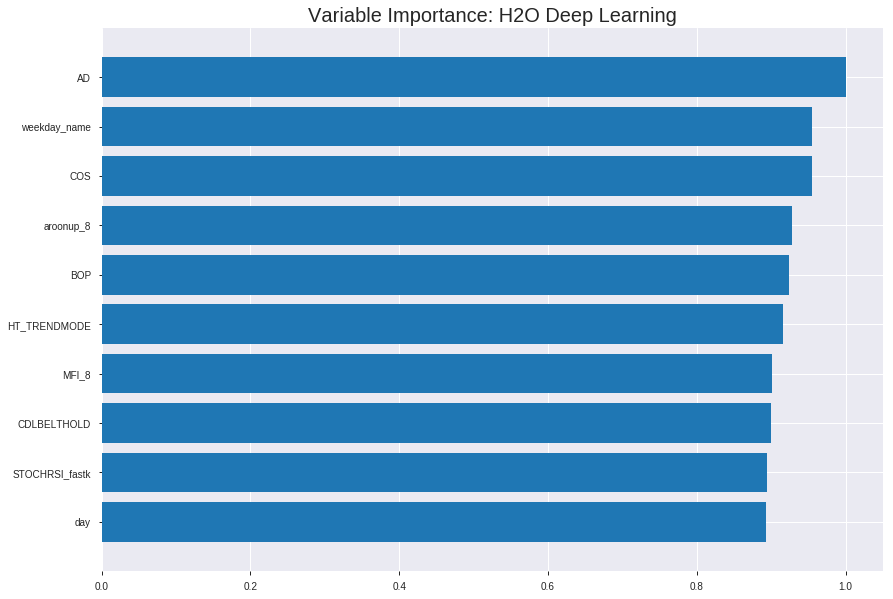

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190823_233947_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2652569037443846
RMSE: 0.5150309735776913
LogLoss: 0.7293838512513726
Mean Per-Class Error: 0.44082160574624685
AUC: 0.5660214154653461
pr_auc: 0.608033548219565
Gini: 0.13204283093069225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0946080246846322: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    755   0.996    (755.0/758.0)
1      0    893   0        (0.0/893.0)
Total  3    1648  0.4573   (755.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.094608     0.702873  396
max f2                       0.094608     0.855364  396
max f0point5                 0.348734     0.599588  268
max accuracy                 0.349905     0.561478  267
max precision                0.887336     1         0
max recall                   0.094608     1         396
max specificity              0.887336     1         0
max absolute_mcc             0.402797     0.117963  225
max min_per_class_accuracy   0.402797     0.557671  225
max mean_per_class_accuracy  0.402797     0.559178  225

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 42.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.789547           1.52256   1.52256            0.823529         0.831809  0.823529                    0.831809            0.0156775       0.0156775                  52.2561   52.2561
    2        0.0205936                   0.739366           1.52256   1.52256            0.823529         0.76034   0.823529                    0.796075            0.0156775       0.031355                   52.2561   52.2561
    3        0.0302847                   0.718539           1.38662   1.47906            0.75             0.728541  0.8                         0.774464            0.0134378       0.0447928                  38.6618   47.9059
    4        0.0405815                   0.705435           1.1963    1.40731            0.647059         0.709427  0.761194                    0.757962            0.012318        0.0571109                  19.6298   40.7314
    5        0.0502726                   0.693317           1.15552   1.35877            0.625            0.700504  0.73494                     0.746886            0.0111982       0.0683091                  15.5515   35.8774
    6        0.100545                    0.627487           1.11375   1.23626            0.60241          0.65703   0.668675                    0.701958            0.055991        0.1243                     11.375    23.6262
    7        0.150212                    0.584303           1.08224   1.18533            0.585366         0.603678  0.641129                    0.669462            0.0537514       0.178052                   8.22385   18.5335
    8        0.200485                    0.541909           1.02465   1.14504            0.554217         0.558821  0.619335                    0.641718            0.0515118       0.229563                   2.46496   14.5042
    9        0.300424                    0.47992            1.07568   1.12197            0.581818         0.510908  0.606855                    0.598203            0.107503        0.337066                   7.56795   12.1968
    10       0.400363                    0.438633           1.1317    1.1244             0.612121         0.457087  0.608169                    0.562977            0.113102        0.450168                   13.1705   12.4398
    11       0.500303                    0.403061           1.03086   1.10571            0.557576         0.420732  0.598063                    0.534562            0.103024        0.553191                   3.08595   10.5713
    12       0.600242                    0.369398           0.885195  1.069              0.478788         0.386651  0.578204                    0.509935            0.0884658       0.641657                   -11.4805  6.89972
    13       0.700182                    0.340302           0.952425  1.05236            0.515152         0.354953  0.569204                    0.487814            0.0951848       0.736842                   -4.75754  5.23584
    14       0.800121                    0.307093           0.78435   1.01888            0.424242         0.323527  0.551098                    0.467294            0.0783875       0.81523                    -21.565   1.88827
    15       0.900061                    0.267851           0.952425  1.0115             0.515152         0.289317  0.547106                    0.447532            0.0951848       0.910414                   -4.75754  1.15034
    16       1                           0.0105709          0.8964    1                  0.484848         0.207971  0.540884                    0.42359          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.39021296444511905
RMSE: 0.624670284586292
LogLoss: 10.237203443682342
Mean Per-Class Error: 0.45400843881856545
AUC: 0.5378759314121555
pr_auc: 0.5279208572168084
Gini: 0.07575186282431101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.411087921707853e-60: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       3.41109e-60  0.664781   183
max f2                       3.41109e-60  0.832153   183
max f0point5                 3.41109e-60  0.553462   183
max accuracy                 0.374175     0.54661    146
max precision                0.760959     0.666667   2
max recall                   3.41109e-60  1          183
max specificity              0.806262     0.995781   0
max absolute_mcc             0.374175     0.0989275  146
max min_per_class_accuracy   0.00937279   0.421277   182
max mean_per_class_accuracy  0.31313      0.545992   166

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 19.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.723768           0.803404  0.803404           0.4              0.758512  0.4                         0.758512            0.00851064      0.00851064                 -19.6596  -19.6596
    2        0.0211864                   0.700006           0.401702  0.602553           0.2              0.716758  0.3                         0.737635            0.00425532      0.012766                   -59.8298  -39.7447
    3        0.0317797                   0.681552           0.803404  0.669504           0.4              0.686936  0.333333                    0.720735            0.00851064      0.0212766                  -19.6596  -33.0496
    4        0.0402542                   0.665651           1.00426   0.739978           0.5              0.672203  0.368421                    0.710518            0.00851064      0.0297872                  0.425532  -26.0022
    5        0.0508475                   0.651062           1.20511   0.836879           0.6              0.656395  0.416667                    0.699242            0.012766        0.0425532                  20.5106   -16.3121
    6        0.101695                    0.591637           1.50638   1.17163            0.75             0.6222    0.583333                    0.660721            0.0765957       0.119149                   50.6383   17.1631
    7        0.150424                    0.546029           1.04792   1.13156            0.521739         0.565926  0.56338                     0.630013            0.0510638       0.170213                   4.79186   13.1555
    8        0.201271                    0.500677           1.17163   1.14168            0.583333         0.522693  0.568421                    0.6029              0.0595745       0.229787                   17.1631   14.168
    9        0.300847                    0.379304           1.06836   1.11741            0.531915         0.430348  0.556338                    0.545788            0.106383        0.33617                    6.83567   11.7411
    10       1                           0                  0.949478  1                  0.472727         0.039087  0.497881                    0.191527            0.66383         1                          -5.05222  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-23 23:41:32  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-23 23:41:34  1 min 40.686 sec  325 obs/sec       0.304664  1             503        0.677303         10.4212             -0.847307      0.521228        0.313617           1.09367          0.459116                         0.705607           16.565                -0.991561        0.545489          0.558188             1.60681            0.502119
    2019-08-23 23:41:46  1 min 52.502 sec  312 obs/sec       2.33677   7             3858       0.516557         0.775194            -0.0745098     0.631903        0.651898           1.63132          0.428831                         0.648418           10.4695               -0.681815        0.536933          0.528003             0.803404           0.502119
    2019-08-23 23:41:56  2 min  2.603 sec  308 obs/sec       4.01211   12            6624       0.51176          0.746729            -0.0546435     0.589275        0.611507           0.978789         0.456087                         0.654884           10.4387               -0.715521        0.540713          0.547928             1.20511            0.502119
    2019-08-23 23:42:07  2 min 13.849 sec  311 obs/sec       6.00909   18            9921       0.500852         0.695294            -0.0101636     0.557139        0.60028            1.41381          0.456087                         0.628856           10.2704               -0.581869        0.540192          0.547993             1.60681            0.502119
    2019-08-23 23:42:16  2 min 22.765 sec  315 obs/sec       7.6281    23            12594      0.558336         0.842866            -0.255349      0.515405        0.546498           0.978789         0.45003                          0.623605           10.2474               -0.555561        0.534608          0.533142             1.20511            0.502119
    2019-08-23 23:42:27  2 min 33.428 sec  319 obs/sec       9.60448   29            15857      0.528924         0.763294            -0.126573      0.552168        0.578128           1.52256          0.455482                         0.656397           10.4061               -0.723459        0.541826          0.549253             1.60681            0.502119
    2019-08-23 23:42:37  2 min 43.920 sec  323 obs/sec       11.6202   35            19185      0.515031         0.729384            -0.0681695     0.566021        0.608034           1.52256          0.457299                         0.62467            10.2372               -0.56088         0.537876          0.527921             0.803404           0.502119

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
AD                        1.0                    1.0                  0.0018482560583297687
weekday_name              0.9552348852157593     0.9552348852157593   0.0017655186637279682
COS                       0.955157995223999      0.955157995223999    0.0017653765513348724
aroonup_8                 0.9276467561721802     0.9276467561721802   0.0017145287370851896
BOP                       0.9237990379333496     0.9237990379333496   0.0017074171685395251
---                       ---                    ---                  ---
BBANDS_upperband_14_0_5   0.4355400502681732     0.4355400502681732   0.0008049895365534031
BBANDS_upperband_14_3_2   0.43351882696151733    0.43351882696151733  0.0008012537983316391
MA_20_5                   0.4300241768360138     0.4300241768360138   0.0007947947900654342
BBANDS_middleband_20_2_3  0.4276328384876251     0.4276328384876251   0.0007903749844755086
BBANDS_lowerband_14_4_5   0.4212697446346283     0.4212697446346283   0.0007786143577119863


See the whole table with table.as_data_frame()


Could not find exact threshold 0.0; using closest threshold found 0.0.


('accuracy', 0.5042372881355932)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 17.41573894489139)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.710096675203872)

('mse', 0.5042372881355932)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


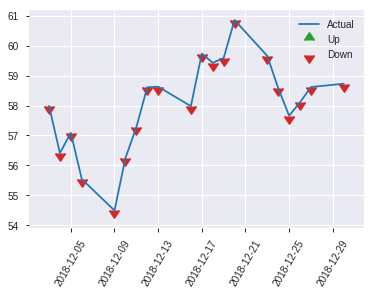


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5042372881355932
RMSE: 0.710096675203872
LogLoss: 17.41573894489139
Could not find exact threshold 0.0; using closest threshold found 0.0.
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.670423  0
max f2                       0            0.835674  0
max f0point5                 0            0.559737  0
max accuracy                 0            0.504237  0
max precision                0            0.504237  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.504237         0        0.504237                    0                   1               1                          0       0

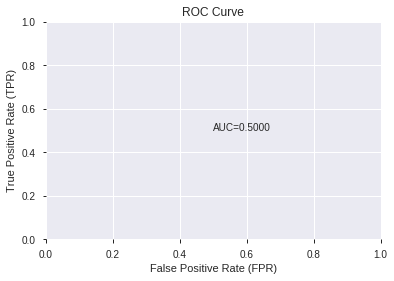

This function is available for GLM models only


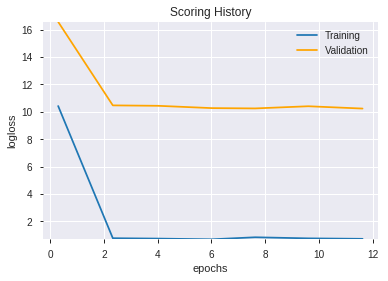

--2019-08-24 00:06:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.100
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  21.6MB/s    in 13s     

2019-08-24 00:06:17 (27.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190823_233947_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190823_233947_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_000712_model_1  0.5  17.415739                   0.5  0.710097  0.504237
1  DeepLearning_grid_1_AutoML_20190824_000712_model_4  0.5  17.415739                   0.5  0.710097  0.504237
2  DeepLearning_grid_1_AutoML_20190824_000712_model_3  0.5  17.415739                   0.5  0.710097  0.504237
3               DeepLearning_1_AutoML_20190824_000712  0.5  17.415739                   0.5  0.710097  0.504237
4  DeepLearning_grid_1_AutoML_20190824_000712_model_8  0.5   0.700524                   0.5  0.503643  0.253656
5  DeepLearning_grid_1_AutoML_20190824_000712_model_9  0.5  17.415739                   0.5  0.710097  0.504237
6  DeepLearning_grid_1_AutoML_20190824_000712_model_5  0.5  17.415739                   0.5  0.710097  0.504237
7  DeepLearning_grid_1_AutoML_20190824_000712_model_2  0.5  17.415739                   0.5  0.710097  0.504237
8  DeepLearning_grid_1_AutoML_20190824_000712_model_6  0.5  17.415739                   0.5  0.710097  0.504237
9  DeepLearning_grid_1_AutoML_20190824_000712_model_7  0.5  17.415739                   0.5  0.710097  0.504237

variable  relative_importance  scaled_importance  percentage
0          CDLPIERCING             1.000000           1.000000    0.021229
1            dayofyear             0.999213           0.999213    0.021212
2        days_in_month             0.991838           0.991838    0.021055
3             CORREL_8             0.987144           0.987144    0.020956
4                  EXP             0.983262           0.983262    0.020873
5       CDLMATCHINGLOW             0.982976           0.982976    0.020867
6                month             0.972471           0.972471    0.020644
7       CDLSPINNINGTOP             0.972367           0.972367    0.020642
8              BETA_24             0.971172           0.971172    0.020617
9                  day             0.963810           0.963810    0.020460
10                TANH             0.963404           0.963404    0.020452
11  CDLMORNINGDOJISTAR             0.957918           0.957918    0.020335
12              MFI_30             0.956286           0.956286    0.020301
13   CDLLONGLEGGEDDOJI             0.955916           0.955916    0.020293
14        weekday_name             0.955850           0.955850    0.020291
15           aroonup_8             0.954038           0.954038    0.020253
16              MFI_24             0.952313           0.952313    0.020216
17         aroondown_8             0.951701           0.951701    0.020203
18           dayofweek             0.950998           0.950998    0.020188
19                 SIN             0.950736           0.950736    0.020183
20             ADXR_14             0.949318           0.949318    0.020153
21      STOCHRSI_fastk             0.948790           0.948790    0.020142
22         STOCH_slowk             0.947171           0.947171    0.020107
23                 COS             0.942906           0.942906    0.020017
24        STOCHF_fastk             0.942032           0.942032    0.019998
25      CDLMORNINGSTAR             0.941776           0.941776    0.019993
26         CDLBELTHOLD             0.940597           0.940597    0.019968
27        CDLTHRUSTING             0.940284           0.940284    0.019961
28           CORREL_20             0.939722           0.939722    0.019949
29          weekofyear             0.938411           0.938411    0.019921
30     CDLADVANCEBLOCK             0.937720           0.937720    0.019907
31                  AD             0.935347           0.935347    0.019856
32          aroonup_24             0.933320           0.933320    0.019813
33          aroonup_30             0.929717           0.929717    0.019737
34        aroondown_30             0.929575           0.929575    0.019734
35                 BOP             0.927448           0.927448    0.019689
36   CDLDARKCLOUDCOVER             0.923876           0.923876    0.019613
37             quarter             0.923839           0.923839    0.019612
38        HT_TRENDMODE             0.923509           0.923509    0.019605
39               MFI_8             0.921021           0.921021    0.019552
40          aroonup_20             0.918655           0.918655    0.019502
41             weekday             0.918219           0.918219    0.019493
42         STOCH_slowd             0.911905           0.911905    0.019359
43              ULTOSC             0.911102           0.911102    0.019342
44              TRANGE             0.906430           0.906430    0.019242
45             BETA_20             0.904721           0.904721    0.019206
46              BETA_8             0.898956           0.898956    0.019084
47                week             0.895612           0.895612    0.019013
48         HT_DCPERIOD             0.880798           0.880798    0.018698
49           CORREL_30             0.869782           0.869782    0.018464

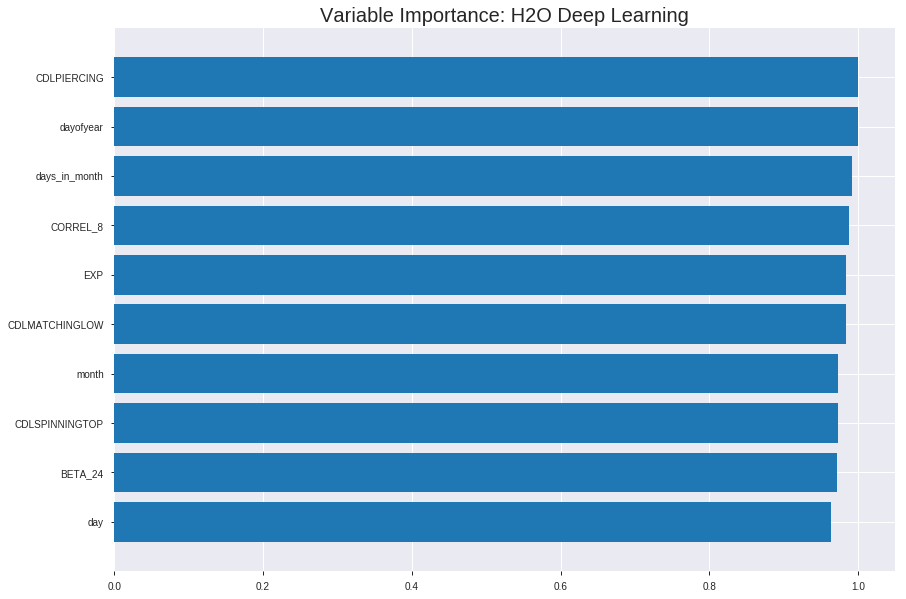

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_000712_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.34235171593125996
RMSE: 0.5851082941911352
LogLoss: 1.276850763285976
Mean Per-Class Error: 0.43203145544206323
AUC: 0.5900200031319527
pr_auc: 0.6178481604679852
Gini: 0.18004000626390537
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0006686183169226303: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   738   0.9736   (738.0/758.0)
1      9    884   0.0101   (9.0/893.0)
Total  29   1622  0.4525   (747.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000668618  0.702982  398
max f2                       0.00014142   0.854873  399
max f0point5                 0.143891     0.615171  319
max accuracy                 0.143891     0.581466  319
max precision                0.999719     0.857143  0
max recall                   0.00014142   1         399
max specificity              0.999719     0.998681  0
max absolute_mcc             0.143891     0.143389  319
max min_per_class_accuracy   0.445792     0.56103   214
max mean_per_class_accuracy  0.516662     0.567969  193

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 47.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102968                   0.998744           1.63132   1.63132            0.882353         0.999298    0.882353                    0.999298            0.0167973       0.0167973                  63.1315    63.1315
    2        0.0205936                   0.99812            1.52256   1.57694            0.823529         0.998409    0.852941                    0.998854            0.0156775       0.0324748                  52.2561    57.6938
    3        0.0302847                   0.996582           1.15552   1.44208            0.625            0.997322    0.78                        0.998364            0.0111982       0.043673                   15.5515    44.2083
    4        0.0405815                   0.994962           0.978789  1.32453            0.529412         0.99594     0.716418                    0.997749            0.0100784       0.0537514                  -2.12107   32.4531
    5        0.0502726                   0.993484           1.38662   1.3365             0.75             0.994186    0.722892                    0.997062            0.0134378       0.0671892                  38.6618    33.6499
    6        0.100545                    0.980049           1.2474    1.29195            0.674699         0.987732    0.698795                    0.992397            0.06271         0.129899                   24.7399    29.1949
    7        0.150212                    0.954859           1.08224   1.22261            0.585366         0.96809     0.66129                     0.98436             0.0537514       0.183651                   8.22385    22.261
    8        0.200485                    0.927174           1.04692   1.17856            0.566265         0.9419      0.637462                    0.973713            0.0526316       0.236282                   4.69245    17.8556
    9        0.300424                    0.838437           1.16532   1.17415            0.630303         0.885492    0.635081                    0.944365            0.116461        0.352744                   16.5319    17.4152
    10       0.400363                    0.666539           0.997245  1.12999            0.539394         0.759683    0.611195                    0.898265            0.0996641       0.452408                   -0.275544  12.9992
    11       0.500303                    0.451989           1.04206   1.11243            0.563636         0.560462    0.601695                    0.830786            0.104143        0.556551                   4.20645    11.2428
    12       0.600242                    0.244438           0.974835  1.08952            0.527273         0.34477     0.589304                    0.749865            0.0974244       0.653975                   -2.51654   8.9519
    13       0.700182                    0.123506           1.00845   1.07795            0.545455         0.183702    0.583045                    0.669055            0.100784        0.754759                   0.844956   7.79477
    14       0.800121                    0.0416441          0.91881   1.05807            0.49697          0.0755311   0.572294                    0.59492             0.0918253       0.846585                   -8.11904   5.80705
    15       0.900061                    0.00840442         0.76194   1.02519            0.412121         0.0235262   0.554509                    0.531475            0.0761478       0.922732                   -23.806    2.51892
    16       1                           1.22451e-34        0.773145  1                  0.418182         0.0027



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.42716519866353636
RMSE: 0.6535787624024639
LogLoss: 11.239580618464768
Mean Per-Class Error: 0.4462519077116438
AUC: 0.5469701050363588
pr_auc: 0.5726039393796101
Gini: 0.09394021007271758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.142273181260647e-161: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold     value     idx
---------------------------  ------------  --------  -----
max f1                       8.14227e-161  0.664781  182
max f2                       8.14227e-161  0.832153  182
max f0point5                 8.14227e-161  0.553462  182
max accuracy                 0.207219      0.555085  86
max precision                0.997702      1         0
max recall                   8.14227e-161  1         182
max specificity              0.997702      1         0
max absolute_mcc             0.362953      0.154265  59
max min_per_class_accuracy   1.46519e-17   0.417021  176
max mean_per_class_accuracy  0.207219      0.553748  86

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 10.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.942738           2.00851   2.00851            1                0.963718     1                           0.963718            0.0212766       0.0212766                  100.851   100.851
    2        0.0211864                   0.893972           1.60681   1.80766            0.8              0.911556     0.9                         0.937637            0.0170213       0.0382979                  60.6809   80.766
    3        0.0317797                   0.860869           0.803404  1.47291            0.4              0.873185     0.733333                    0.916153            0.00851064      0.0468085                  -19.6596  47.2908
    4        0.0402542                   0.820813           1.00426   1.37424            0.5              0.839227     0.684211                    0.899958            0.00851064      0.0553191                  0.425532  37.4244
    5        0.0508475                   0.797029           0.803404  1.25532            0.4              0.809827     0.625                       0.881181            0.00851064      0.0638298                  -19.6596  25.5319
    6        0.101695                    0.441833           1.59007   1.4227             0.791667         0.597451     0.708333                    0.739316            0.0808511       0.144681                   59.0071   42.2695
    7        0.150424                    0.2963             1.04792   1.30129            0.521739         0.365555     0.647887                    0.618238            0.0510638       0.195745                   4.79186   30.1289
    8        0.201271                    0.167119           1.00426   1.22625            0.5              0.227321     0.610526                    0.51948             0.0510638       0.246809                   0.425532  22.6249
    9        0.300847                    0.000669084        0.982888  1.1457             0.489362         0.0456396    0.570423                    0.362646            0.0978723       0.344681                   -1.71118  14.57
    10       1                           0                  0.937305  1                  0.466667         8.97052e-06  0.497881                    0.109107            0.655319        1                          -6.2695   0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:07:13  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:07:20  6.757 sec   1751 obs/sec      7         1             11557      0.585108         1.27685             -0.378624      0.59002         0.617848           1.63132          0.452453                         0.653579           11.2396               -0.708691        0.54697           0.572604             2.00851            0.502119
    2019-08-24 00:07:25  12.374 sec  1908 obs/sec      14        2             23114      0.548419         1.07188             -0.211152      0.641946        0.643373           1.84882          0.440945                         0.657395           11.4059               -0.728705        0.550355          0.564518             1.60681            0.502119
    2019-08-24 00:07:30  17.602 sec  2014 obs/sec      21        3             34671      0.534857         1.01371             -0.151991      0.670496        0.672263           1.84882          0.399152                         0.65857            11.3184               -0.734891        0.546207          0.560153             1.20511            0.502119
    2019-08-24 00:07:36  23.003 sec  2063 obs/sec      28        4             46228      0.506081         0.902456            -0.0313694     0.719616        0.735493           1.74007          0.351908                         0.667795           11.3198               -0.783832        0.54363           0.554708             1.20511            0.502119
    2019-08-24 00:07:41  27.982 sec  2118 obs/sec      35        5             57785      0.462535         0.712406            0.138486       0.769808        0.793966           1.84882          0.322835                         0.652946           11.2897               -0.705383        0.549978          0.560022             1.20511            0.502119
    2019-08-24 00:07:51  37.643 sec  2195 obs/sec      49        7             80899      0.446752         0.696337            0.196276       0.800127        0.796887           1.74007          0.277408                         0.667761           11.3856               -0.783653        0.545004          0.55434              1.60681            0.502119
    2019-08-24 00:07:51  37.727 sec  2194 obs/sec      49        7             80899      0.585108         1.27685             -0.378624      0.59002         0.617848           1.63132          0.452453                         0.653579           11.2396               -0.708691        0.54697           0.572604             2.00851            0.502119

Variable Importances: 


variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  --------------------
CDLPIERCING    1.0                    1.0                  0.021228728307068952
dayofyear      0.9992131590843201     0.9992131590843201   0.0212120246750491
days_in_month  0.991838276386261      0.991838276386261    0.021055465293955498
CORREL_8       0.9871442317962646     0.9871442317962646   0.0209558166966932
EXP            0.9832618832588196     0.9832618832588196   0.02087339937439843
---            ---                    ---                  ---
BETA_20        0.9047205448150635     0.9047205448150635   0.019206066639702382
BETA_8         0.8989561200141907     0.8989561200141907   0.019083695231758124
week           0.895612359046936      0.895612359046936    0.01901271143866049
HT_DCPERIOD    0.8807979226112366     0.8807979226112366   0.018698219792544685
CORREL_30      0.8697823286056519     0.8697823286056519   0.018464372740259152


See the whole table with table.as_data_frame()


Could not find exact threshold 0.0; using closest threshold found 0.0.


('accuracy', 0.5042372881355932)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 17.41573894489139)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.710096675203872)

('mse', 0.5042372881355932)

deeplearning prediction progress: |███████████████████████████████████████| 100%


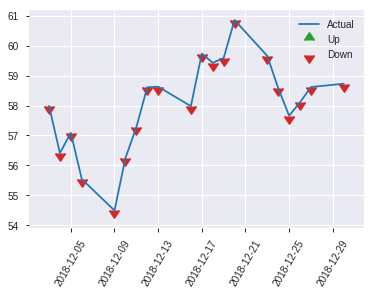


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5042372881355932
RMSE: 0.710096675203872
LogLoss: 17.41573894489139
Could not find exact threshold 0.0; using closest threshold found 0.0.
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.670423  0
max f2                       0            0.835674  0
max f0point5                 0            0.559737  0
max accuracy                 0            0.504237  0
max precision                0            0.504237  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.504237         0        0.504237                    0                   1               1                          0       0

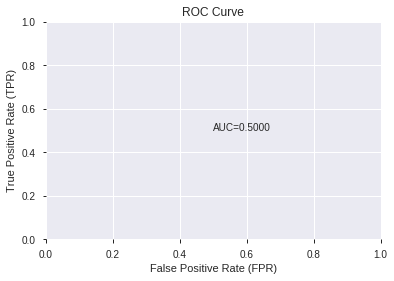

This function is available for GLM models only


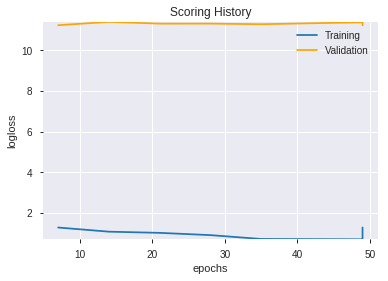

--2019-08-24 00:14:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_000712_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_000712_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLPIERCING',
 'dayofyear',
 'days_in_month',
 'CORREL_8',
 'EXP',
 'CDLMATCHINGLOW',
 'month',
 'CDLSPINNINGTOP',
 'BETA_24',
 'day',
 'TANH',
 'CDLMORNINGDOJISTAR',
 'MFI_30',
 'CDLLONGLEGGEDDOJI',
 'weekday_name',
 'aroonup_8',
 'MFI_24',
 'aroondown_8',
 'dayofweek',
 'SIN',
 'ADXR_14',
 'STOCHRSI_fastk',
 'STOCH_slowk',
 'COS',
 'STOCHF_fastk',
 'CDLMORNINGSTAR',
 'CDLBELTHOLD',
 'CDLTHRUSTING',
 'CORREL_20',
 'weekofyear',
 'CDLADVANCEBLOCK',
 'AD',
 'aroonup_24',
 'aroonup_30',
 'aroondown_30',
 'BOP',
 'CDLDARKCLOUDCOVER',
 'quarter',
 'HT_TRENDMODE',
 'MFI_8',
 'aroonup_20',
 'weekday',
 'STOCH_slowd',
 'ULTOSC',
 'TRANGE',
 'BETA_20',
 'BETA_8',
 'week',
 'HT_DCPERIOD',
 'CORREL_30']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_001520_model_1  0.5  17.415739                   0.5  0.710097  0.504237

variable  relative_importance  scaled_importance  percentage
0          CDLBELTHOLD             0.008838           1.000000    0.057918
1                  BOP             0.007630           0.863353    0.050003
2              BETA_24             0.007517           0.850602    0.049265
3       STOCHRSI_fastk             0.006904           0.781180    0.045244
4              BETA_20             0.006385           0.722435    0.041842
5               TRANGE             0.005854           0.662397    0.038364
6                   AD             0.005432           0.614619    0.035597
7                  COS             0.005116           0.578838    0.033525
8       CDLSPINNINGTOP             0.004723           0.534445    0.030954
9            CORREL_20             0.004693           0.530992    0.030754
10      CDLMATCHINGLOW             0.004457           0.504325    0.029209
11            CORREL_8             0.004147           0.469281    0.027180
12         aroondown_8             0.003923           0.443939    0.025712
13              ULTOSC             0.003883           0.439354    0.025446
14                TANH             0.003785           0.428262    0.024804
15           CORREL_30             0.003677           0.416021    0.024095
16                 day             0.003531           0.399527    0.023140
17         STOCH_slowd             0.003485           0.394324    0.022838
18           aroonup_8             0.003479           0.393625    0.022798
19        STOCHF_fastk             0.003308           0.374303    0.021679
20                 EXP             0.003302           0.373628    0.021640
21   CDLDARKCLOUDCOVER             0.003227           0.365172    0.021150
22        HT_TRENDMODE             0.003124           0.353520    0.020475
23  CDLMORNINGDOJISTAR             0.002608           0.295118    0.017093
24         CDLPIERCING             0.002588           0.292800    0.016958
25          weekofyear             0.002581           0.292064    0.016916
26                week             0.002569           0.290680    0.016835
27   CDLLONGLEGGEDDOJI             0.002545           0.287919    0.016676
28               MFI_8             0.002495           0.282339    0.016352
29             ADXR_14             0.002473           0.279850    0.016208
30              MFI_30             0.002392           0.270658    0.015676
31          aroonup_30             0.002057           0.232790    0.013483
32          aroonup_24             0.001975           0.223457    0.012942
33              MFI_24             0.001894           0.214317    0.012413
34             weekday             0.001542           0.174431    0.010103
35           dayofweek             0.001536           0.173776    0.010065
36        aroondown_30             0.001429           0.161693    0.009365
37                 SIN             0.001422           0.160864    0.009317
38           dayofyear             0.001411           0.159659    0.009247
39         HT_DCPERIOD             0.001331           0.150660    0.008726
40     CDLADVANCEBLOCK             0.001212           0.137157    0.007944
41             quarter             0.001169           0.132273    0.007661
42        CDLTHRUSTING             0.001144           0.129401    0.007495
43               month             0.001109           0.125495    0.007268
44         STOCH_slowk             0.001063           0.120322    0.006969
45      CDLMORNINGSTAR             0.000610           0.069055    0.003999
46          aroonup_20             0.000308           0.034864    0.002019
47              BETA_8             0.000266           0.030145    0.001746
48       days_in_month             0.000239           0.026997    0.001564
49        weekday_name             0.000203           0.023003    0.001332

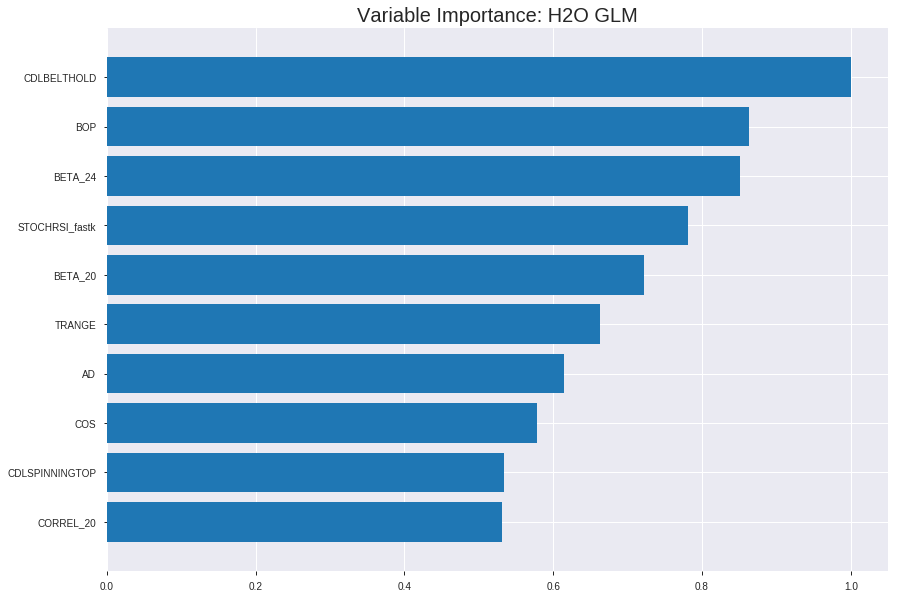

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_001520_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24688208222669852
RMSE: 0.49687229971764224
LogLoss: 0.6868873598024098
Null degrees of freedom: 1650
Residual degrees of freedom: 1600
Null deviance: 2277.720891745009
Residual deviance: 2268.102062067557
AIC: 2370.102062067557
AUC: 0.589813176065972
pr_auc: 0.6191611276993829
Gini: 0.1796263521319439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5261456197322781: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      55   703   0.9274   (703.0/758.0)
1      23   870   0.0258   (23.0/893.0)
Total  78   1573  0.4397   (726.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.526146     0.705596  353
max f2                       0.518216     0.855882  387
max f0point5                 0.535748     0.617859  262
max accuracy                 0.535748     0.584494  262
max precision                0.575322     1         0
max recall                   0.495184     1         398
max specificity              0.575322     1         0
max absolute_mcc             0.537501     0.150204  244
max min_per_class_accuracy   0.540981     0.554311  202
max mean_per_class_accuracy  0.539254     0.57339   223

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 54.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.564188           1.52256   1.52256            0.823529         0.568951  0.823529                    0.568951            0.0156775       0.0156775                  52.2561   52.2561
    2        0.0205936                   0.560868           1.63132   1.57694            0.882353         0.562001  0.852941                    0.565476            0.0167973       0.0324748                  63.1315   57.6938
    3        0.0302847                   0.559227           1.27107   1.47906            0.6875           0.559715  0.8                         0.563632            0.012318        0.0447928                  27.1067   47.9059
    4        0.0405815                   0.558097           1.08754   1.37972            0.588235         0.558749  0.746269                    0.562393            0.0111982       0.055991                   8.75436   37.972
    5        0.0502726                   0.556176           1.03996   1.31422            0.5625           0.557202  0.710843                    0.561393            0.0100784       0.0660694                  3.99636   31.4224
    6        0.100545                    0.551724           1.18057   1.2474             0.638554         0.553947  0.674699                    0.55767             0.0593505       0.12542                    18.0574   24.7399
    7        0.150212                    0.549563           1.10479   1.20024            0.597561         0.550621  0.649194                    0.555339            0.0548712       0.180291                   10.4785   20.0245
    8        0.200485                    0.547821           1.18057   1.19531            0.638554         0.548707  0.646526                    0.553676            0.0593505       0.239642                   18.0574   19.5312
    9        0.300424                    0.54541            1.06447   1.15179            0.575758         0.546473  0.622984                    0.55128             0.106383        0.346025                   6.44745   15.1788
    10       0.400363                    0.543174           1.01965   1.1188             0.551515         0.544167  0.605144                    0.549504            0.101904        0.447928                   1.96546   11.8804
    11       0.500303                    0.541014           1.05327   1.10571            0.569697         0.542105  0.598063                    0.548026            0.105263        0.553191                   5.32695   10.5713
    12       0.600242                    0.53886            1.1205    1.10818            0.606061         0.540042  0.599395                    0.546697            0.111982        0.665174                   12.05     10.8175
    13       0.700182                    0.536267           0.907605  1.07955            0.490909         0.537564  0.58391                     0.545393            0.0907055       0.755879                   -9.23954  7.9547
    14       0.800121                    0.533374           0.907605  1.05807            0.490909         0.534891  0.572294                    0.544082            0.0907055       0.846585                   -9.23954  5.80705
    15       0.900061                    0.529288           0.750735  1.02395            0.406061         0.531579  0.553836                    0.542693            0.075028        0.921613                   -24.9265  2.3945
    16       1                           0.465127           0.78435   1                  0.424242         0.524593  0.540884                    0.540884            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3844622574797954
RMSE: 0.6200502056122515
LogLoss: 10.187470664450068
Null degrees of freedom: 471
Residual degrees of freedom: 421
Null deviance: 657.825185254164
Residual deviance: 191558.53568434168
AIC: 191660.53568434168
AUC: 0.5403447347158632
pr_auc: 0.5346925906661895
Gini: 0.08068946943172639
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.664781  184
max f2                       0            0.832153  184
max f0point5                 0            0.553462  184
max accuracy                 0.534892     0.54661   130
max precision                0.559663     1         0
max recall                   0            1         184
max specificity              0.559663     1         0
max absolute_mcc             0.534892     0.101986  130
max min_per_class_accuracy   3.54144e-09  0.425532  183
max mean_per_class_accuracy  0.524414     0.546045  172

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 20.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.553625           1.20511   1.20511            0.6              0.556963   0.6                         0.556963            0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.55123            0.803404  1.00426            0.4              0.551977   0.5                         0.55447             0.00851064      0.0212766                  -19.6596  0.425532
    3        0.0317797                   0.550631           0.401702  0.803404           0.2              0.550859   0.4                         0.553266            0.00425532      0.0255319                  -59.8298  -19.6596
    4        0.0402542                   0.549968           1.50638   0.9514             0.75             0.550398   0.473684                    0.552663            0.012766        0.0382979                  50.6383   -4.86002
    5        0.0508475                   0.548703           1.60681   1.08794            0.8              0.549133   0.541667                    0.551927            0.0170213       0.0553191                  60.6809   8.79433
    6        0.101695                    0.545832           1.17163   1.12979            0.583333         0.547228   0.5625                      0.549578            0.0595745       0.114894                   17.1631   12.9787
    7        0.150424                    0.543133           1.13525   1.13156            0.565217         0.544353   0.56338                     0.547885            0.0553191       0.170213                   13.5245   13.1555
    8        0.201271                    0.540313           1.08794   1.12054            0.541667         0.54164    0.557895                    0.546308            0.0553191       0.225532                   8.79433   12.0538
    9        0.300847                    0.533489           1.11109   1.11741            0.553191         0.536671   0.556338                    0.543118            0.110638        0.33617                    11.1091   11.7411
    10       1                           0                  0.949478  1                  0.472727         0.0647264  0.497881                    0.208649            0.66383         1                          -5.05222  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:15:20  0.000 sec   2            4.1       51            1.37377           405.844
    2019-08-24 00:15:20  0.026 sec   4            2.5       51            1.37105           405.886
    2019-08-24 00:15:20  0.045 sec   6            1.6       51            1.3675            405.943
    2019-08-24 00:15:20  0.076 sec   8            0.97      51            1.36317           406.017
    2019-08-24 00:15:20  0.090 sec   10           0.61      51            1.35827           406.105

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5042372881355932)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 17.41573894489139)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.710096675203872)

('mse', 0.5042372881355932)

glm prediction progress: |████████████████████████████████████████████████| 100%


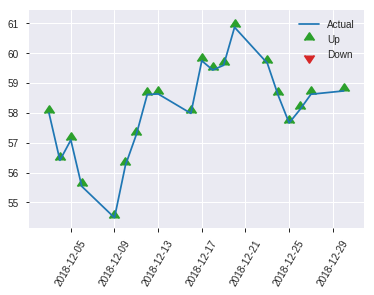


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5042372881355932
RMSE: 0.710096675203872
LogLoss: 17.41573894489139
Null degrees of freedom: 235
Residual degrees of freedom: 185
Null deviance: 328.4208830413794
Residual deviance: 168598.34761067876
AIC: 168700.34761067876
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.670423  0
max f2                       0            0.835674  0
max f0point5                 0            0.559737  0
max accuracy                 0            0.504237  0
max precision                0            0.504237  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.504237         0        0.504237                    0                   1               1                          0       0

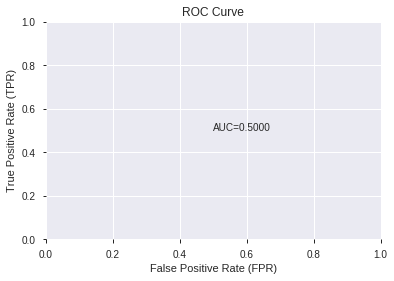

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


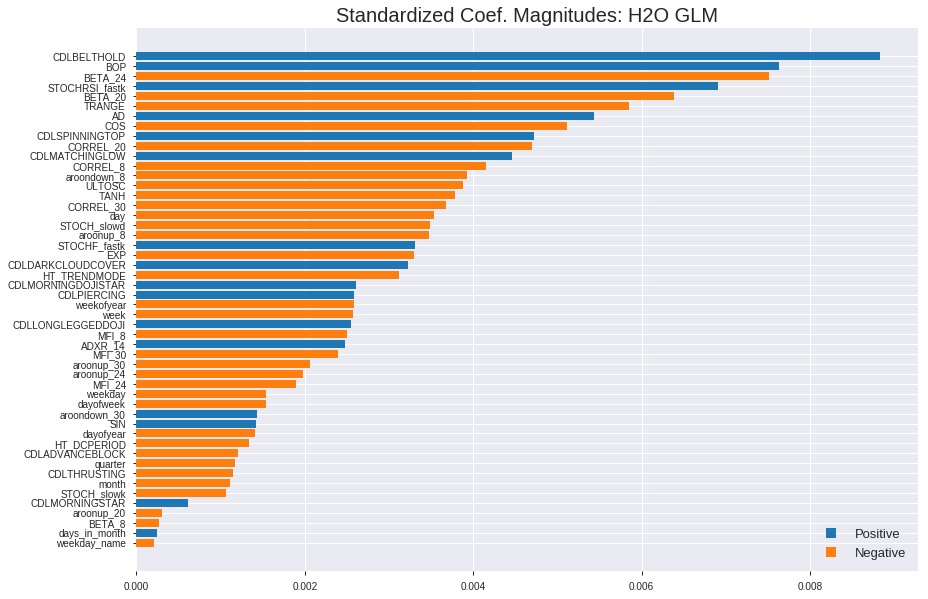

'log_likelihood'
--2019-08-24 00:15:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_001520_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_001520_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLBELTHOLD',
 'BOP',
 'BETA_24',
 'STOCHRSI_fastk',
 'BETA_20',
 'TRANGE',
 'AD',
 'COS',
 'CDLSPINNINGTOP',
 'CORREL_20',
 'CDLMATCHINGLOW',
 'CORREL_8',
 'aroondown_8',
 'ULTOSC',
 'TANH',
 'CORREL_30',
 'day',
 'STOCH_slowd',
 'aroonup_8',
 'STOCHF_fastk',
 'EXP',
 'CDLDARKCLOUDCOVER',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'weekofyear',
 'week',
 'CDLLONGLEGGEDDOJI',
 'MFI_8',
 'ADXR_14',
 'MFI_30',
 'aroonup_30',
 'aroonup_24',
 'MFI_24',
 'weekday',
 'dayofweek',
 'aroondown_30',
 'SIN',
 'dayofyear',
 'HT_DCPERIOD',
 'CDLADVANCEBLOCK',
 'quarter',
 'CDLTHRUSTING',
 'month',
 'STOCH_slowk',
 'CDLMORNINGSTAR',
 'aroonup_20',
 'BETA_8',
 'days_in_month',
 'weekday_name']

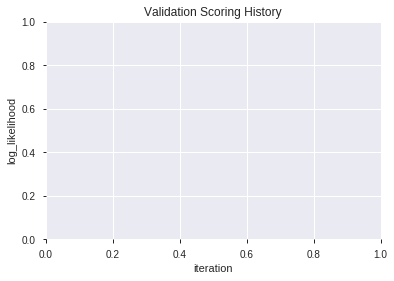

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_001627_model_1  0.570064  0.696754              0.487179  0.501573  0.251576
1               XGBoost_3_AutoML_20190824_001627  0.559434  0.698905              0.474144  0.502563  0.252569
2               XGBoost_1_AutoML_20190824_001627  0.556202  0.703392              0.500000  0.504366  0.254385
3  XGBoost_grid_1_AutoML_20190824_001627_model_3  0.534439  0.707243              0.491453  0.506522  0.256565
4  XGBoost_grid_1_AutoML_20190824_001627_model_4  0.532428  0.697023              0.495655  0.501713  0.251716
5  XGBoost_grid_1_AutoML_20190824_001627_model_2  0.529986  0.696485              0.491453  0.501620  0.251623
6  XGBoost_grid_1_AutoML_20190824_001627_model_6  0.527544  0.740412              0.474215  0.521117  0.271563
7               XGBoost_2_AutoML_20190824_001627  0.525892  0.702558              0.495726  0.504569  0.254590
8  XGBoost_grid_1_AutoML_20190824_001627_model_7  0.514544  0.719444              0.495655  0.511770  0.261908
9  XGBoost_grid_1_AutoML_20190824_001627_model_5  0.472384  0.785006              0.491453  0.538263  0.289727

variable  relative_importance  scaled_importance  percentage
0            CORREL_8           375.514038           1.000000    0.080270
1              TRANGE           331.269989           0.882177    0.070812
2                 BOP           278.286255           0.741081    0.059486
3                  AD           255.805206           0.681213    0.054681
4              MFI_24           234.293854           0.623928    0.050083
5             ADXR_14           226.135147           0.602202    0.048339
6             BETA_24           225.605881           0.600792    0.048225
7                 COS           222.152298           0.591595    0.047487
8        STOCHF_fastk           206.827805           0.550786    0.044211
9           CORREL_30           190.413681           0.507075    0.040703
10             MFI_30           185.195190           0.493178    0.039587
11                SIN           175.031342           0.466111    0.037415
12            BETA_20           138.714294           0.369398    0.029651
13                EXP           135.595444           0.361093    0.028985
14             BETA_8           122.295181           0.325674    0.026142
15             ULTOSC           120.748482           0.321555    0.025811
16        STOCH_slowk           115.543602           0.307694    0.024699
17       aroondown_30           108.728340           0.289545    0.023242
18        STOCH_slowd           106.185242           0.282773    0.022698
19          CORREL_20            97.311150           0.259141    0.020801
20        aroondown_8            96.640213           0.257354    0.020658
21        HT_DCPERIOD            86.910423           0.231444    0.018578
22          dayofweek            78.952354           0.210251    0.016877
23              MFI_8            70.346306           0.187333    0.015037
24         aroonup_20            64.930054           0.172910    0.013879
25     STOCHRSI_fastk            60.854500           0.162057    0.013008
26          aroonup_8            55.812824           0.148630    0.011931
27                day            53.532211           0.142557    0.011443
28         aroonup_30            48.984173           0.130446    0.010471
29          dayofyear            48.292091           0.128603    0.010323
30               TANH            35.467106           0.094449    0.007581
31       weekday_name            28.356173           0.075513    0.006061
32         aroonup_24            27.766266           0.073942    0.005935
33               week            27.316681           0.072745    0.005839
34  CDLLONGLEGGEDDOJI             9.931492           0.026448    0.002123
35        CDLBELTHOLD             9.519350           0.025350    0.002035
36         weekofyear             8.561245           0.022799    0.001830
37            weekday             6.384318           0.017002    0.001365
38     CDLMATCHINGLOW             6.299238           0.016775    0.001347
39      days_in_month             1.648040           0.004389    0.000352

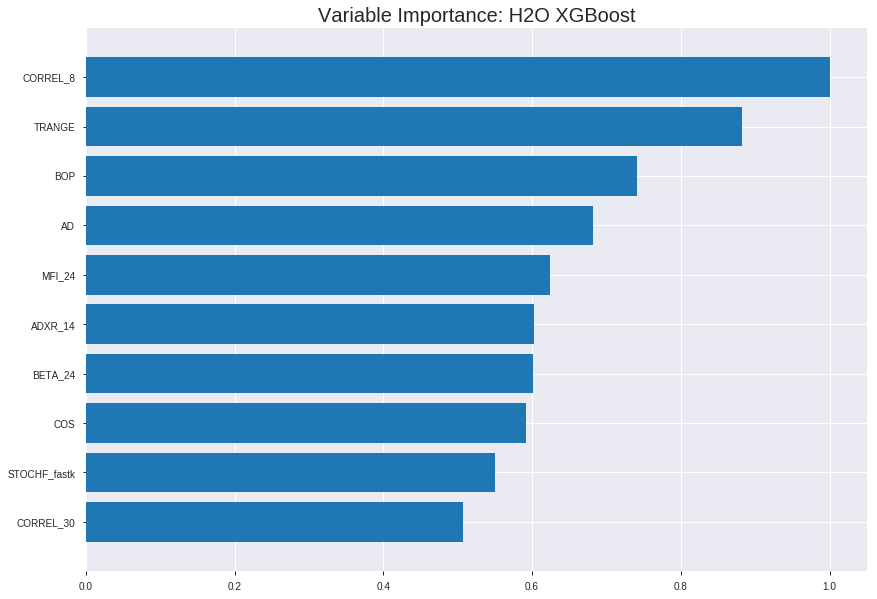

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_001627_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1819765963704821
RMSE: 0.42658714979530515
LogLoss: 0.5518887341741966
Mean Per-Class Error: 0.18251749904711811
AUC: 0.903396248157023
pr_auc: 0.9125256174854375
Gini: 0.806792496314046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5047206878662109: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      552  206   0.2718   (206.0/758.0)
1      84   809   0.0941   (84.0/893.0)
Total  636  1015  0.1757   (290.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504721     0.848008  224
max f2                       0.466304     0.907751  257
max f0point5                 0.581098     0.842878  152
max accuracy                 0.505846     0.824349  223
max precision                0.824586     1         0
max recall                   0.348195     1         351
max specificity              0.824586     1         0
max absolute_mcc             0.504721     0.649385  224
max min_per_class_accuracy   0.536991     0.811346  194
max mean_per_class_accuracy  0.505846     0.817483  223

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 53.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.774109           1.84882   1.84882            1                0.791217  1                           0.791217            0.019037        0.019037                   84.8824   84.8824
    2        0.0205936                   0.759711           1.84882   1.84882            1                0.76691   1                           0.779063            0.019037        0.0380739                  84.8824   84.8824
    3        0.0302847                   0.743578           1.84882   1.84882            1                0.751613  1                           0.770279            0.0179171       0.055991                   84.8824   84.8824
    4        0.0405815                   0.733172           1.84882   1.84882            1                0.737838  1                           0.762048            0.019037        0.075028                   84.8824   84.8824
    5        0.0502726                   0.724133           1.73327   1.82655            0.9375           0.728312  0.987952                    0.755544            0.0167973       0.0918253                  73.3273   82.6549
    6        0.100545                    0.694548           1.80427   1.81541            0.975904         0.707717  0.981928                    0.731631            0.0907055       0.182531                   80.4274   81.5412
    7        0.150212                    0.66508            1.75864   1.79664            0.95122          0.679712  0.971774                    0.714464            0.087346        0.269877                   75.8638   79.664
    8        0.200485                    0.643937           1.75972   1.78738            0.951807         0.655154  0.966767                    0.699592            0.0884658       0.358343                   75.9724   78.7383
    9        0.300424                    0.604938           1.60231   1.72582            0.866667         0.622941  0.933468                    0.674093            0.160134        0.518477                   60.2314   72.5818
    10       0.400363                    0.576035           1.43424   1.65303            0.775758         0.589993  0.8941                      0.6531              0.143337        0.661814                   43.4239   65.3033
    11       0.500303                    0.546147           1.22134   1.5668             0.660606         0.561801  0.847458                    0.634862            0.12206         0.783875                   22.1344   56.68
    12       0.600242                    0.510084           1.07568   1.48503            0.581818         0.528437  0.803229                    0.617143            0.107503        0.891377                   7.56795   48.5029
    13       0.700182                    0.469674           0.6723    1.36903            0.363636         0.489724  0.740484                    0.598956            0.0671892       0.958567                   -32.77    36.9026
    14       0.800121                    0.428979           0.235305  1.22742            0.127273         0.449049  0.663891                    0.580231            0.0235162       0.982083                   -76.4695  22.7418
    15       0.900061                    0.380437           0.145665  1.1073             0.0787879        0.405459  0.598923                    0.560825            0.0145577       0.996641                   -85.4335  10.7304
    16       1                           0.163716           0.033615  1                  0.0181818        0.32907   0.540884                    0.537664            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25261515604734347
RMSE: 0.5026083525443479
LogLoss: 0.6995756050950646
Mean Per-Class Error: 0.44744591076398244
AUC: 0.55405332615136
pr_auc: 0.5434292189781379
Gini: 0.1081066523027201
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24009791016578674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   223  0.9409   (223.0/237.0)
1      5    230  0.0213   (5.0/235.0)
Total  19   453  0.4831   (228.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.240098     0.668605  381
max f2                       0.162235     0.832743  398
max f0point5                 0.379921     0.569886  294
max accuracy                 0.516388     0.552966  156
max precision                0.748252     1         0
max recall                   0.162235     1         398
max specificity              0.748252     1         0
max absolute_mcc             0.684357     0.117225  12
max min_per_class_accuracy   0.49537      0.531646  190
max mean_per_class_accuracy  0.516388     0.552554  156

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.712834           1.60681   1.60681            0.8              0.730941  0.8                         0.730941            0.0170213       0.0170213                  60.6809   60.6809
    2        0.0211864                   0.69213            1.60681   1.60681            0.8              0.701242  0.8                         0.716092            0.0170213       0.0340426                  60.6809   60.6809
    3        0.0317797                   0.673298           1.60681   1.60681            0.8              0.682358  0.8                         0.704847            0.0170213       0.0510638                  60.6809   60.6809
    4        0.0402542                   0.658184           1.00426   1.47996            0.5              0.66909   0.736842                    0.697319            0.00851064      0.0595745                  0.425532  47.9955
    5        0.0508475                   0.649484           0         1.17163            0                0.65218   0.583333                    0.687915            0               0.0595745                  -100      17.1631
    6        0.101695                    0.602857           1.00426   1.08794            0.5              0.621309  0.541667                    0.654612            0.0510638       0.110638                   0.425532  8.79433
    7        0.150424                    0.582712           1.04792   1.07498            0.521739         0.592142  0.535211                    0.634375            0.0510638       0.161702                   4.79186   7.49775
    8        0.201271                    0.567028           1.17163   1.0994             0.583333         0.575385  0.547368                    0.619473            0.0595745       0.221277                   17.1631   9.93953
    9        0.300847                    0.539533           1.15383   1.11741            0.574468         0.552979  0.556338                    0.597464            0.114894        0.33617                    15.3825   11.7411
    10       0.400424                    0.516398           1.15383   1.12647            0.574468         0.52947   0.560847                    0.580556            0.114894        0.451064                   15.3825   12.6466
    11       0.5                         0.49537            0.811951  1.06383            0.404255         0.50481   0.529661                    0.565471            0.0808511       0.531915                   -18.8049  6.38298
    12       0.599576                    0.462962           1.11109   1.07168            0.553191         0.479582  0.533569                    0.551206            0.110638        0.642553                   11.1091   7.16788
    13       0.699153                    0.419308           0.940154  1.05295            0.468085         0.441462  0.524242                    0.535576            0.093617        0.73617                    -5.98461  5.29465
    14       0.798729                    0.359206           1.02562   1.04954            0.510638         0.388278  0.522546                    0.517213            0.102128        0.838298                   2.56225   4.954
    15       0.898305                    0.307558           0.769217  1.01847            0.382979         0.335644  0.507075                    0.497086            0.0765957       0.914894                   -23.0783  1.84665
    16       1                           0.156244           0.836879  1                  0.416667         0.249456  0.497881                    0.471903           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:16:40  0.019 sec   0                  0.5              0.693147            0.5             0                  1                0.459116                         0.5                0.693147              0.5               0                    1                  0.502119
    2019-08-24 00:16:40  0.094 sec   5                  0.48759          0.668564            0.749143        0.769757           1.84882          0.322835                         0.499579           0.692303              0.526537          0.515469             0.401702           0.485169
    2019-08-24 00:16:40  0.150 sec   10                 0.476738         0.647341            0.78971         0.806042           1.84882          0.289522                         0.498868           0.690886              0.540506          0.527129             1.00426            0.495763
    2019-08-24 00:16:40  0.208 sec   15                 0.467576         0.629557            0.815554        0.831654           1.84882          0.264082                         0.49992            0.693027              0.53661           0.527527             1.60681            0.483051
    2019-08-24 00:16:40  0.278 sec   20                 0.45864          0.612404            0.843368        0.856964           1.84882          0.233192                         0.500161           0.693636              0.54548           0.531638             1.60681            0.483051
    2019-08-24 00:16:40  0.331 sec   25                 0.45209          0.599857            0.856307        0.868718           1.84882          0.224712                         0.500322           0.69407               0.5482            0.53319              1.60681            0.483051
    2019-08-24 00:16:40  0.387 sec   30                 0.445822         0.587964            0.869938        0.880054           1.84882          0.213204                         0.499831           0.693196              0.554673          0.538559             1.20511            0.480932
    2019-08-24 00:16:40  0.450 sec   35                 0.440778         0.578429            0.879222        0.889594           1.84882          0.196245                         0.500255           0.694113              0.554924          0.543241             1.20511            0.480932
    2019-08-24 00:16:40  0.515 sec   40                 0.435983         0.569327            0.885325        0.895138           1.84882          0.199273                         0.500798           0.695313              0.552141          0.541419             1.20511            0.480932
    2019-08-24 00:16:40  0.581 sec   45                 0.430519         0.559191            0.895202        0.903418           1.84882          0.188976                         0.501427           0.696763              0.5532            0.542341             1.60681            0.478814
    2019-08-24 00:16:40  0.644 sec   50                 0.426587         0.551889            0.903396        0.912526           1.84882          0.175651                         0.502608           0.699576              0.554053          0.543429             1.60681            0.483051

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
CORREL_8        375.5140380859375      1.0                   0.08026964458233363
TRANGE          331.2699890136719      0.8821773766493911    0.07081206448222209
BOP             278.2862548828125      0.7410808296309973    0.0594862948012611
AD              255.80520629882812     0.681213431068285     0.054680759996563265
MFI_24          234.29385375976562     0.6239283488681369    0.05008250680848761
---             ---                    ---                   ---
CDLBELTHOLD     9.519350051879883      0.025350184244513786  0.0020348502794037956
weekofyear      8.56124496459961       0.022798734790948995  0.0018300463385963603
weekday         6.384317874908447      0.01700154249212749   0.0013647077731945164
CDLMATCHINGLOW  6.299238204956055      0.016774973945220272  0.0013465211964607383
days_in_month   1.6480402946472168     0.004388758148823341  0.0003522840567638701


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5889830508474576)

('F1', 0.6761363636363636)

('auc', 0.5700639230050994)

('logloss', 0.6967537747040674)

('mean_per_class_error', 0.41230338289161816)

('rmse', 0.5015732739678527)

('mse', 0.2515757491588306)

xgboost prediction progress: |████████████████████████████████████████████| 100%


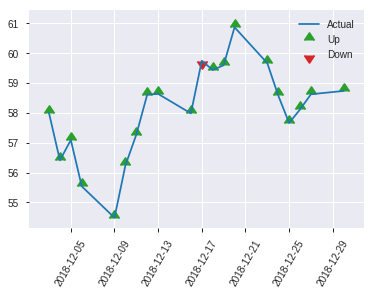


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2515757491588306
RMSE: 0.5015732739678527
LogLoss: 0.6967537747040674
Mean Per-Class Error: 0.41230338289161816
AUC: 0.5700639230050994
pr_auc: 0.5595597058346146
Gini: 0.1401278460101989
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24265198409557343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    114  0.9744   (114.0/117.0)
1      0    119  0        (0.0/119.0)
Total  3    233  0.4831   (114.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.242652     0.676136  232
max f2                       0.242652     0.83921   232
max f0point5                 0.387257     0.598639  153
max accuracy                 0.387257     0.588983  153
max precision                0.69835      1         0
max recall                   0.242652     1         232
max specificity              0.69835      1         0
max absolute_mcc             0.387257     0.184167  153
max min_per_class_accuracy   0.439877     0.538462  118
max mean_per_class_accuracy  0.387257     0.587697  153

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 44.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.672463           1.32213   1.32213            0.666667         0.683277  0.666667                    0.683277            0.0168067       0.0168067                  32.2129    32.2129
    2        0.0211864                   0.662312           1.98319   1.58655            1                0.666537  0.8                         0.676581            0.0168067       0.0336134                  98.3193    58.6555
    3        0.0338983                   0.651152           0.661064  1.2395             0.333333         0.656477  0.625                       0.669042            0.00840336      0.0420168                  -33.8936   23.9496
    4        0.0423729                   0.617723           1.98319   1.38824            1                0.630686  0.7                         0.661371            0.0168067       0.0588235                  98.3193    38.8235
    5        0.0508475                   0.613743           0.991597  1.32213            0.5              0.614315  0.666667                    0.653528            0.00840336      0.0672269                  -0.840336  32.2129
    6        0.101695                    0.586027           1.15686   1.2395             0.583333         0.603068  0.625                       0.628298            0.0588235       0.12605                    15.6863    23.9496
    7        0.152542                    0.570954           1.15686   1.21195            0.583333         0.576859  0.611111                    0.611152            0.0588235       0.184874                   15.6863    21.1951
    8        0.20339                     0.547112           0.826331  1.11555            0.416667         0.555331  0.5625                      0.597197            0.0420168       0.226891                   -17.3669   11.5546
    9        0.300847                    0.509695           0.948484  1.06143            0.478261         0.525097  0.535211                    0.57384             0.092437        0.319328                   -5.15163   6.14274
    10       0.402542                    0.470311           0.991597  1.04379            0.5              0.490135  0.526316                    0.552694            0.10084         0.420168                   -0.840336  4.37859
    11       0.5                         0.440385           1.20716   1.07563            0.608696         0.453996  0.542373                    0.533456            0.117647        0.537815                   20.7161    7.56303
    12       0.601695                    0.416551           1.32213   1.11729            0.666667         0.428424  0.56338                     0.515704            0.134454        0.672269                   32.2129    11.7292
    13       0.699153                    0.379714           0.948484  1.09376            0.478261         0.390774  0.551515                    0.49829             0.092437        0.764706                   -5.15163   9.37611
    14       0.800847                    0.339832           0.991597  1.08079            0.5              0.35843   0.544974                    0.48053             0.10084         0.865546                   -0.840336  8.07879
    15       0.898305                    0.307665           0.344903  1.00095            0.173913         0.323376  0.504717                    0.46348             0.0336134       0.89916                    -65.5097   0.0951324
    16       1                           0.195254           0.991597  1                  0.5              0.273192  0.504237                  

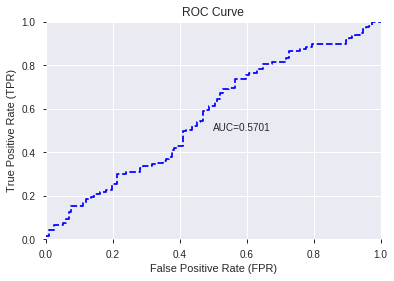

This function is available for GLM models only


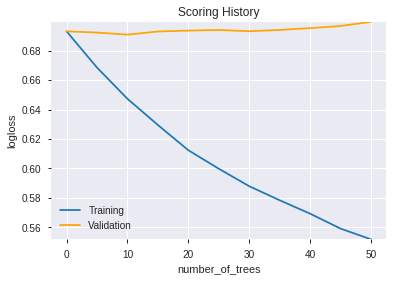

--2019-08-24 00:16:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_001627_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_001627_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_8',
 'TRANGE',
 'BOP',
 'AD',
 'MFI_24',
 'ADXR_14',
 'BETA_24',
 'COS',
 'STOCHF_fastk',
 'CORREL_30',
 'MFI_30',
 'SIN',
 'BETA_20',
 'EXP',
 'BETA_8',
 'ULTOSC',
 'STOCH_slowk',
 'aroondown_30',
 'STOCH_slowd',
 'CORREL_20',
 'aroondown_8',
 'HT_DCPERIOD',
 'dayofweek',
 'MFI_8',
 'aroonup_20',
 'STOCHRSI_fastk',
 'aroonup_8',
 'day',
 'aroonup_30',
 'dayofyear',
 'TANH',
 'weekday_name',
 'aroonup_24',
 'week',
 'CDLLONGLEGGEDDOJI',
 'CDLBELTHOLD',
 'weekofyear',
 'weekday',
 'CDLMATCHINGLOW',
 'days_in_month']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_001752_model_1  0.5  17.415739                   0.5  0.710097  0.504237

variable  relative_importance  scaled_importance    percentage
0                  CDLBELTHOLD         8.231533e-03           1.000000  1.242163e-02
1                          BOP         7.084997e-03           0.860714  1.069148e-02
2               STOCHRSI_fastk         6.024941e-03           0.731934  9.091819e-03
3                      BETA_24         5.881280e-03           0.714482  8.875030e-03
4                           AD         5.765224e-03           0.700383  8.699898e-03
...                        ...                  ...                ...           ...
1031                    MAX_12         3.028759e-06           0.000368  4.570489e-06
1032   BBANDS_lowerband_14_7_2         2.578608e-06           0.000313  3.891198e-06
1033                     EMA_8         2.240103e-06           0.000272  3.380383e-06
1034  BBANDS_middleband_24_6_4         1.260259e-06           0.000153  1.901769e-06
1035   BBANDS_upperband_24_5_4         3.420903e-07           0.000042  5.162247e-07

[1036 rows x 4 columns]

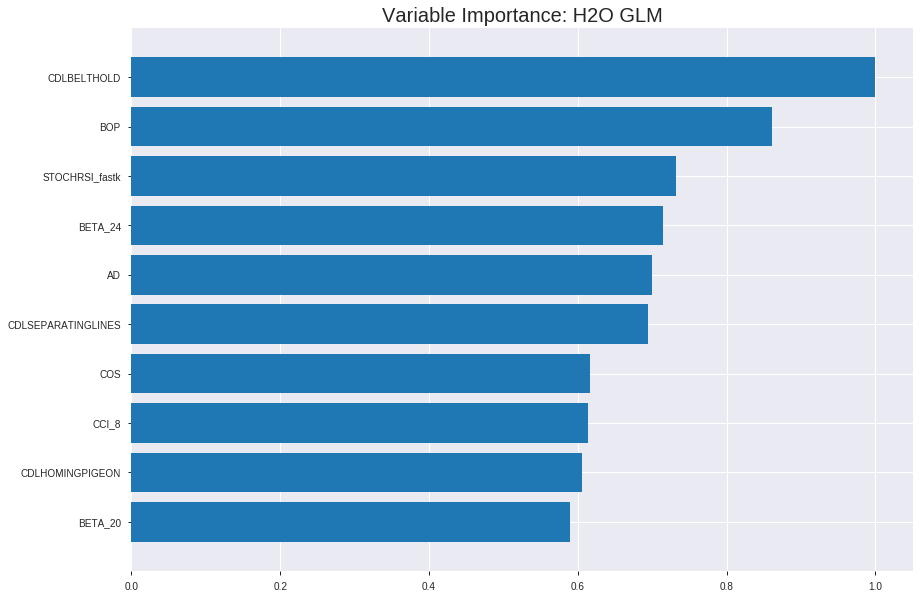

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_001752_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24477405874313138
RMSE: 0.4947464590506246
LogLoss: 0.6826095592932362
Null degrees of freedom: 1650
Residual degrees of freedom: 614
Null deviance: 2277.720891745009
Residual deviance: 2253.976764786266
AIC: 4327.976764786266
AUC: 0.5900517658599426
pr_auc: 0.628861444315338
Gini: 0.18010353171988513
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5033031418615931: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      87   671   0.8852   (671.0/758.0)
1      43   850   0.0482   (43.0/893.0)
Total  130  1521  0.4325   (714.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503303     0.704225  325
max f2                       0.431422     0.855692  394
max f0point5                 0.506812     0.611784  315
max accuracy                 0.519781     0.573592  269
max precision                0.607784     1         0
max recall                   0.431422     1         394
max specificity              0.607784     1         0
max absolute_mcc             0.506812     0.133698  315
max min_per_class_accuracy   0.546413     0.557671  159
max mean_per_class_accuracy  0.542719     0.562169  177

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 54.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.582826           1.63132   1.63132            0.882353         0.591328  0.882353                    0.591328            0.0167973       0.0167973                  63.1315   63.1315
    2        0.0205936                   0.579957           1.52256   1.57694            0.823529         0.581204  0.852941                    0.586266            0.0156775       0.0324748                  52.2561   57.6938
    3        0.0302847                   0.577271           1.27107   1.47906            0.6875           0.577924  0.8                         0.583597            0.012318        0.0447928                  27.1067   47.9059
    4        0.0405815                   0.574841           1.30505   1.43491            0.705882         0.576241  0.776119                    0.58173             0.0134378       0.0582307                  30.5052   43.4908
    5        0.0502726                   0.573403           1.03996   1.35877            0.5625           0.574031  0.73494                     0.580246            0.0100784       0.0683091                  3.99636   35.8774
    6        0.100545                    0.567927           1.31422   1.3365             0.710843         0.570271  0.722892                    0.575259            0.0660694       0.134378                   31.4224   33.6499
    7        0.150212                    0.564439           1.05969   1.24497            0.573171         0.566191  0.673387                    0.57226             0.0526316       0.18701                    5.96919   24.4974
    8        0.200485                    0.561365           1.04692   1.19531            0.566265         0.563051  0.646526                    0.569951            0.0526316       0.239642                   4.69245   19.5312
    9        0.300424                    0.556591           1.04206   1.14433            0.563636         0.55887   0.618952                    0.566265            0.104143        0.343785                   4.20645   14.4333
    10       0.400363                    0.551635           1.09809   1.13279            0.593939         0.554114  0.612708                    0.563232            0.109742        0.453527                   9.80895   13.2789
    11       0.500303                    0.546565           1.00845   1.10795            0.545455         0.549077  0.599274                    0.560404            0.100784        0.554311                   0.844956  10.7952
    12       0.600242                    0.539472           0.96363   1.08392            0.521212         0.54344   0.586276                    0.55758             0.0963046       0.650616                   -3.63704  8.39222
    13       0.700182                    0.531244           0.974835  1.06835            0.527273         0.535699  0.577855                    0.554457            0.0974244       0.74804                    -2.51654  6.83517
    14       0.800121                    0.519792           0.974835  1.05667            0.527273         0.525464  0.571537                    0.550835            0.0974244       0.845465                   -2.51654  5.66709
    15       0.900061                    0.507447           0.907605  1.04012            0.490909         0.513938  0.562584                    0.546738            0.0907055       0.93617                    -9.23954  4.01191
    16       1                           0.241407           0.638685  1                  0.345455         0.488163  0.540884                    0.540884         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3844446933195287
RMSE: 0.6200360419520212
LogLoss: 10.214674894043258
Null degrees of freedom: 471
Residual degrees of freedom: -565
Null deviance: 657.825185254164
Residual deviance: 191584.21305130678
AIC: 193658.21305130678
AUC: 0.5442768650686777
pr_auc: 0.5494971808020985
Gini: 0.08855373013735535
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.664781  184
max f2                       0            0.832153  184
max f0point5                 0            0.553462  184
max accuracy                 0.497815     0.550847  124
max precision                0.552402     1         0
max recall                   0            1         184
max specificity              0.552402     1         0
max absolute_mcc             0.497815     0.11298   124
max min_per_class_accuracy   1.02316e-14  0.425532  183
max mean_per_class_accuracy  0.491172     0.549942  134

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 19.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.540788           1.20511   1.20511            0.6              0.545751   0.6                         0.545751            0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.537743           1.60681   1.40596            0.8              0.538658   0.7                         0.542205            0.0170213       0.0297872                  60.6809   40.5957
    3        0.0317797                   0.535242           1.20511   1.33901            0.6              0.536785   0.666667                    0.540398            0.012766        0.0425532                  20.5106   33.9007
    4        0.0402542                   0.533281           1.00426   1.26853            0.5              0.534078   0.631579                    0.539068            0.00851064      0.0510638                  0.425532  26.8533
    5        0.0508475                   0.532689           1.60681   1.33901            0.8              0.532987   0.666667                    0.537801            0.0170213       0.0680851                  60.6809   33.9007
    6        0.101695                    0.523975           1.00426   1.17163            0.5              0.528287   0.583333                    0.533044            0.0510638       0.119149                   0.425532  17.1631
    7        0.150424                    0.518587           1.04792   1.13156            0.521739         0.52152    0.56338                     0.529311            0.0510638       0.170213                   4.79186   13.1555
    8        0.201271                    0.51227            1.25532   1.16282            0.625            0.515684   0.578947                    0.525868            0.0638298       0.234043                   25.5319   16.2822
    9        0.300847                    0.487839           1.15383   1.15984            0.574468         0.501593   0.577465                    0.517834            0.114894        0.348936                   15.3825   15.9844
    10       1                           0                  0.931219  1                  0.463636         0.0578046  0.497881                    0.196203            0.651064        1                          -6.87814  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:17:56  0.000 sec   2            4.1       1037          1.36522           405.899
    2019-08-24 00:17:57  1.820 sec   4            3         1037          1.36183           405.924
    2019-08-24 00:17:59  3.639 sec   6            2.2       1037          1.35781           405.947
    2019-08-24 00:18:01  5.512 sec   8            1.6       1037          1.35312           405.971
    2019-08-24 00:18:03  7.345 sec   10           1.1       1037          1.34779           405.991

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5042372881355932)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 17.41573894489139)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.710096675203872)

('mse', 0.5042372881355932)

glm prediction progress: |████████████████████████████████████████████████| 100%


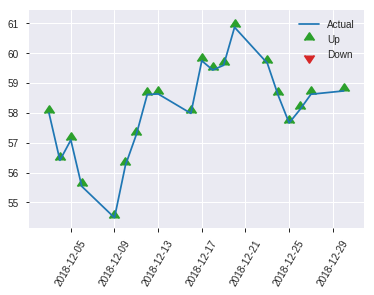


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5042372881355932
RMSE: 0.710096675203872
LogLoss: 17.41573894489139
Null degrees of freedom: 235
Residual degrees of freedom: -801
Null deviance: 328.4208830413794
Residual deviance: 168598.34761067876
AIC: 170672.34761067876
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.670423  0
max f2                       0            0.835674  0
max f0point5                 0            0.559737  0
max accuracy                 0            0.504237  0
max precision                0            0.504237  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.504237         0        0.504237                    0                   1               1                          0       0

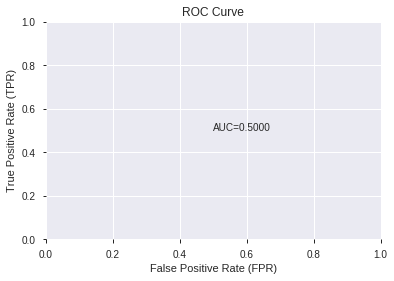

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


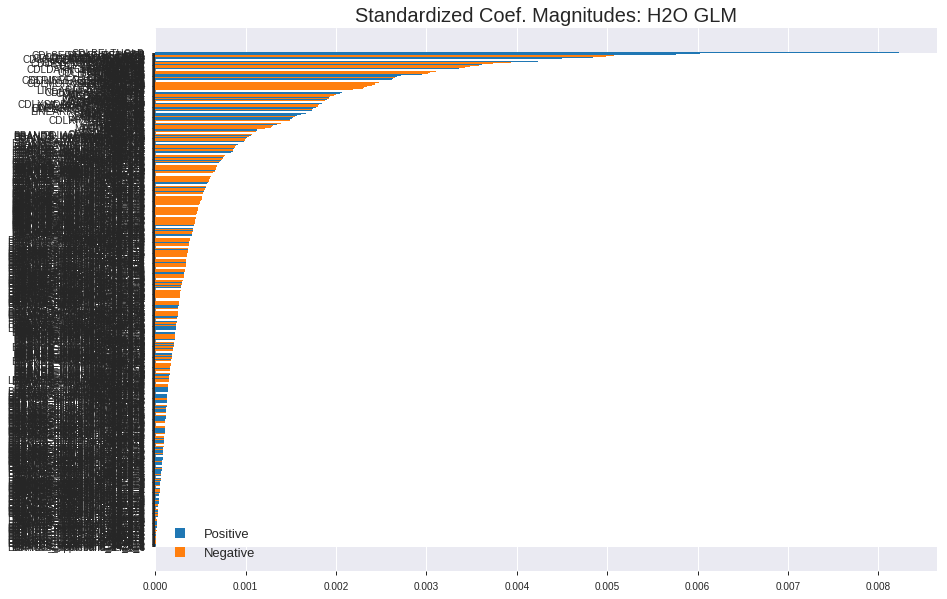

'log_likelihood'
--2019-08-24 00:18:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_001752_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_001752_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

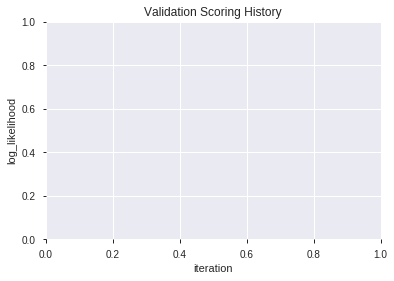

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_001925  0.582561  0.712213              0.500000  0.508323  0.258392
1               XGBoost_2_AutoML_20190824_001925  0.577174  0.690014              0.465596  0.498391  0.248394
2  XGBoost_grid_1_AutoML_20190824_001925_model_3  0.571213  0.708440              0.469870  0.506887  0.256934
3  XGBoost_grid_1_AutoML_20190824_001925_model_6  0.567981  0.724305              0.482762  0.514024  0.264221
4  XGBoost_grid_1_AutoML_20190824_001925_model_1  0.560799  0.731827              0.447928  0.516756  0.267036
5  XGBoost_grid_1_AutoML_20190824_001925_model_2  0.559290  0.690829              0.491309  0.498787  0.248788
6               XGBoost_1_AutoML_20190824_001925  0.555125  0.705350              0.500000  0.505211  0.255239
7  XGBoost_grid_1_AutoML_20190824_001925_model_7  0.544997  0.735197              0.500000  0.517852  0.268171
8  XGBoost_grid_1_AutoML_20190824_001925_model_4  0.538677  0.692343              0.491453  0.499579  0.249579
9  XGBoost_grid_1_AutoML_20190824_001925_model_5  0.537959  0.764871              0.487179  0.530545  0.281478

variable  relative_importance  scaled_importance  percentage
0                   CORREL_8           217.112396           1.000000    0.037901
1                        BOP           145.490707           0.670117    0.025398
2                   STDDEV_8           117.768745           0.542432    0.020559
3                     Volume           102.073586           0.470142    0.017819
4                     MFI_24            98.646629           0.454357    0.017220
..                       ...                  ...                ...         ...
296                  KAMA_30             0.515125           0.002373    0.000090
297  BBANDS_upperband_24_1_4             0.513648           0.002366    0.000090
298   BBANDS_lowerband_8_0_2             0.267888           0.001234    0.000047
299              MIDPRICE_14             0.148647           0.000685    0.000026
300  BBANDS_upperband_24_5_4             0.008625           0.000040    0.000002

[301 rows x 4 columns]

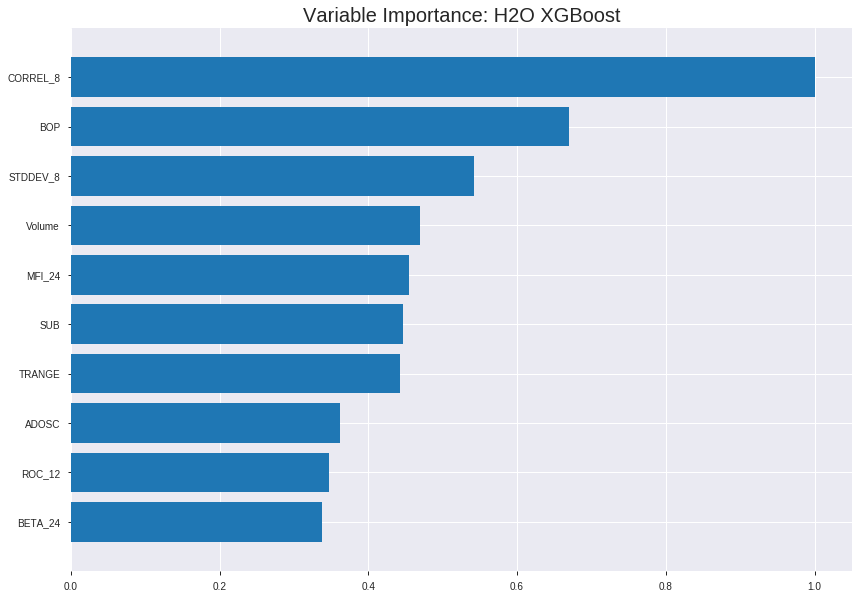

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_001925


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16944291287456456
RMSE: 0.41163444082652334
LogLoss: 0.5262621830520455
Mean Per-Class Error: 0.10989682284079927
AUC: 0.9548023767384554
pr_auc: 0.9599394758285786
Gini: 0.9096047534769107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.523373544216156: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      656  102  0.1346   (102.0/758.0)
1      77   816  0.0862   (77.0/893.0)
Total  733  918  0.1084   (179.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523374     0.90116   212
max f2                       0.472457     0.931299  256
max f0point5                 0.559643     0.911256  182
max accuracy                 0.526272     0.891581  209
max precision                0.835084     1         0
max recall                   0.391157     1         323
max specificity              0.835084     1         0
max absolute_mcc             0.523374     0.781522  212
max min_per_class_accuracy   0.534894     0.888018  202
max mean_per_class_accuracy  0.526272     0.890103  209

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 53.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.75803            1.84882   1.84882            1                0.776468  1                           0.776468            0.019037        0.019037                   84.8824   84.8824
    2        0.0205936                   0.749113           1.84882   1.84882            1                0.753583  1                           0.765025            0.019037        0.0380739                  84.8824   84.8824
    3        0.0302847                   0.740859           1.84882   1.84882            1                0.744975  1                           0.758609            0.0179171       0.055991                   84.8824   84.8824
    4        0.0405815                   0.72979            1.84882   1.84882            1                0.734812  1                           0.752571            0.019037        0.075028                   84.8824   84.8824
    5        0.0502726                   0.719415           1.84882   1.84882            1                0.724259  1                           0.747113            0.0179171       0.0929451                  84.8824   84.8824
    6        0.100545                    0.691309           1.84882   1.84882            1                0.703517  1                           0.725315            0.0929451       0.18589                    84.8824   84.8824
    7        0.150212                    0.672023           1.84882   1.84882            1                0.681014  1                           0.710667            0.0918253       0.277716                   84.8824   84.8824
    8        0.200485                    0.653252           1.82655   1.84324            0.987952         0.662449  0.996979                    0.698576            0.0918253       0.369541                   82.6549   84.3239
    9        0.300424                    0.61598            1.71436   1.80037            0.927273         0.63391   0.97379                     0.677064            0.171333        0.540873                   71.4364   80.0367
    10       0.400363                    0.583477           1.68075   1.77051            0.909091         0.598969  0.95764                     0.65757             0.167973        0.708847                   68.0749   77.0508
    11       0.500303                    0.545857           1.45665   1.70781            0.787879         0.565337  0.923729                    0.639146            0.145577        0.854423                   45.6649   70.7812
    12       0.600242                    0.503587           0.8964    1.57271            0.484848         0.525308  0.850656                    0.620192            0.0895857       0.944009                   -10.36    57.2713
    13       0.700182                    0.462684           0.369765  1.40101            0.2              0.483439  0.757785                    0.600673            0.0369541       0.980963                   -63.0235  40.1012
    14       0.800121                    0.419795           0.13446   1.24281            0.0727273        0.441872  0.672218                    0.580838            0.0134378       0.994401                   -86.554   24.2813
    15       0.900061                    0.372019           0.056025  1.11104            0.030303         0.395525  0.600942                    0.560261            0.0055991       1                          -94.3975  11.1036
    16       1                           0.146889           0         1                  0                0.323448  0.540884                    0.536594         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2623055552139101
RMSE: 0.5121577444634711
LogLoss: 0.7203744869774132
Mean Per-Class Error: 0.454205943082862
AUC: 0.5378938863452734
pr_auc: 0.5212587870832283
Gini: 0.0757877726905467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2104119211435318: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    229  0.9662   (229.0/237.0)
1      3    232  0.0128   (3.0/235.0)
Total  11   461  0.4915   (232.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.210412     0.666667   389
max f2                       0.175899     0.832743   398
max f0point5                 0.247277     0.561048   375
max accuracy                 0.449611     0.54661    129
max precision                0.683078     1          0
max recall                   0.175899     1          398
max specificity              0.683078     1          0
max absolute_mcc             0.449611     0.0996118  129
max min_per_class_accuracy   0.398847     0.518987   201
max mean_per_class_accuracy  0.447864     0.545794   131

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 39.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.623452           1.20511   1.20511            0.6              0.654345  0.6                         0.654345            0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.588119           0.803404  1.00426            0.4              0.607585  0.5                         0.630965            0.00851064      0.0212766                  -19.6596  0.425532
    3        0.0317797                   0.576277           0.803404  0.937305           0.4              0.581302  0.466667                    0.614411            0.00851064      0.0297872                  -19.6596  -6.2695
    4        0.0402542                   0.564823           1.00426   0.9514             0.5              0.569648  0.473684                    0.604987            0.00851064      0.0382979                  0.425532  -4.86002
    5        0.0508475                   0.55904            0.803404  0.920567           0.4              0.562693  0.458333                    0.596176            0.00851064      0.0468085                  -19.6596  -7.94326
    6        0.101695                    0.5191             1.08794   1.00426            0.541667         0.537829  0.5                         0.567002            0.0553191       0.102128                   8.79433   0.425532
    7        0.150424                    0.496927           1.22257   1.07498            0.608696         0.508996  0.535211                    0.548211            0.0595745       0.161702                   22.2572   7.49775
    8        0.201271                    0.478831           1.17163   1.0994             0.583333         0.486638  0.547368                    0.532656            0.0595745       0.221277                   17.1631   9.93953
    9        0.300847                    0.449616           1.23929   1.1457             0.617021         0.464293  0.570423                    0.510029            0.123404        0.344681                   23.9294   14.57
    10       0.400424                    0.424714           0.683748  1.03082            0.340426         0.436302  0.513228                    0.491694            0.0680851       0.412766                   -31.6252  3.08229
    11       0.5                         0.398146           1.06836   1.0383             0.531915         0.410101  0.516949                    0.475445            0.106383        0.519149                   6.83567   3.82979
    12       0.599576                    0.375317           0.982888  1.0291             0.489362         0.385731  0.512367                    0.460545            0.0978723       0.617021                   -1.71118  2.90956
    13       0.699153                    0.353343           1.06836   1.03469            0.531915         0.366554  0.515152                    0.447159            0.106383        0.723404                   6.83567   3.46873
    14       0.798729                    0.313056           0.89742   1.01757            0.446809         0.337424  0.506631                    0.433478            0.0893617       0.812766                   -10.258   1.75744
    15       0.898305                    0.276474           1.02562   1.01847            0.510638         0.29521   0.507075                    0.418151            0.102128        0.914894                   2.56225   1.84665
    16       1                           0.165365           0.836879  1                  0.416667         0.238033  0.497881                    0.399834       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:19:36  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.459116                         0.5                0.693147              0.5               0                    1                  0.502119
    2019-08-24 00:19:36  0.599 sec   5                  0.486652         0.666751            0.797531        0.811716           1.84882          0.283465                         0.499285           0.691719              0.546647          0.538836             1.60681            0.5
    2019-08-24 00:19:37  0.784 sec   10                 0.475221         0.64453             0.848279        0.861455           1.84882          0.254391                         0.499091           0.691344              0.551207          0.551002             1.20511            0.495763
    2019-08-24 00:19:37  0.969 sec   15                 0.46567          0.626173            0.867352        0.873684           1.84882          0.213204                         0.499854           0.692902              0.54899           0.545881             1.20511            0.502119
    2019-08-24 00:19:37  1.204 sec   20                 0.45575          0.607388            0.894698        0.898187           1.84882          0.175651                         0.502191           0.697764              0.545722          0.541898             1.60681            0.480932
    2019-08-24 00:19:37  1.382 sec   25                 0.448084         0.592963            0.911893        0.91541            1.84882          0.162326                         0.504566           0.70282               0.544681          0.533947             1.60681            0.502119
    2019-08-24 00:19:37  1.548 sec   30                 0.441673         0.580978            0.919788        0.922824           1.84882          0.155663                         0.505783           0.705563              0.536556          0.530344             1.20511            0.480932
    2019-08-24 00:19:38  1.743 sec   35                 0.434223         0.56719             0.930523        0.933884           1.84882          0.136281                         0.506878           0.708062              0.540273          0.53284              1.60681            0.483051
    2019-08-24 00:19:38  1.927 sec   40                 0.426501         0.553046            0.941107        0.945679           1.84882          0.124773                         0.508128           0.710904              0.53995           0.532422             1.60681            0.483051
    2019-08-24 00:19:38  2.122 sec   45                 0.417854         0.537413            0.949553        0.954179           1.84882          0.112053                         0.511454           0.718396              0.540255          0.519726             1.20511            0.485169
    2019-08-24 00:19:38  2.315 sec   50                 0.411634         0.526262            0.954802        0.959939           1.84882          0.108419                         0.512158           0.720374              0.537894          0.521259             1.20511            0.491525

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
CORREL_8                 217.11239624023438     1.0                    0.03790076080682623
BOP                      145.49070739746094     0.6701169989228796     0.02539794408876429
STDDEV_8                 117.76874542236328     0.5424321570844459     0.020558591439588377
Volume                   102.0735855102539      0.4701416744408722     0.017818727148304264
MFI_24                   98.6466293334961       0.4543574251943856     0.017220492093097853
---                      ---                    ---                    ---
KAMA_30                  0.5151252746582031     0.002372620281378214   8.992411376994044e-05
BBANDS_upperband_24_1_4  0.5136480331420898     0.002365816240974741   8.966623546208844e-05
BBANDS_lowerband_8_0_2   0.26788806915283203    0.0012338681429153152  4.6764541351796244e-05
MIDPRICE_14              0.14864730834960938    0.0006846560165322457  2.594898391754311e-05
BBANDS_upperband_24_5_4  0.008625030517578125   3.97261080755359e-05   1.5056497199570141e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6016949152542372)

('F1', 0.6704225352112676)

('auc', 0.5825612296200532)

('logloss', 0.7122130638937835)

('mean_per_class_error', 0.39854916325504564)

('rmse', 0.5083230470213262)

('mse', 0.25839232013304547)

xgboost prediction progress: |████████████████████████████████████████████| 100%


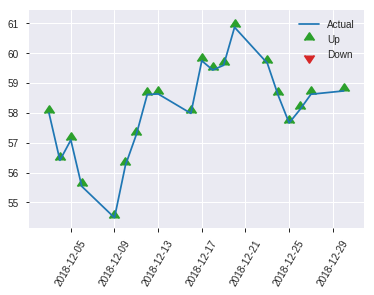


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25839232013304547
RMSE: 0.5083230470213262
LogLoss: 0.7122130638937835
Mean Per-Class Error: 0.39854916325504564
AUC: 0.5825612296200532
pr_auc: 0.5977192864323835
Gini: 0.16512245924010638
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2207333743572235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.220733     0.670423  235
max f2                       0.220733     0.835674  235
max f0point5                 0.389256     0.605816  124
max accuracy                 0.389256     0.601695  124
max precision                0.51395      0.9       9
max recall                   0.220733     1         235
max specificity              0.590837     0.991453  0
max absolute_mcc             0.499254     0.210704  16
max min_per_class_accuracy   0.392349     0.581197  118
max mean_per_class_accuracy  0.389256     0.601451  124

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 39.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.547683           1.32213   1.32213            0.666667         0.568488  0.666667                    0.568488            0.0168067       0.0168067                  32.2129    32.2129
    2        0.0211864                   0.526501           1.98319   1.58655            1                0.539355  0.8                         0.556835            0.0168067       0.0336134                  98.3193    58.6555
    3        0.0338983                   0.522277           1.98319   1.73529            1                0.523569  0.875                       0.54436             0.0252101       0.0588235                  98.3193    73.5294
    4        0.0423729                   0.512858           1.98319   1.78487            1                0.513967  0.9                         0.538282            0.0168067       0.0756303                  98.3193    78.4874
    5        0.0508475                   0.505067           0.991597  1.65266            0.5              0.508663  0.833333                    0.533345            0.00840336      0.0840336                  -0.840336  65.2661
    6        0.101695                    0.486079           1.48739   1.57003            0.75             0.496332  0.791667                    0.514839            0.0756303       0.159664                   48.7395    57.0028
    7        0.152542                    0.469342           0.661064  1.26704            0.333333         0.47801   0.638889                    0.502563            0.0336134       0.193277                   -33.8936   26.704
    8        0.20339                     0.457615           0.991597  1.19818            0.5              0.462213  0.604167                    0.492475            0.0504202       0.243697                   -0.840336  19.8179
    9        0.300847                    0.432933           1.03471   1.14522            0.521739         0.445617  0.577465                    0.477296            0.10084         0.344538                   3.47095    14.5224
    10       0.402542                    0.410356           1.2395    1.16904            0.625            0.421458  0.589474                    0.463189            0.12605         0.470588                   23.9496    16.904
    11       0.5                         0.392477           1.12094   1.15966            0.565217         0.400607  0.584746                    0.450991            0.109244        0.579832                   12.0935    15.9664
    12       0.601695                    0.376116           0.908964  1.11729            0.458333         0.384901  0.56338                     0.439821            0.092437        0.672269                   -9.10364   11.7292
    13       0.699153                    0.357331           0.603581  1.04568            0.304348         0.366465  0.527273                    0.429596            0.0588235       0.731092                   -39.6419   4.56837
    14       0.800847                    0.340332           0.826331  1.01783            0.416667         0.349494  0.513228                    0.419424            0.0840336       0.815126                   -17.3669   1.78294
    15       0.898305                    0.285418           0.862258  1.00095            0.434783         0.316639  0.504717                    0.408273            0.0840336       0.89916                    -13.7742   0.0951324
    16       1                           0.220733           0.991597  1                  0.5              0.255956  0.504237                    

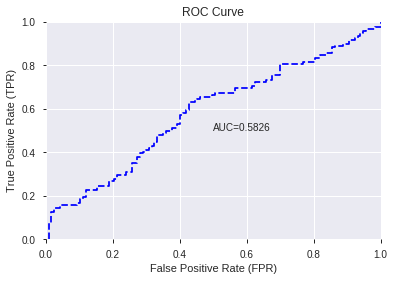

This function is available for GLM models only


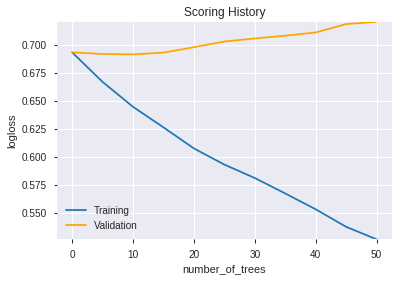

--2019-08-24 00:20:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_001925',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_001925',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b870',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_002111_model_8  0.5   0.693550                   0.5  0.500201  0.250201
1  DeepLearning_grid_1_AutoML_20190824_002111_model_4  0.5  17.415739                   0.5  0.710097  0.504237
2  DeepLearning_grid_1_AutoML_20190824_002111_model_9  0.5   0.697147                   0.5  0.501985  0.251989
3  DeepLearning_grid_1_AutoML_20190824_002111_model_1  0.5  17.415739                   0.5  0.710097  0.504237
4  DeepLearning_grid_1_AutoML_20190824_002111_model_7  0.5  17.415739                   0.5  0.710097  0.504237
5               DeepLearning_1_AutoML_20190824_002111  0.5  17.415739                   0.5  0.710097  0.504237
6  DeepLearning_grid_1_AutoML_20190824_002111_model_2  0.5  17.415739                   0.5  0.710097  0.504237
7  DeepLearning_grid_1_AutoML_20190824_002111_model_5  0.5  17.415739                   0.5  0.710097  0.504237
8  DeepLearning_grid_1_AutoML_20190824_002111_model_6  0.5  17.415739                   0.5  0.710097  0.504237
9  DeepLearning_grid_1_AutoML_20190824_002111_model_3  0.5  17.415739                   0.5  0.710097  0.504237

variable  relative_importance  scaled_importance  percentage
0              BETA_24             1.000000           1.000000    0.023922
1                  COS             0.994858           0.994858    0.023799
2          CDLBELTHOLD             0.964732           0.964732    0.023078
3                   AD             0.955398           0.955398    0.022855
4       STOCHRSI_fastk             0.931893           0.931893    0.022293
5         HT_TRENDMODE             0.925639           0.925639    0.022143
6                  BOP             0.902586           0.902586    0.021592
7                  SIN             0.901451           0.901451    0.021565
8              BETA_20             0.891780           0.891780    0.021333
9             CORREL_8             0.881931           0.881931    0.021098
10                 day             0.881541           0.881541    0.021088
11         aroondown_8             0.878739           0.878739    0.021021
12        weekday_name             0.866981           0.866981    0.020740
13             ADXR_14             0.859282           0.859282    0.020556
14          aroonup_30             0.856916           0.856916    0.020499
15          aroonup_24             0.854630           0.854630    0.020445
16           CORREL_20             0.853683           0.853683    0.020422
17        STOCHF_fastk             0.848816           0.848816    0.020305
18              MFI_24             0.846324           0.846324    0.020246
19          aroonup_20             0.844147           0.844147    0.020194
20               month             0.834782           0.834782    0.019970
21              ULTOSC             0.832526           0.832526    0.019916
22       days_in_month             0.832129           0.832129    0.019906
23      CDLSPINNINGTOP             0.829555           0.829555    0.019845
24               MFI_8             0.827494           0.827494    0.019795
25         HT_DCPERIOD             0.824046           0.824046    0.019713
26           dayofyear             0.820595           0.820595    0.019630
27           dayofweek             0.818577           0.818577    0.019582
28   CDLLONGLEGGEDDOJI             0.816335           0.816335    0.019528
29      CDLMATCHINGLOW             0.812736           0.812736    0.019442
30              MFI_30             0.810977           0.810977    0.019400
31      CDLMORNINGSTAR             0.808836           0.808836    0.019349
32                week             0.808656           0.808656    0.019345
33        aroondown_30             0.807665           0.807665    0.019321
34             weekday             0.806457           0.806457    0.019292
35         STOCH_slowk             0.806300           0.806300    0.019288
36         STOCH_slowd             0.803486           0.803486    0.019221
37           CORREL_30             0.801500           0.801500    0.019174
38           aroonup_8             0.797515           0.797515    0.019078
39                TANH             0.790073           0.790073    0.018900
40         CDLPIERCING             0.782822           0.782822    0.018727
41          weekofyear             0.775123           0.775123    0.018543
42     CDLADVANCEBLOCK             0.773308           0.773308    0.018499
43                 EXP             0.761068           0.761068    0.018206
44             quarter             0.757952           0.757952    0.018132
45  CDLMORNINGDOJISTAR             0.756098           0.756098    0.018087
46        CDLTHRUSTING             0.752272           0.752272    0.017996
47   CDLDARKCLOUDCOVER             0.749128           0.749128    0.017921
48              TRANGE             0.731556           0.731556    0.017500
49              BETA_8             0.731424           0.731424    0.017497

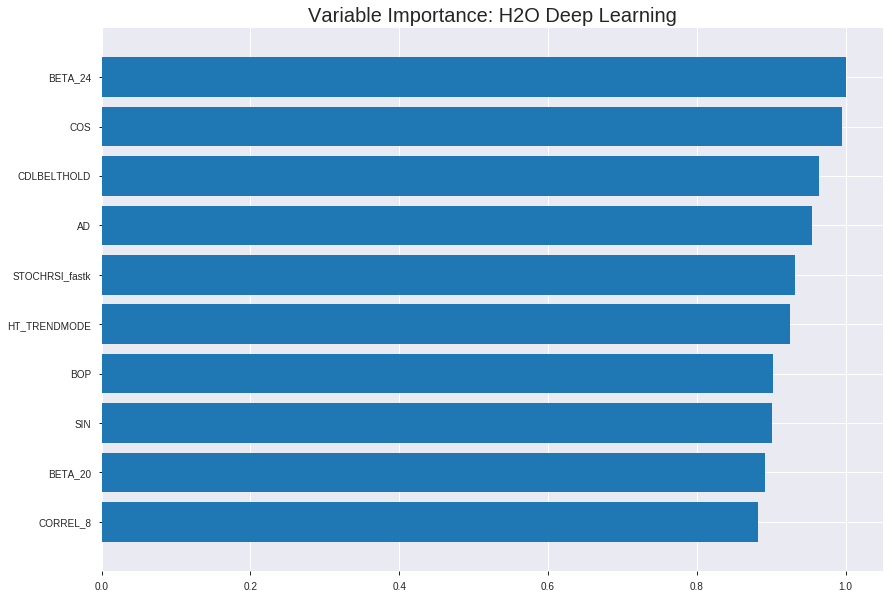

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_002111_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2460367358942276
RMSE: 0.4960209026787355
LogLoss: 0.6851977797548078
Mean Per-Class Error: 0.42407821608700913
AUC: 0.6009035388110989
pr_auc: 0.6385850972494208
Gini: 0.20180707762219785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4865716110549154: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      26   732   0.9657   (732.0/758.0)
1      11   882   0.0123   (11.0/893.0)
Total  37   1614  0.45     (743.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486572     0.70363   380
max f2                       0.473231     0.854873  399
max f0point5                 0.500931     0.6178    314
max accuracy                 0.500931     0.583283  314
max precision                0.589547     1         0
max recall                   0.473231     1         399
max specificity              0.589547     1         0
max absolute_mcc             0.513619     0.152153  232
max min_per_class_accuracy   0.515789     0.569989  216
max mean_per_class_accuracy  0.513619     0.575922  232

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 51.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102968                   0.56843            1.63132   1.63132            0.882353         0.577533  0.882353                    0.577533            0.0167973       0.0167973                  63.1315    63.1315
    2        0.0205936                   0.559089           1.52256   1.57694            0.823529         0.562493  0.852941                    0.570013            0.0156775       0.0324748                  52.2561    57.6938
    3        0.0302847                   0.553333           1.50217   1.55301            0.8125           0.556144  0.84                        0.565575            0.0145577       0.0470325                  50.217     55.3012
    4        0.0405815                   0.550189           1.52256   1.54529            0.823529         0.551408  0.835821                    0.561981            0.0156775       0.06271                    52.2561    54.5286
    5        0.0502726                   0.54693            1.15552   1.47015            0.625            0.548847  0.795181                    0.559449            0.0111982       0.0739082                  15.5515    47.0149
    6        0.100545                    0.537161           1.18057   1.32536            0.638554         0.541392  0.716867                    0.55042             0.0593505       0.133259                   18.0574    32.5362
    7        0.150212                    0.531338           1.19497   1.28225            0.646341         0.534002  0.693548                    0.544992            0.0593505       0.192609                   19.4972    28.2249
    8        0.200485                    0.527677           1.00237   1.21207            0.542169         0.52941   0.655589                    0.541084            0.0503919       0.243001                   0.237456   21.2069
    9        0.300424                    0.523043           1.08688   1.17042            0.587879         0.52513   0.633065                    0.535777            0.108623        0.351624                   8.68845    17.0425
    10       0.400363                    0.519489           1.06447   1.14398            0.575758         0.521183  0.618759                    0.532134            0.106383        0.458007                   6.44745    14.3977
    11       0.500303                    0.515745           1.1205    1.13929            0.606061         0.51774   0.616223                    0.529259            0.111982        0.569989                   12.05      13.9288
    12       0.600242                    0.511253           0.952425  1.10818            0.515152         0.513542  0.599395                    0.526642            0.0951848       0.665174                   -4.75754   10.8175
    13       0.700182                    0.506832           0.87399   1.07475            0.472727         0.509132  0.581315                    0.524143            0.087346        0.75252                    -12.601    7.4749
    14       0.800121                    0.502162           0.997245  1.06507            0.539394         0.504624  0.576079                    0.521705            0.0996641       0.852184                   -0.275544  6.50683
    15       0.900061                    0.495807           0.82917   1.03887            0.448485         0.499071  0.561911                    0.519192            0.0828667       0.93505                    -17.083    3.8875
    16       1                           0.473231           0.64989   1                  0.351515         0.489614  0.540884                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25033043113316544
RMSE: 0.5003303220205282
LogLoss: 0.6938059144778191
Mean Per-Class Error: 0.4611634796660382
AUC: 0.5248765598348146
pr_auc: 0.5356641926753855
Gini: 0.04975311966962925
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4890729835108224: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489073     0.664781  178
max f2                       0.489073     0.832153  178
max f0point5                 0.496348     0.555026  172
max accuracy                 0.520233     0.540254  77
max precision                0.575557     1         0
max recall                   0.489073     1         178
max specificity              0.575557     1         0
max absolute_mcc             0.520233     0.104564  77
max min_per_class_accuracy   0.519287     0.212766  82
max mean_per_class_accuracy  0.520233     0.538837  77

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 51.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.551619           1.60681   1.60681            0.8              0.562396  0.8                         0.562396            0.0170213       0.0170213                  60.6809   60.6809
    2        0.0211864                   0.542323           0.803404  1.20511            0.4              0.546981  0.6                         0.554688            0.00851064      0.0255319                  -19.6596  20.5106
    3        0.0317797                   0.538046           0         0.803404           0                0.539682  0.4                         0.549686            0               0.0255319                  -100      -19.6596
    4        0.0402542                   0.535737           1.50638   0.9514             0.75             0.537304  0.473684                    0.547079            0.012766        0.0382979                  50.6383   -4.86002
    5        0.0508475                   0.532282           1.20511   1.00426            0.6              0.534137  0.5                         0.544383            0.012766        0.0510638                  20.5106   0.425532
    6        0.101695                    0.525908           0.920567  0.962411           0.458333         0.528155  0.479167                    0.536269            0.0468085       0.0978723                  -7.94326  -3.75887
    7        0.150424                    0.520989           1.57188   1.15984            0.782609         0.523526  0.577465                    0.532141            0.0765957       0.174468                   57.1878   15.9844
    8        0.798729                    0.519044           0.964873  1.00159            0.480392         0.519092  0.498674                    0.521549            0.625532        0.8                        -3.51272  0.159151
    9        0.798729                    0.518991           0         1.00159            0                0         0.498674                    0.521549            0               0.8                        -100      0.159151
    10       0.898305                    0.508929           0.982888  0.999518           0.489362         0.514595  0.497642                    0.520779            0.0978723       0.897872                   -1.71118  -0.0481734
    11       1                           0.489073           1.00426   1                  0.5              0.501202  0.497881                    0.518788            0.102128        1                          0.425532  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:26:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:26:32  1 min  1.577 sec  538 obs/sec       0.651726  1             1076       0.507103         0.708129            -0.0355359     0.49926         0.543386           0.978789         0.459116                         0.647876           11.462                -0.679004        0.473391          0.20937              0.941489           0.491525
    2019-08-24 00:26:44  1 min 13.145 sec  898 obs/sec       6.87765   10            11355      0.496021         0.685198            0.00922865     0.600904        0.638585           1.63132          0.45003                          0.50033            0.693806              -0.0013397       0.524877          0.535664             1.60681            0.502119
    2019-08-24 00:26:53  1 min 22.937 sec  1006 obs/sec      13.109    19            21643      0.491381         0.675341            0.027679       0.624803        0.661203           1.63132          0.436099                         0.621855           10.1718               -0.546841        0.532085          0.522901             0.803404           0.502119
    2019-08-24 00:27:03  1 min 32.405 sec  1097 obs/sec      19.98     29            32987      0.476878         0.644058            0.0842282      0.655145        0.691893           1.84882          0.403998                         0.623938           10.2482               -0.55722         0.537696          0.542543             1.20511            0.502119
    2019-08-24 00:27:12  1 min 41.994 sec  1180 obs/sec      27.6893   40            45715      0.4792           0.64828             0.0752876      0.660422        0.708833           1.84882          0.38825                          0.623372           10.2585               -0.554398        0.533279          0.530306             1.60681            0.502119
    2019-08-24 00:27:22  1 min 51.285 sec  1234 obs/sec      35.2368   51            58176      0.459374         0.601381            0.150221       0.69704         0.743966           1.84882          0.370079                         0.63308            10.3992               -0.603191        0.544483          0.556137             1.60681            0.502119
    2019-08-24 00:27:31  2 min  0.950 sec  1266 obs/sec      42.8086   62            70677      0.456019         0.594902            0.162589       0.723682        0.778553           1.84882          0.345245                         0.630617           10.4133               -0.590741        0.541718          0.55172              1.20511            0.502119
    2019-08-24 00:27:32  2 min  1.923 sec  1265 obs/sec      42.8086   62            70677      0.496021         0.685198            0.00922865     0.600904        0.638585           1.63132          0.45003                          0.50033            0.693806              -0.0013397       0.524877          0.535664             1.60681            0.502119

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BETA_24             1.0                    1.0                  0.023922116352476236
COS                 0.99485844373703       0.99485844373703     0.023799119445320666
CDLBELTHOLD         0.9647319912910461     0.9647319912910461   0.023078430944620497
AD                  0.9553982019424438     0.9553982019424438   0.022855146949813727
STOCHRSI_fastk      0.9318934082984924     0.9318934082984924   0.022292862541422178
---                 ---                    ---                  ---
CDLMORNINGDOJISTAR  0.7560982704162598     0.7560982704162598   0.018087470798803806
CDLTHRUSTING        0.7522724866867065     0.7522724866867065   0.017995949955286025
CDLDARKCLOUDCOVER   0.749127984046936      0.749127984046936    0.017920726797266764
TRANGE              0.7315555810928345     0.7315555810928345   0.01750035772920615
BETA_8              0.7314244508743286     0.7314244508743286   0.01749722081686173


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5042372881355932)

('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 0.6935501244798956)

('mean_per_class_error', 0.5)

('rmse', 0.5002012462471365)

('mse', 0.25020128674718844)

deeplearning prediction progress: |███████████████████████████████████████| 100%


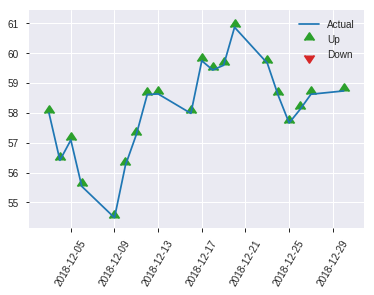


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25020128674718844
RMSE: 0.5002012462471365
LogLoss: 0.6935501244798956
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5190440892057818: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519044     0.670423  0
max f2                       0.519044     0.835674  0
max f0point5                 0.519044     0.559737  0
max accuracy                 0.519044     0.504237  0
max precision                0.519044     0.504237  0
max recall                   0.519044     1         0
max specificity              0.519044     0         0
max absolute_mcc             0.519044     0         0
max min_per_class_accuracy   0.519044     0         0
max mean_per_class_accuracy  0.519044     0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 51.90 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.519044           1       1                  0.504237         0.519044  0.504237                    0.519044            1               1                          0       0

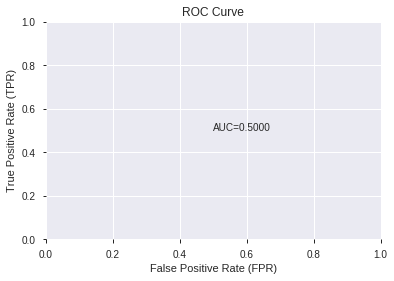

This function is available for GLM models only


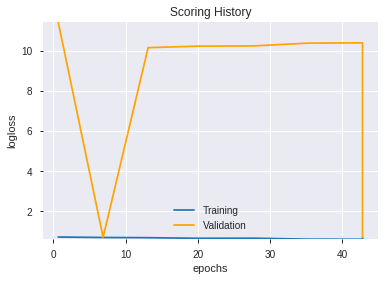

--2019-08-24 00:28:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.168
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.168|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_002111_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_002111_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BETA_24',
 'COS',
 'CDLBELTHOLD',
 'AD',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'BOP',
 'SIN',
 'BETA_20',
 'CORREL_8',
 'day',
 'aroondown_8',
 'weekday_name',
 'ADXR_14',
 'aroonup_30',
 'aroonup_24',
 'CORREL_20',
 'STOCHF_fastk',
 'MFI_24',
 'aroonup_20',
 'month',
 'ULTOSC',
 'days_in_month',
 'CDLSPINNINGTOP',
 'MFI_8',
 'HT_DCPERIOD',
 'dayofyear',
 'dayofweek',
 'CDLLONGLEGGEDDOJI',
 'CDLMATCHINGLOW',
 'MFI_30',
 'CDLMORNINGSTAR',
 'week',
 'aroondown_30',
 'weekday',
 'STOCH_slowk',
 'STOCH_slowd',
 'CORREL_30',
 'aroonup_8',
 'TANH',
 'CDLPIERCING',
 'weekofyear',
 'CDLADVANCEBLOCK',
 'EXP',
 'quarter',
 'CDLMORNINGDOJISTAR',
 'CDLTHRUSTING',
 'CDLDARKCLOUDCOVER',
 'TRANGE',
 'BETA_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_002941_model_1  0.5  17.415739                   0.5  0.710097  0.504237

variable  relative_importance  scaled_importance  percentage
0          CDLBELTHOLD             0.008838           1.000000    0.057918
1                  BOP             0.007630           0.863353    0.050003
2              BETA_24             0.007517           0.850602    0.049265
3       STOCHRSI_fastk             0.006904           0.781180    0.045244
4              BETA_20             0.006385           0.722435    0.041842
5               TRANGE             0.005854           0.662397    0.038364
6                   AD             0.005432           0.614619    0.035597
7                  COS             0.005116           0.578838    0.033525
8       CDLSPINNINGTOP             0.004723           0.534445    0.030954
9            CORREL_20             0.004693           0.530992    0.030754
10      CDLMATCHINGLOW             0.004457           0.504325    0.029209
11            CORREL_8             0.004147           0.469281    0.027180
12         aroondown_8             0.003923           0.443939    0.025712
13              ULTOSC             0.003883           0.439354    0.025446
14                TANH             0.003785           0.428262    0.024804
15           CORREL_30             0.003677           0.416021    0.024095
16                 day             0.003531           0.399527    0.023140
17         STOCH_slowd             0.003485           0.394324    0.022838
18           aroonup_8             0.003479           0.393625    0.022798
19        STOCHF_fastk             0.003308           0.374303    0.021679
20                 EXP             0.003302           0.373628    0.021640
21   CDLDARKCLOUDCOVER             0.003227           0.365172    0.021150
22        HT_TRENDMODE             0.003124           0.353520    0.020475
23  CDLMORNINGDOJISTAR             0.002608           0.295118    0.017093
24         CDLPIERCING             0.002588           0.292800    0.016958
25          weekofyear             0.002581           0.292064    0.016916
26                week             0.002569           0.290680    0.016835
27   CDLLONGLEGGEDDOJI             0.002545           0.287919    0.016676
28               MFI_8             0.002495           0.282339    0.016352
29             ADXR_14             0.002473           0.279850    0.016208
30              MFI_30             0.002392           0.270658    0.015676
31          aroonup_30             0.002057           0.232790    0.013483
32          aroonup_24             0.001975           0.223457    0.012942
33              MFI_24             0.001894           0.214317    0.012413
34             weekday             0.001542           0.174431    0.010103
35           dayofweek             0.001536           0.173776    0.010065
36        aroondown_30             0.001429           0.161693    0.009365
37                 SIN             0.001422           0.160864    0.009317
38           dayofyear             0.001411           0.159659    0.009247
39         HT_DCPERIOD             0.001331           0.150660    0.008726
40     CDLADVANCEBLOCK             0.001212           0.137157    0.007944
41             quarter             0.001169           0.132273    0.007661
42        CDLTHRUSTING             0.001144           0.129401    0.007495
43               month             0.001109           0.125495    0.007268
44         STOCH_slowk             0.001063           0.120322    0.006969
45      CDLMORNINGSTAR             0.000610           0.069055    0.003999
46          aroonup_20             0.000308           0.034864    0.002019
47              BETA_8             0.000266           0.030145    0.001746
48       days_in_month             0.000239           0.026997    0.001564
49        weekday_name             0.000203           0.023003    0.001332

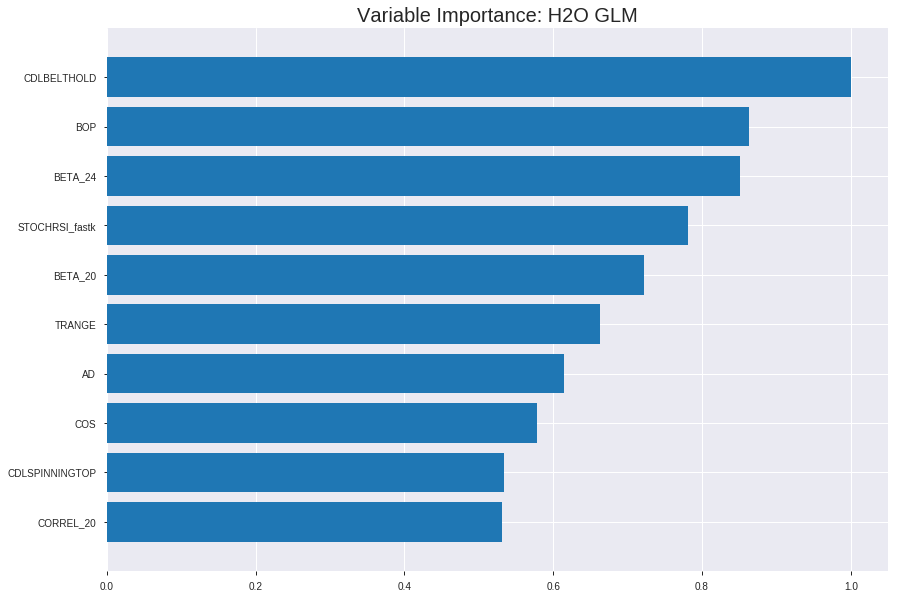

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_002941_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24688208222669852
RMSE: 0.49687229971764224
LogLoss: 0.6868873598024098
Null degrees of freedom: 1650
Residual degrees of freedom: 1600
Null deviance: 2277.720891745009
Residual deviance: 2268.102062067557
AIC: 2370.102062067557
AUC: 0.589813176065972
pr_auc: 0.6191611276993829
Gini: 0.1796263521319439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5261456197322781: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      55   703   0.9274   (703.0/758.0)
1      23   870   0.0258   (23.0/893.0)
Total  78   1573  0.4397   (726.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.526146     0.705596  353
max f2                       0.518216     0.855882  387
max f0point5                 0.535748     0.617859  262
max accuracy                 0.535748     0.584494  262
max precision                0.575322     1         0
max recall                   0.495184     1         398
max specificity              0.575322     1         0
max absolute_mcc             0.537501     0.150204  244
max min_per_class_accuracy   0.540981     0.554311  202
max mean_per_class_accuracy  0.539254     0.57339   223

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 54.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.564188           1.52256   1.52256            0.823529         0.568951  0.823529                    0.568951            0.0156775       0.0156775                  52.2561   52.2561
    2        0.0205936                   0.560868           1.63132   1.57694            0.882353         0.562001  0.852941                    0.565476            0.0167973       0.0324748                  63.1315   57.6938
    3        0.0302847                   0.559227           1.27107   1.47906            0.6875           0.559715  0.8                         0.563632            0.012318        0.0447928                  27.1067   47.9059
    4        0.0405815                   0.558097           1.08754   1.37972            0.588235         0.558749  0.746269                    0.562393            0.0111982       0.055991                   8.75436   37.972
    5        0.0502726                   0.556176           1.03996   1.31422            0.5625           0.557202  0.710843                    0.561393            0.0100784       0.0660694                  3.99636   31.4224
    6        0.100545                    0.551724           1.18057   1.2474             0.638554         0.553947  0.674699                    0.55767             0.0593505       0.12542                    18.0574   24.7399
    7        0.150212                    0.549563           1.10479   1.20024            0.597561         0.550621  0.649194                    0.555339            0.0548712       0.180291                   10.4785   20.0245
    8        0.200485                    0.547821           1.18057   1.19531            0.638554         0.548707  0.646526                    0.553676            0.0593505       0.239642                   18.0574   19.5312
    9        0.300424                    0.54541            1.06447   1.15179            0.575758         0.546473  0.622984                    0.55128             0.106383        0.346025                   6.44745   15.1788
    10       0.400363                    0.543174           1.01965   1.1188             0.551515         0.544167  0.605144                    0.549504            0.101904        0.447928                   1.96546   11.8804
    11       0.500303                    0.541014           1.05327   1.10571            0.569697         0.542105  0.598063                    0.548026            0.105263        0.553191                   5.32695   10.5713
    12       0.600242                    0.53886            1.1205    1.10818            0.606061         0.540042  0.599395                    0.546697            0.111982        0.665174                   12.05     10.8175
    13       0.700182                    0.536267           0.907605  1.07955            0.490909         0.537564  0.58391                     0.545393            0.0907055       0.755879                   -9.23954  7.9547
    14       0.800121                    0.533374           0.907605  1.05807            0.490909         0.534891  0.572294                    0.544082            0.0907055       0.846585                   -9.23954  5.80705
    15       0.900061                    0.529288           0.750735  1.02395            0.406061         0.531579  0.553836                    0.542693            0.075028        0.921613                   -24.9265  2.3945
    16       1                           0.465127           0.78435   1                  0.424242         0.524593  0.540884                    0.540884            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3844622574797954
RMSE: 0.6200502056122515
LogLoss: 10.187470664450068
Null degrees of freedom: 471
Residual degrees of freedom: 421
Null deviance: 657.825185254164
Residual deviance: 191558.53568434168
AIC: 191660.53568434168
AUC: 0.5403447347158632
pr_auc: 0.5346925906661895
Gini: 0.08068946943172639
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.664781  184
max f2                       0            0.832153  184
max f0point5                 0            0.553462  184
max accuracy                 0.534892     0.54661   130
max precision                0.559663     1         0
max recall                   0            1         184
max specificity              0.559663     1         0
max absolute_mcc             0.534892     0.101986  130
max min_per_class_accuracy   3.54144e-09  0.425532  183
max mean_per_class_accuracy  0.524414     0.546045  172

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 20.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.553625           1.20511   1.20511            0.6              0.556963   0.6                         0.556963            0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.55123            0.803404  1.00426            0.4              0.551977   0.5                         0.55447             0.00851064      0.0212766                  -19.6596  0.425532
    3        0.0317797                   0.550631           0.401702  0.803404           0.2              0.550859   0.4                         0.553266            0.00425532      0.0255319                  -59.8298  -19.6596
    4        0.0402542                   0.549968           1.50638   0.9514             0.75             0.550398   0.473684                    0.552663            0.012766        0.0382979                  50.6383   -4.86002
    5        0.0508475                   0.548703           1.60681   1.08794            0.8              0.549133   0.541667                    0.551927            0.0170213       0.0553191                  60.6809   8.79433
    6        0.101695                    0.545832           1.17163   1.12979            0.583333         0.547228   0.5625                      0.549578            0.0595745       0.114894                   17.1631   12.9787
    7        0.150424                    0.543133           1.13525   1.13156            0.565217         0.544353   0.56338                     0.547885            0.0553191       0.170213                   13.5245   13.1555
    8        0.201271                    0.540313           1.08794   1.12054            0.541667         0.54164    0.557895                    0.546308            0.0553191       0.225532                   8.79433   12.0538
    9        0.300847                    0.533489           1.11109   1.11741            0.553191         0.536671   0.556338                    0.543118            0.110638        0.33617                    11.1091   11.7411
    10       1                           0                  0.949478  1                  0.472727         0.0647264  0.497881                    0.208649            0.66383         1                          -5.05222  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:29:41  0.000 sec   2            4.1       51            1.37377           405.844
    2019-08-24 00:29:41  0.013 sec   4            2.5       51            1.37105           405.886
    2019-08-24 00:29:41  0.022 sec   6            1.6       51            1.3675            405.943
    2019-08-24 00:29:41  0.036 sec   8            0.97      51            1.36317           406.017
    2019-08-24 00:29:41  0.048 sec   10           0.61      51            1.35827           406.105

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5042372881355932)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 17.41573894489139)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.710096675203872)

('mse', 0.5042372881355932)

glm prediction progress: |████████████████████████████████████████████████| 100%


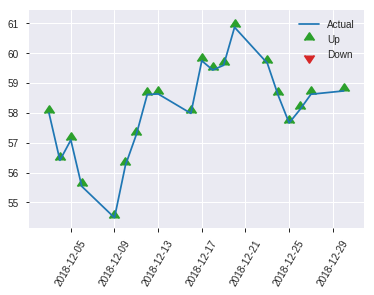


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5042372881355932
RMSE: 0.710096675203872
LogLoss: 17.41573894489139
Null degrees of freedom: 235
Residual degrees of freedom: 185
Null deviance: 328.4208830413794
Residual deviance: 168598.34761067876
AIC: 168700.34761067876
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.670423  0
max f2                       0            0.835674  0
max f0point5                 0            0.559737  0
max accuracy                 0            0.504237  0
max precision                0            0.504237  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.504237         0        0.504237                    0                   1               1                          0       0

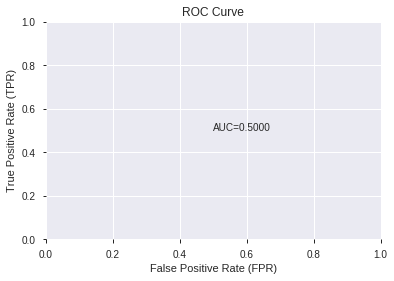

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


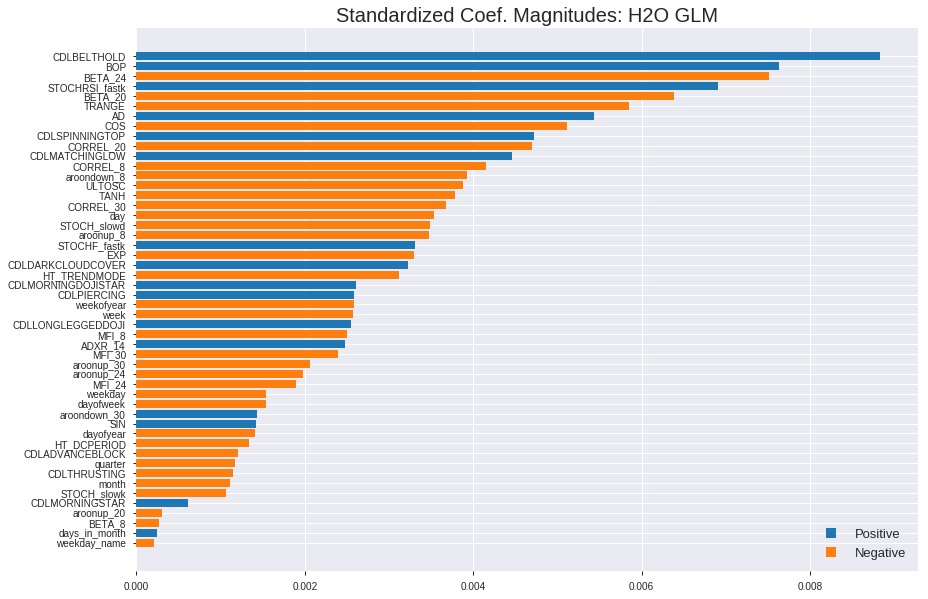

'log_likelihood'
--2019-08-24 00:29:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_002941_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_002941_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLBELTHOLD',
 'BOP',
 'BETA_24',
 'STOCHRSI_fastk',
 'BETA_20',
 'TRANGE',
 'AD',
 'COS',
 'CDLSPINNINGTOP',
 'CORREL_20',
 'CDLMATCHINGLOW',
 'CORREL_8',
 'aroondown_8',
 'ULTOSC',
 'TANH',
 'CORREL_30',
 'day',
 'STOCH_slowd',
 'aroonup_8',
 'STOCHF_fastk',
 'EXP',
 'CDLDARKCLOUDCOVER',
 'HT_TRENDMODE',
 'CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'weekofyear',
 'week',
 'CDLLONGLEGGEDDOJI',
 'MFI_8',
 'ADXR_14',
 'MFI_30',
 'aroonup_30',
 'aroonup_24',
 'MFI_24',
 'weekday',
 'dayofweek',
 'aroondown_30',
 'SIN',
 'dayofyear',
 'HT_DCPERIOD',
 'CDLADVANCEBLOCK',
 'quarter',
 'CDLTHRUSTING',
 'month',
 'STOCH_slowk',
 'CDLMORNINGSTAR',
 'aroonup_20',
 'BETA_8',
 'days_in_month',
 'weekday_name']

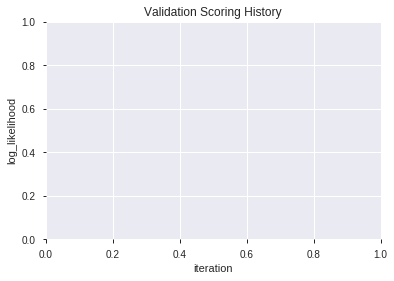

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_003047_model_1  0.570064  0.696754              0.487179  0.501573  0.251576
1               XGBoost_3_AutoML_20190824_003047  0.559434  0.698905              0.474144  0.502563  0.252569
2               XGBoost_1_AutoML_20190824_003047  0.556202  0.703392              0.500000  0.504366  0.254385
3  XGBoost_grid_1_AutoML_20190824_003047_model_3  0.534439  0.707243              0.491453  0.506522  0.256565
4  XGBoost_grid_1_AutoML_20190824_003047_model_4  0.532428  0.697023              0.495655  0.501713  0.251716
5  XGBoost_grid_1_AutoML_20190824_003047_model_2  0.529986  0.696485              0.491453  0.501620  0.251623
6  XGBoost_grid_1_AutoML_20190824_003047_model_6  0.527544  0.740412              0.474215  0.521117  0.271563
7               XGBoost_2_AutoML_20190824_003047  0.525892  0.702558              0.495726  0.504569  0.254590
8  XGBoost_grid_1_AutoML_20190824_003047_model_7  0.514544  0.719444              0.495655  0.511770  0.261908
9  XGBoost_grid_1_AutoML_20190824_003047_model_5  0.472384  0.785006              0.491453  0.538263  0.289727

variable  relative_importance  scaled_importance  percentage
0            CORREL_8           375.514038           1.000000    0.080270
1              TRANGE           331.269989           0.882177    0.070812
2                 BOP           278.286255           0.741081    0.059486
3                  AD           255.805206           0.681213    0.054681
4              MFI_24           234.293854           0.623928    0.050083
5             ADXR_14           226.135147           0.602202    0.048339
6             BETA_24           225.605881           0.600792    0.048225
7                 COS           222.152298           0.591595    0.047487
8        STOCHF_fastk           206.827805           0.550786    0.044211
9           CORREL_30           190.413681           0.507075    0.040703
10             MFI_30           185.195190           0.493178    0.039587
11                SIN           175.031342           0.466111    0.037415
12            BETA_20           138.714294           0.369398    0.029651
13                EXP           135.595444           0.361093    0.028985
14             BETA_8           122.295181           0.325674    0.026142
15             ULTOSC           120.748482           0.321555    0.025811
16        STOCH_slowk           115.543602           0.307694    0.024699
17       aroondown_30           108.728340           0.289545    0.023242
18        STOCH_slowd           106.185242           0.282773    0.022698
19          CORREL_20            97.311150           0.259141    0.020801
20        aroondown_8            96.640213           0.257354    0.020658
21        HT_DCPERIOD            86.910423           0.231444    0.018578
22          dayofweek            78.952354           0.210251    0.016877
23              MFI_8            70.346306           0.187333    0.015037
24         aroonup_20            64.930054           0.172910    0.013879
25     STOCHRSI_fastk            60.854500           0.162057    0.013008
26          aroonup_8            55.812824           0.148630    0.011931
27                day            53.532211           0.142557    0.011443
28         aroonup_30            48.984173           0.130446    0.010471
29          dayofyear            48.292091           0.128603    0.010323
30               TANH            35.467106           0.094449    0.007581
31       weekday_name            28.356173           0.075513    0.006061
32         aroonup_24            27.766266           0.073942    0.005935
33               week            27.316681           0.072745    0.005839
34  CDLLONGLEGGEDDOJI             9.931492           0.026448    0.002123
35        CDLBELTHOLD             9.519350           0.025350    0.002035
36         weekofyear             8.561245           0.022799    0.001830
37            weekday             6.384318           0.017002    0.001365
38     CDLMATCHINGLOW             6.299238           0.016775    0.001347
39      days_in_month             1.648040           0.004389    0.000352

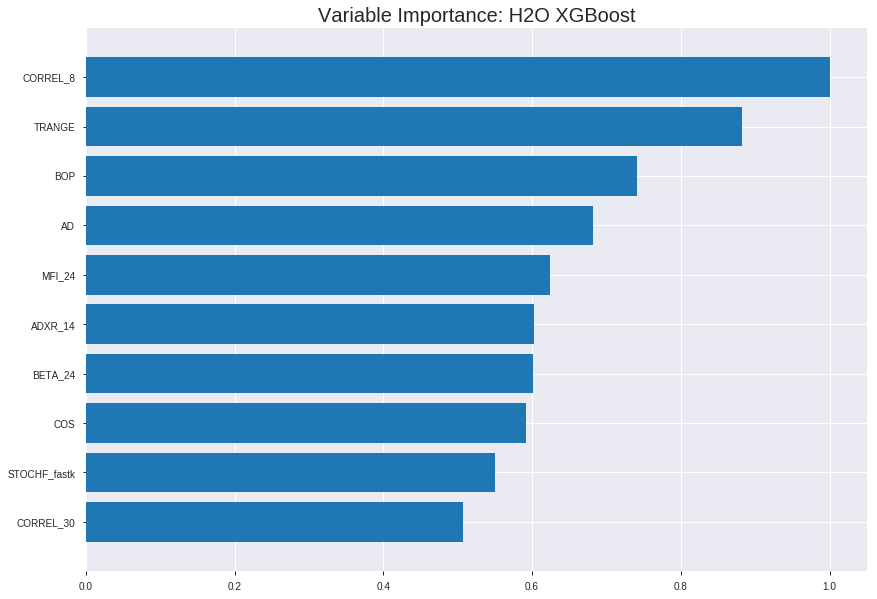

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_003047_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1819765963704821
RMSE: 0.42658714979530515
LogLoss: 0.5518887341741966
Mean Per-Class Error: 0.18251749904711811
AUC: 0.903396248157023
pr_auc: 0.9125256174854375
Gini: 0.806792496314046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5047206878662109: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      552  206   0.2718   (206.0/758.0)
1      84   809   0.0941   (84.0/893.0)
Total  636  1015  0.1757   (290.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504721     0.848008  224
max f2                       0.466304     0.907751  257
max f0point5                 0.581098     0.842878  152
max accuracy                 0.505846     0.824349  223
max precision                0.824586     1         0
max recall                   0.348195     1         351
max specificity              0.824586     1         0
max absolute_mcc             0.504721     0.649385  224
max min_per_class_accuracy   0.536991     0.811346  194
max mean_per_class_accuracy  0.505846     0.817483  223

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 53.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.774109           1.84882   1.84882            1                0.791217  1                           0.791217            0.019037        0.019037                   84.8824   84.8824
    2        0.0205936                   0.759711           1.84882   1.84882            1                0.76691   1                           0.779063            0.019037        0.0380739                  84.8824   84.8824
    3        0.0302847                   0.743578           1.84882   1.84882            1                0.751613  1                           0.770279            0.0179171       0.055991                   84.8824   84.8824
    4        0.0405815                   0.733172           1.84882   1.84882            1                0.737838  1                           0.762048            0.019037        0.075028                   84.8824   84.8824
    5        0.0502726                   0.724133           1.73327   1.82655            0.9375           0.728312  0.987952                    0.755544            0.0167973       0.0918253                  73.3273   82.6549
    6        0.100545                    0.694548           1.80427   1.81541            0.975904         0.707717  0.981928                    0.731631            0.0907055       0.182531                   80.4274   81.5412
    7        0.150212                    0.66508            1.75864   1.79664            0.95122          0.679712  0.971774                    0.714464            0.087346        0.269877                   75.8638   79.664
    8        0.200485                    0.643937           1.75972   1.78738            0.951807         0.655154  0.966767                    0.699592            0.0884658       0.358343                   75.9724   78.7383
    9        0.300424                    0.604938           1.60231   1.72582            0.866667         0.622941  0.933468                    0.674093            0.160134        0.518477                   60.2314   72.5818
    10       0.400363                    0.576035           1.43424   1.65303            0.775758         0.589993  0.8941                      0.6531              0.143337        0.661814                   43.4239   65.3033
    11       0.500303                    0.546147           1.22134   1.5668             0.660606         0.561801  0.847458                    0.634862            0.12206         0.783875                   22.1344   56.68
    12       0.600242                    0.510084           1.07568   1.48503            0.581818         0.528437  0.803229                    0.617143            0.107503        0.891377                   7.56795   48.5029
    13       0.700182                    0.469674           0.6723    1.36903            0.363636         0.489724  0.740484                    0.598956            0.0671892       0.958567                   -32.77    36.9026
    14       0.800121                    0.428979           0.235305  1.22742            0.127273         0.449049  0.663891                    0.580231            0.0235162       0.982083                   -76.4695  22.7418
    15       0.900061                    0.380437           0.145665  1.1073             0.0787879        0.405459  0.598923                    0.560825            0.0145577       0.996641                   -85.4335  10.7304
    16       1                           0.163716           0.033615  1                  0.0181818        0.32907   0.540884                    0.537664            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25261515604734347
RMSE: 0.5026083525443479
LogLoss: 0.6995756050950646
Mean Per-Class Error: 0.44744591076398244
AUC: 0.55405332615136
pr_auc: 0.5434292189781379
Gini: 0.1081066523027201
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24009791016578674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   223  0.9409   (223.0/237.0)
1      5    230  0.0213   (5.0/235.0)
Total  19   453  0.4831   (228.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.240098     0.668605  381
max f2                       0.162235     0.832743  398
max f0point5                 0.379921     0.569886  294
max accuracy                 0.516388     0.552966  156
max precision                0.748252     1         0
max recall                   0.162235     1         398
max specificity              0.748252     1         0
max absolute_mcc             0.684357     0.117225  12
max min_per_class_accuracy   0.49537      0.531646  190
max mean_per_class_accuracy  0.516388     0.552554  156

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.712834           1.60681   1.60681            0.8              0.730941  0.8                         0.730941            0.0170213       0.0170213                  60.6809   60.6809
    2        0.0211864                   0.69213            1.60681   1.60681            0.8              0.701242  0.8                         0.716092            0.0170213       0.0340426                  60.6809   60.6809
    3        0.0317797                   0.673298           1.60681   1.60681            0.8              0.682358  0.8                         0.704847            0.0170213       0.0510638                  60.6809   60.6809
    4        0.0402542                   0.658184           1.00426   1.47996            0.5              0.66909   0.736842                    0.697319            0.00851064      0.0595745                  0.425532  47.9955
    5        0.0508475                   0.649484           0         1.17163            0                0.65218   0.583333                    0.687915            0               0.0595745                  -100      17.1631
    6        0.101695                    0.602857           1.00426   1.08794            0.5              0.621309  0.541667                    0.654612            0.0510638       0.110638                   0.425532  8.79433
    7        0.150424                    0.582712           1.04792   1.07498            0.521739         0.592142  0.535211                    0.634375            0.0510638       0.161702                   4.79186   7.49775
    8        0.201271                    0.567028           1.17163   1.0994             0.583333         0.575385  0.547368                    0.619473            0.0595745       0.221277                   17.1631   9.93953
    9        0.300847                    0.539533           1.15383   1.11741            0.574468         0.552979  0.556338                    0.597464            0.114894        0.33617                    15.3825   11.7411
    10       0.400424                    0.516398           1.15383   1.12647            0.574468         0.52947   0.560847                    0.580556            0.114894        0.451064                   15.3825   12.6466
    11       0.5                         0.49537            0.811951  1.06383            0.404255         0.50481   0.529661                    0.565471            0.0808511       0.531915                   -18.8049  6.38298
    12       0.599576                    0.462962           1.11109   1.07168            0.553191         0.479582  0.533569                    0.551206            0.110638        0.642553                   11.1091   7.16788
    13       0.699153                    0.419308           0.940154  1.05295            0.468085         0.441462  0.524242                    0.535576            0.093617        0.73617                    -5.98461  5.29465
    14       0.798729                    0.359206           1.02562   1.04954            0.510638         0.388278  0.522546                    0.517213            0.102128        0.838298                   2.56225   4.954
    15       0.898305                    0.307558           0.769217  1.01847            0.382979         0.335644  0.507075                    0.497086            0.0765957       0.914894                   -23.0783  1.84665
    16       1                           0.156244           0.836879  1                  0.416667         0.249456  0.497881                    0.471903           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:30:50  0.021 sec   0                  0.5              0.693147            0.5             0                  1                0.459116                         0.5                0.693147              0.5               0                    1                  0.502119
    2019-08-24 00:30:50  0.074 sec   5                  0.48759          0.668564            0.749143        0.769757           1.84882          0.322835                         0.499579           0.692303              0.526537          0.515469             0.401702           0.485169
    2019-08-24 00:30:50  0.110 sec   10                 0.476738         0.647341            0.78971         0.806042           1.84882          0.289522                         0.498868           0.690886              0.540506          0.527129             1.00426            0.495763
    2019-08-24 00:30:50  0.149 sec   15                 0.467576         0.629557            0.815554        0.831654           1.84882          0.264082                         0.49992            0.693027              0.53661           0.527527             1.60681            0.483051
    2019-08-24 00:30:50  0.191 sec   20                 0.45864          0.612404            0.843368        0.856964           1.84882          0.233192                         0.500161           0.693636              0.54548           0.531638             1.60681            0.483051
    2019-08-24 00:30:50  0.237 sec   25                 0.45209          0.599857            0.856307        0.868718           1.84882          0.224712                         0.500322           0.69407               0.5482            0.53319              1.60681            0.483051
    2019-08-24 00:30:50  0.278 sec   30                 0.445822         0.587964            0.869938        0.880054           1.84882          0.213204                         0.499831           0.693196              0.554673          0.538559             1.20511            0.480932
    2019-08-24 00:30:51  0.316 sec   35                 0.440778         0.578429            0.879222        0.889594           1.84882          0.196245                         0.500255           0.694113              0.554924          0.543241             1.20511            0.480932
    2019-08-24 00:30:51  0.358 sec   40                 0.435983         0.569327            0.885325        0.895138           1.84882          0.199273                         0.500798           0.695313              0.552141          0.541419             1.20511            0.480932
    2019-08-24 00:30:51  0.410 sec   45                 0.430519         0.559191            0.895202        0.903418           1.84882          0.188976                         0.501427           0.696763              0.5532            0.542341             1.60681            0.478814
    2019-08-24 00:30:51  0.467 sec   50                 0.426587         0.551889            0.903396        0.912526           1.84882          0.175651                         0.502608           0.699576              0.554053          0.543429             1.60681            0.483051

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
CORREL_8        375.5140380859375      1.0                   0.08026964458233363
TRANGE          331.2699890136719      0.8821773766493911    0.07081206448222209
BOP             278.2862548828125      0.7410808296309973    0.0594862948012611
AD              255.80520629882812     0.681213431068285     0.054680759996563265
MFI_24          234.29385375976562     0.6239283488681369    0.05008250680848761
---             ---                    ---                   ---
CDLBELTHOLD     9.519350051879883      0.025350184244513786  0.0020348502794037956
weekofyear      8.56124496459961       0.022798734790948995  0.0018300463385963603
weekday         6.384317874908447      0.01700154249212749   0.0013647077731945164
CDLMATCHINGLOW  6.299238204956055      0.016774973945220272  0.0013465211964607383
days_in_month   1.6480402946472168     0.004388758148823341  0.0003522840567638701


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5889830508474576)

('F1', 0.6761363636363636)

('auc', 0.5700639230050994)

('logloss', 0.6967537747040674)

('mean_per_class_error', 0.41230338289161816)

('rmse', 0.5015732739678527)

('mse', 0.2515757491588306)

xgboost prediction progress: |████████████████████████████████████████████| 100%


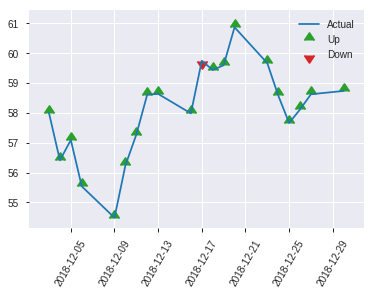


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2515757491588306
RMSE: 0.5015732739678527
LogLoss: 0.6967537747040674
Mean Per-Class Error: 0.41230338289161816
AUC: 0.5700639230050994
pr_auc: 0.5595597058346146
Gini: 0.1401278460101989
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24265198409557343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    114  0.9744   (114.0/117.0)
1      0    119  0        (0.0/119.0)
Total  3    233  0.4831   (114.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.242652     0.676136  232
max f2                       0.242652     0.83921   232
max f0point5                 0.387257     0.598639  153
max accuracy                 0.387257     0.588983  153
max precision                0.69835      1         0
max recall                   0.242652     1         232
max specificity              0.69835      1         0
max absolute_mcc             0.387257     0.184167  153
max min_per_class_accuracy   0.439877     0.538462  118
max mean_per_class_accuracy  0.387257     0.587697  153

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 44.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.672463           1.32213   1.32213            0.666667         0.683277  0.666667                    0.683277            0.0168067       0.0168067                  32.2129    32.2129
    2        0.0211864                   0.662312           1.98319   1.58655            1                0.666537  0.8                         0.676581            0.0168067       0.0336134                  98.3193    58.6555
    3        0.0338983                   0.651152           0.661064  1.2395             0.333333         0.656477  0.625                       0.669042            0.00840336      0.0420168                  -33.8936   23.9496
    4        0.0423729                   0.617723           1.98319   1.38824            1                0.630686  0.7                         0.661371            0.0168067       0.0588235                  98.3193    38.8235
    5        0.0508475                   0.613743           0.991597  1.32213            0.5              0.614315  0.666667                    0.653528            0.00840336      0.0672269                  -0.840336  32.2129
    6        0.101695                    0.586027           1.15686   1.2395             0.583333         0.603068  0.625                       0.628298            0.0588235       0.12605                    15.6863    23.9496
    7        0.152542                    0.570954           1.15686   1.21195            0.583333         0.576859  0.611111                    0.611152            0.0588235       0.184874                   15.6863    21.1951
    8        0.20339                     0.547112           0.826331  1.11555            0.416667         0.555331  0.5625                      0.597197            0.0420168       0.226891                   -17.3669   11.5546
    9        0.300847                    0.509695           0.948484  1.06143            0.478261         0.525097  0.535211                    0.57384             0.092437        0.319328                   -5.15163   6.14274
    10       0.402542                    0.470311           0.991597  1.04379            0.5              0.490135  0.526316                    0.552694            0.10084         0.420168                   -0.840336  4.37859
    11       0.5                         0.440385           1.20716   1.07563            0.608696         0.453996  0.542373                    0.533456            0.117647        0.537815                   20.7161    7.56303
    12       0.601695                    0.416551           1.32213   1.11729            0.666667         0.428424  0.56338                     0.515704            0.134454        0.672269                   32.2129    11.7292
    13       0.699153                    0.379714           0.948484  1.09376            0.478261         0.390774  0.551515                    0.49829             0.092437        0.764706                   -5.15163   9.37611
    14       0.800847                    0.339832           0.991597  1.08079            0.5              0.35843   0.544974                    0.48053             0.10084         0.865546                   -0.840336  8.07879
    15       0.898305                    0.307665           0.344903  1.00095            0.173913         0.323376  0.504717                    0.46348             0.0336134       0.89916                    -65.5097   0.0951324
    16       1                           0.195254           0.991597  1                  0.5              0.273192  0.504237                  

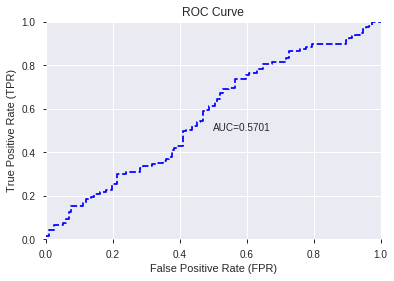

This function is available for GLM models only


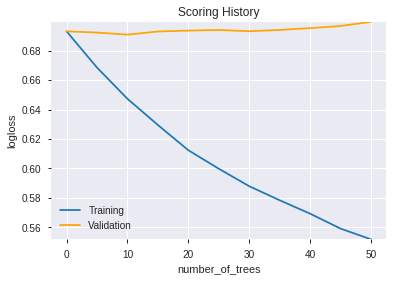

--2019-08-24 00:31:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_003047_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_003047_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_8',
 'TRANGE',
 'BOP',
 'AD',
 'MFI_24',
 'ADXR_14',
 'BETA_24',
 'COS',
 'STOCHF_fastk',
 'CORREL_30',
 'MFI_30',
 'SIN',
 'BETA_20',
 'EXP',
 'BETA_8',
 'ULTOSC',
 'STOCH_slowk',
 'aroondown_30',
 'STOCH_slowd',
 'CORREL_20',
 'aroondown_8',
 'HT_DCPERIOD',
 'dayofweek',
 'MFI_8',
 'aroonup_20',
 'STOCHRSI_fastk',
 'aroonup_8',
 'day',
 'aroonup_30',
 'dayofyear',
 'TANH',
 'weekday_name',
 'aroonup_24',
 'week',
 'CDLLONGLEGGEDDOJI',
 'CDLBELTHOLD',
 'weekofyear',
 'weekday',
 'CDLMATCHINGLOW',
 'days_in_month']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_003203_model_2  0.5  17.415739                   0.5  0.710097  0.504237
1  DeepLearning_grid_1_AutoML_20190824_003203_model_9  0.5   0.693465                   0.5  0.500159  0.250159
2  DeepLearning_grid_1_AutoML_20190824_003203_model_7  0.5  17.415739                   0.5  0.710097  0.504237
3               DeepLearning_1_AutoML_20190824_003203  0.5  17.123037                   0.5  0.704104  0.495763
4  DeepLearning_grid_1_AutoML_20190824_003203_model_8  0.5   0.693290                   0.5  0.500071  0.250071
5  DeepLearning_grid_1_AutoML_20190824_003203_model_3  0.5  17.415739                   0.5  0.710097  0.504237
6  DeepLearning_grid_1_AutoML_20190824_003203_model_4  0.5  17.415739                   0.5  0.710097  0.504237
7  DeepLearning_grid_1_AutoML_20190824_003203_model_1  0.5  17.415739                   0.5  0.710097  0.504237
8  DeepLearning_grid_1_AutoML_20190824_003203_model_5  0.5  17.415739                   0.5  0.710097  0.504237
9  DeepLearning_grid_1_AutoML_20190824_003203_model_6  0.5   0.693463                   0.5  0.500158  0.250158

variable  relative_importance  scaled_importance  percentage
0                          COS             1.000000           1.000000    0.001766
1                         TANH             0.956827           0.956827    0.001690
2                  CDLBELTHOLD             0.936176           0.936176    0.001653
3                          BOP             0.936094           0.936094    0.001653
4                          day             0.933100           0.933100    0.001648
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_20_6_2             0.456250           0.456250    0.000806
1032   BBANDS_lowerband_14_3_3             0.452500           0.452500    0.000799
1033  BBANDS_middleband_24_7_4             0.446303           0.446303    0.000788
1034                   MA_14_1             0.444387           0.444387    0.000785
1035   BBANDS_upperband_14_6_3             0.442880           0.442880    0.000782

[1036 rows x 4 columns]

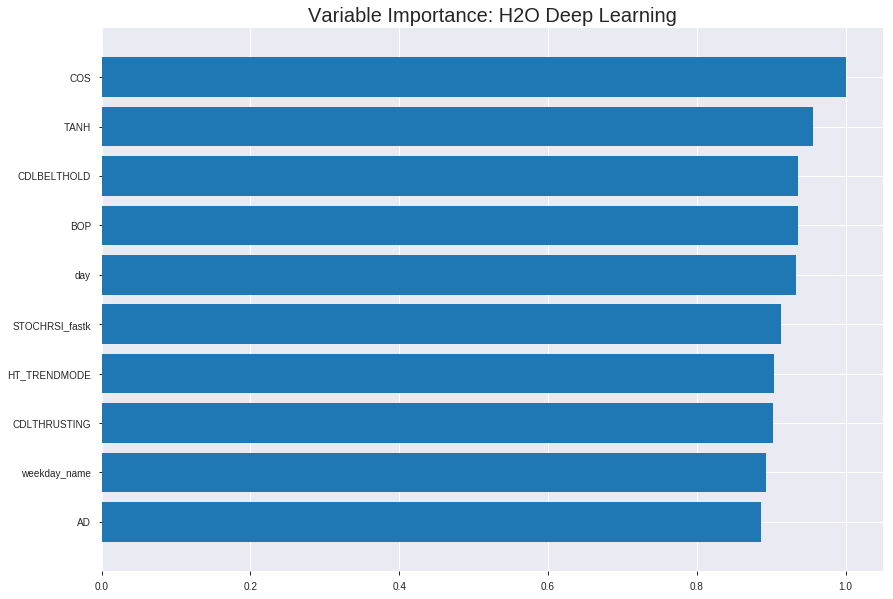

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_003203_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2577657808444128
RMSE: 0.5077063923611882
LogLoss: 0.7115997885649927
Mean Per-Class Error: 0.4503858802116727
AUC: 0.5524971413544809
pr_auc: 0.5916148798530143
Gini: 0.10499428270896183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16107660852242447: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    751   0.9908   (751.0/758.0)
1      0    893   0        (0.0/893.0)
Total  7    1644  0.4549   (751.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.161077     0.703981   393
max f2                       0.161077     0.85602    393
max f0point5                 0.271591     0.600783   359
max accuracy                 0.272554     0.552392   358
max precision                0.909739     1          0
max recall                   0.161077     1          393
max specificity              0.909739     1          0
max absolute_mcc             0.522272     0.0991539  188
max min_per_class_accuracy   0.508834     0.539754   199
max mean_per_class_accuracy  0.522272     0.549614   188

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 51.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.85111            1.1963    1.1963             0.647059         0.88034   0.647059                    0.88034             0.012318        0.012318                   19.6298   19.6298
    2        0.0205936                   0.802485           1.30505   1.25068            0.705882         0.819144  0.676471                    0.849742            0.0134378       0.0257559                  30.5052   25.0675
    3        0.0302847                   0.785752           1.15552   1.22022            0.625            0.794537  0.66                        0.832076            0.0111982       0.0369541                  15.5515   22.0224
    4        0.0405815                   0.768722           1.1963    1.21415            0.647059         0.774608  0.656716                    0.817495            0.012318        0.0492721                  19.6298   21.4153
    5        0.0502726                   0.759406           1.27107   1.22512            0.6875           0.76301   0.662651                    0.806992            0.012318        0.0615901                  27.1067   22.5124
    6        0.100545                    0.712592           1.18057   1.20285            0.638554         0.737026  0.650602                    0.772009            0.0593505       0.120941                   18.0574   20.2849
    7        0.150212                    0.679218           1.10479   1.17042            0.597561         0.694302  0.633065                    0.746315            0.0548712       0.175812                   10.4785   17.0425
    8        0.200485                    0.648374           0.93555   1.11153            0.506024         0.663417  0.601208                    0.725528            0.0470325       0.222844                   -6.44504  11.1529
    9        0.300424                    0.600756           1.1317    1.11824            0.612121         0.625204  0.604839                    0.692154            0.113102        0.335946                   13.1705   11.824
    10       0.400363                    0.548108           1.00845   1.09083            0.545455         0.574162  0.590015                    0.662701            0.100784        0.43673                    0.844956  9.08342
    11       0.500303                    0.508787           1.01965   1.07662            0.551515         0.528209  0.582324                    0.635835            0.101904        0.538634                   1.96546   7.66155
    12       0.600242                    0.468162           0.907605  1.04848            0.490909         0.487621  0.567104                    0.611158            0.0907055       0.629339                   -9.23954  4.84755
    13       0.700182                    0.423189           0.930015  1.03157            0.50303          0.447832  0.557958                    0.587845            0.0929451       0.722284                   -6.99854  3.15671
    14       0.800121                    0.374514           0.930015  1.01888            0.50303          0.397063  0.551098                    0.564016            0.0929451       0.81523                    -6.99854  1.88827
    15       0.900061                    0.309334           0.930015  1.00902            0.50303          0.343266  0.54576                     0.539504            0.0929451       0.908175                   -6.99854  0.901509
    16       1                           3.96258e-06        0.91881   1                  0.49697          0.255602  0.540884                    0.511131         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.40857393773611606
RMSE: 0.6391978862106132
LogLoss: 10.321808733900768
Mean Per-Class Error: 0.45404434868480115
AUC: 0.5418798814974414
pr_auc: 0.5552037474516173
Gini: 0.08375976299488275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.6602396356873086e-211: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold     value     idx
---------------------------  ------------  --------  -----
max f1                       1.66024e-211  0.664781  183
max f2                       1.66024e-211  0.832153  183
max f0point5                 1.66024e-211  0.553462  183
max accuracy                 0.137305      0.54661   162
max precision                0.534969      1         0
max recall                   1.66024e-211  1         183
max specificity              0.534969      1         0
max absolute_mcc             0.388198      0.138221  39
max min_per_class_accuracy   1.19775e-10   0.421277  182
max mean_per_class_accuracy  0.137305      0.545956  162

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 11.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.502279           1.60681   1.60681            0.8              0.518889   0.8                         0.518889            0.0170213       0.0170213                  60.6809   60.6809
    2        0.0211864                   0.485763           1.60681   1.60681            0.8              0.495327   0.8                         0.507108            0.0170213       0.0340426                  60.6809   60.6809
    3        0.0317797                   0.468144           0.803404  1.33901            0.4              0.475169   0.666667                    0.496462            0.00851064      0.0425532                  -19.6596  33.9007
    4        0.0402542                   0.444039           1.00426   1.26853            0.5              0.462655   0.631579                    0.489344            0.00851064      0.0510638                  0.425532  26.8533
    5        0.0508475                   0.427748           2.00851   1.4227             1                0.437269   0.708333                    0.478495            0.0212766       0.0723404                  100.851   42.2695
    6        0.101695                    0.365533           1.17163   1.29716            0.583333         0.399435   0.645833                    0.438965            0.0595745       0.131915                   17.1631   29.7163
    7        0.150424                    0.31286            0.873265  1.15984            0.434783         0.332466   0.577465                    0.404465            0.0425532       0.174468                   -12.6735  15.9844
    8        0.201271                    0.279502           1.00426   1.12054            0.5              0.297811   0.557895                    0.377521            0.0510638       0.225532                   0.425532  12.0538
    9        0.300847                    0.210661           1.15383   1.13156            0.574468         0.245183   0.56338                     0.333719            0.114894        0.340426                   15.3825   13.1555
    10       1                           0                  0.943391  1                  0.469697         0.0164073  0.497881                    0.11187             0.659574        1                          -5.66086  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:34:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 00:34:32  2 min 27.670 sec  327 obs/sec       0.503937  1             832        0.620328         2.92451             -0.549588      0.563974        0.455287           1.1963           0.459116                         0.677978           12.2936               -0.838649        0.536853          0.467815             0.803404           0.502119
    2019-08-24 00:34:44  2 min 39.304 sec  330 obs/sec       2.64809   5             4372       0.560758         0.985221            -0.266266      0.588264        0.619117           1.74007          0.451847                         0.678036           11.0392               -0.838965        0.540183          0.542331             1.60681            0.502119
    2019-08-24 00:34:55  2 min 50.541 sec  334 obs/sec       4.76257   9             7863       0.493867         0.681089            0.0178128      0.610183        0.647268           1.74007          0.45003                          0.634789           10.3594               -0.611855        0.543765          0.553561             1.20511            0.502119
    2019-08-24 00:35:06  3 min  1.565 sec  339 obs/sec       6.90733   13            11404      0.540332         0.897292            -0.175694      0.534731        0.550839           0.978789         0.442156                         0.666393           10.5176               -0.776353        0.531861          0.52525              1.20511            0.502119
    2019-08-24 00:35:17  3 min 12.367 sec  342 obs/sec       9.02059   17            14893      0.514603         0.727842            -0.0663941     0.551829        0.572001           1.08754          0.44579                          0.635684           10.3392               -0.616407        0.539025          0.539703             1.60681            0.502119
    2019-08-24 00:35:28  3 min 22.980 sec  347 obs/sec       11.1853   21            18467      0.507706         0.7116              -0.0380033     0.552497        0.591615           1.1963           0.454876                         0.639198           10.3218               -0.634325        0.54188           0.555204             1.60681            0.502119
    2019-08-24 00:35:38  3 min 33.344 sec  351 obs/sec       13.3162   25            21985      0.505404         0.711141            -0.0286087     0.585702        0.624102           1.41381          0.455482                         0.651884           10.3803               -0.699842        0.543065          0.557021             1.20511            0.502119
    2019-08-24 00:35:49  3 min 43.731 sec  353 obs/sec       15.4446   29            25499      0.511771         0.729529            -0.0546897     0.586307        0.635897           1.74007          0.444579                         0.665729           10.4582               -0.772815        0.541108          0.549239             1.60681            0.502119
    2019-08-24 00:35:50

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
COS                       1.0                    1.0                  0.0017657949431606236
TANH                      0.95682692527771       0.95682692527771     0.001689560146135308
CDLBELTHOLD               0.9361763596534729     0.9361763596534729   0.0016530954817826236
BOP                       0.9360936284065247     0.9360936284065247   0.001652949395365121
day                       0.9330995678901672     0.9330995678901672   0.0016476624984458203
---                       ---                    ---                  ---
BBANDS_middleband_20_6_2  0.45625022053718567    0.45625022053718567  0.0008056443322404818
BBANDS_lowerband_14_3_3   0.45250028371810913    0.45250028371810913  0.0007990227127681846
BBANDS_middleband_24_7_4  0.44630303978919983    0.44630303978919983  0.0007880796507769836
MA_14_1                   0.444387286901474      0.444387286901474    0.000784696824015492
BBANDS_upperband_14_6_3   0.4428803026676178     0.4428803026676178   0.000782035798875926


See the whole table with table.as_data_frame()


Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5042372881355932)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 17.41573894489139)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.710096675203872)

('mse', 0.5042372881355932)

deeplearning prediction progress: |███████████████████████████████████████| 100%


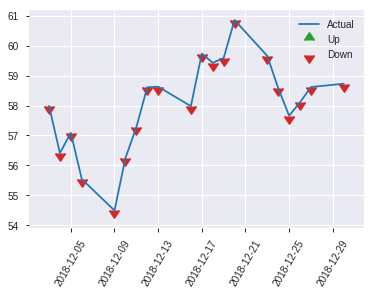


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5042372881355932
RMSE: 0.710096675203872
LogLoss: 17.41573894489139
Could not find exact threshold 0.0; using closest threshold found 0.0.
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.670423  0
max f2                       0            0.835674  0
max f0point5                 0            0.559737  0
max accuracy                 0            0.504237  0
max precision                0            0.504237  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.504237         0        0.504237                    0                   1               1                          0       0

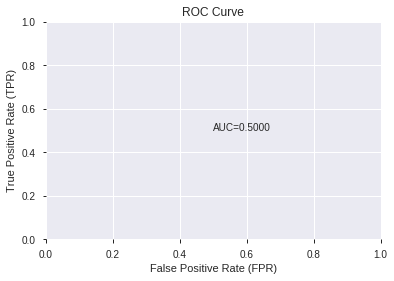

This function is available for GLM models only


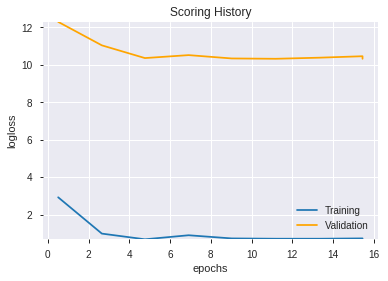

--2019-08-24 00:56:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.20
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.20|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_003203_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_003203_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['COS',
 'TANH',
 'CDLBELTHOLD',
 'BOP',
 'day',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'CDLTHRUSTING',
 'weekday_name',
 'AD',
 'aroondown_8',
 'CDLINNECK',
 'dayofyear',
 'month',
 'ULTOSC',
 'CORREL_30',
 'aroonup_30',
 'STOCH_slowd',
 'SINH',
 'weekofyear',
 'CDLSPINNINGTOP',
 'CDLDARKCLOUDCOVER',
 'MFI_8',
 'ADOSC',
 'HT_DCPERIOD',
 'BETA_24',
 'CORREL_20',
 'SIN',
 'CDLDOJI',
 'weekday',
 'CORREL_24',
 'dayofweek',
 'ADX_24',
 'CORREL_14',
 'BETA_20',
 'ADX_20',
 'aroondown_12',
 'COSH',
 'quarter',
 'EXP',
 'aroonup_8',
 'week',
 'ADXR_14',
 'MFI_30',
 'CDLMATCHINGLOW',
 'aroondown_30',
 'MFI_24',
 'BETA_8',
 'STOCHRSI_fastd',
 'ROCR_8',
 'CORREL_8',
 'aroonup_24',
 'aroonup_20',
 'BETA_12',
 'CDLLONGLEGGEDDOJI',
 'AROONOSC_24',
 'DX_8',
 'STOCH_slowk',
 'CDLSTICKSANDWICH',
 'STOCHF_fastk',
 'SAREXT',
 'AROONOSC_30',
 'CCI_8',
 'CDLMORNINGSTAR',
 'aroonup_14',
 'ROC_8',
 'CDLEVENINGDOJISTAR',
 'days_in_month',
 'aroondown_14',
 'ADXR_12',
 'CORREL_12',
 'MACDFIX_signal_20',
 'BETA

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_005753_model_1  0.5  17.415739                   0.5  0.710097  0.504237

variable  relative_importance  scaled_importance    percentage
0                  CDLBELTHOLD         8.231533e-03           1.000000  1.242163e-02
1                          BOP         7.084997e-03           0.860714  1.069148e-02
2               STOCHRSI_fastk         6.024941e-03           0.731934  9.091819e-03
3                      BETA_24         5.881280e-03           0.714482  8.875030e-03
4                           AD         5.765224e-03           0.700383  8.699898e-03
...                        ...                  ...                ...           ...
1031                    MAX_12         3.028759e-06           0.000368  4.570489e-06
1032   BBANDS_lowerband_14_7_2         2.578608e-06           0.000313  3.891198e-06
1033                     EMA_8         2.240103e-06           0.000272  3.380383e-06
1034  BBANDS_middleband_24_6_4         1.260259e-06           0.000153  1.901769e-06
1035   BBANDS_upperband_24_5_4         3.420903e-07           0.000042  5.162247e-07

[1036 rows x 4 columns]

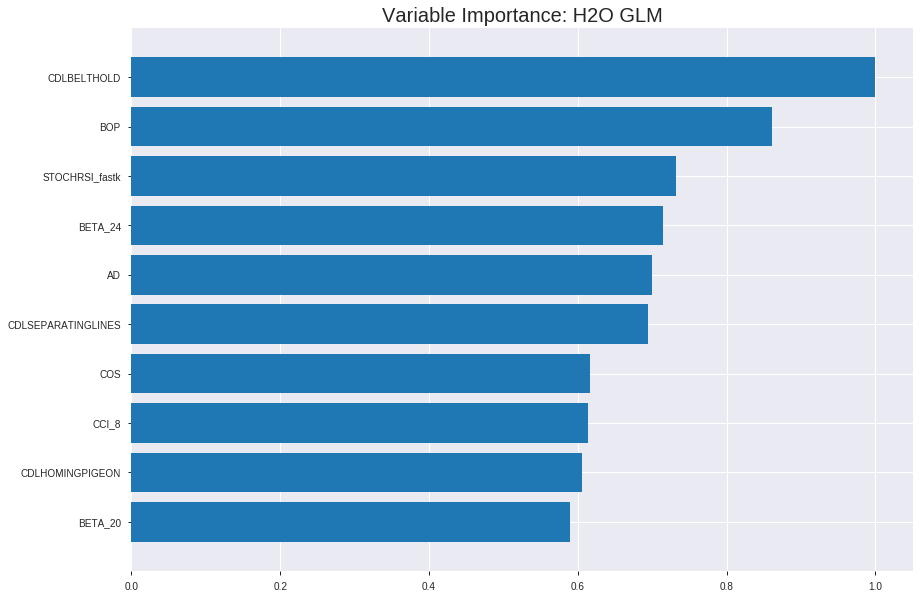

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_005753_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24477405874313138
RMSE: 0.4947464590506246
LogLoss: 0.6826095592932362
Null degrees of freedom: 1650
Residual degrees of freedom: 614
Null deviance: 2277.720891745009
Residual deviance: 2253.976764786266
AIC: 4327.976764786266
AUC: 0.5900517658599426
pr_auc: 0.628861444315338
Gini: 0.18010353171988513
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5033031418615931: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      87   671   0.8852   (671.0/758.0)
1      43   850   0.0482   (43.0/893.0)
Total  130  1521  0.4325   (714.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503303     0.704225  325
max f2                       0.431422     0.855692  394
max f0point5                 0.506812     0.611784  315
max accuracy                 0.519781     0.573592  269
max precision                0.607784     1         0
max recall                   0.431422     1         394
max specificity              0.607784     1         0
max absolute_mcc             0.506812     0.133698  315
max min_per_class_accuracy   0.546413     0.557671  159
max mean_per_class_accuracy  0.542719     0.562169  177

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 54.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.582826           1.63132   1.63132            0.882353         0.591328  0.882353                    0.591328            0.0167973       0.0167973                  63.1315   63.1315
    2        0.0205936                   0.579957           1.52256   1.57694            0.823529         0.581204  0.852941                    0.586266            0.0156775       0.0324748                  52.2561   57.6938
    3        0.0302847                   0.577271           1.27107   1.47906            0.6875           0.577924  0.8                         0.583597            0.012318        0.0447928                  27.1067   47.9059
    4        0.0405815                   0.574841           1.30505   1.43491            0.705882         0.576241  0.776119                    0.58173             0.0134378       0.0582307                  30.5052   43.4908
    5        0.0502726                   0.573403           1.03996   1.35877            0.5625           0.574031  0.73494                     0.580246            0.0100784       0.0683091                  3.99636   35.8774
    6        0.100545                    0.567927           1.31422   1.3365             0.710843         0.570271  0.722892                    0.575259            0.0660694       0.134378                   31.4224   33.6499
    7        0.150212                    0.564439           1.05969   1.24497            0.573171         0.566191  0.673387                    0.57226             0.0526316       0.18701                    5.96919   24.4974
    8        0.200485                    0.561365           1.04692   1.19531            0.566265         0.563051  0.646526                    0.569951            0.0526316       0.239642                   4.69245   19.5312
    9        0.300424                    0.556591           1.04206   1.14433            0.563636         0.55887   0.618952                    0.566265            0.104143        0.343785                   4.20645   14.4333
    10       0.400363                    0.551635           1.09809   1.13279            0.593939         0.554114  0.612708                    0.563232            0.109742        0.453527                   9.80895   13.2789
    11       0.500303                    0.546565           1.00845   1.10795            0.545455         0.549077  0.599274                    0.560404            0.100784        0.554311                   0.844956  10.7952
    12       0.600242                    0.539472           0.96363   1.08392            0.521212         0.54344   0.586276                    0.55758             0.0963046       0.650616                   -3.63704  8.39222
    13       0.700182                    0.531244           0.974835  1.06835            0.527273         0.535699  0.577855                    0.554457            0.0974244       0.74804                    -2.51654  6.83517
    14       0.800121                    0.519792           0.974835  1.05667            0.527273         0.525464  0.571537                    0.550835            0.0974244       0.845465                   -2.51654  5.66709
    15       0.900061                    0.507447           0.907605  1.04012            0.490909         0.513938  0.562584                    0.546738            0.0907055       0.93617                    -9.23954  4.01191
    16       1                           0.241407           0.638685  1                  0.345455         0.488163  0.540884                    0.540884         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3844446933195287
RMSE: 0.6200360419520212
LogLoss: 10.214674894043258
Null degrees of freedom: 471
Residual degrees of freedom: -565
Null deviance: 657.825185254164
Residual deviance: 191584.21305130678
AIC: 193658.21305130678
AUC: 0.5442768650686777
pr_auc: 0.5494971808020985
Gini: 0.08855373013735535
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.664781  184
max f2                       0            0.832153  184
max f0point5                 0            0.553462  184
max accuracy                 0.497815     0.550847  124
max precision                0.552402     1         0
max recall                   0            1         184
max specificity              0.552402     1         0
max absolute_mcc             0.497815     0.11298   124
max min_per_class_accuracy   1.02316e-14  0.425532  183
max mean_per_class_accuracy  0.491172     0.549942  134

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 19.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.540788           1.20511   1.20511            0.6              0.545751   0.6                         0.545751            0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.537743           1.60681   1.40596            0.8              0.538658   0.7                         0.542205            0.0170213       0.0297872                  60.6809   40.5957
    3        0.0317797                   0.535242           1.20511   1.33901            0.6              0.536785   0.666667                    0.540398            0.012766        0.0425532                  20.5106   33.9007
    4        0.0402542                   0.533281           1.00426   1.26853            0.5              0.534078   0.631579                    0.539068            0.00851064      0.0510638                  0.425532  26.8533
    5        0.0508475                   0.532689           1.60681   1.33901            0.8              0.532987   0.666667                    0.537801            0.0170213       0.0680851                  60.6809   33.9007
    6        0.101695                    0.523975           1.00426   1.17163            0.5              0.528287   0.583333                    0.533044            0.0510638       0.119149                   0.425532  17.1631
    7        0.150424                    0.518587           1.04792   1.13156            0.521739         0.52152    0.56338                     0.529311            0.0510638       0.170213                   4.79186   13.1555
    8        0.201271                    0.51227            1.25532   1.16282            0.625            0.515684   0.578947                    0.525868            0.0638298       0.234043                   25.5319   16.2822
    9        0.300847                    0.487839           1.15383   1.15984            0.574468         0.501593   0.577465                    0.517834            0.114894        0.348936                   15.3825   15.9844
    10       1                           0                  0.931219  1                  0.463636         0.0578046  0.497881                    0.196203            0.651064        1                          -6.87814  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 00:57:56  0.000 sec   2            4.1       1037          1.36522           405.899
    2019-08-24 00:57:58  1.790 sec   4            3         1037          1.36183           405.924
    2019-08-24 00:57:59  3.681 sec   6            2.2       1037          1.35781           405.947
    2019-08-24 00:58:01  5.538 sec   8            1.6       1037          1.35312           405.971
    2019-08-24 00:58:03  7.339 sec   10           1.1       1037          1.34779           405.991

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5042372881355932)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6704225352112676)

('auc', 0.5)

('logloss', 17.41573894489139)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.710096675203872)

('mse', 0.5042372881355932)

glm prediction progress: |████████████████████████████████████████████████| 100%


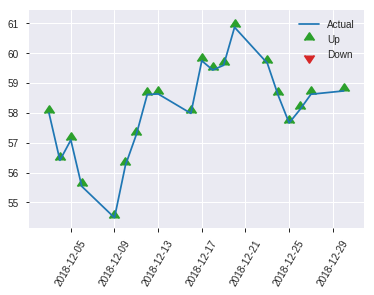


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5042372881355932
RMSE: 0.710096675203872
LogLoss: 17.41573894489139
Null degrees of freedom: 235
Residual degrees of freedom: -801
Null deviance: 328.4208830413794
Residual deviance: 168598.34761067876
AIC: 170672.34761067876
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.670423  0
max f2                       0            0.835674  0
max f0point5                 0            0.559737  0
max accuracy                 0            0.504237  0
max precision                0            0.504237  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 50.42 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.504237         0        0.504237                    0                   1               1                          0       0

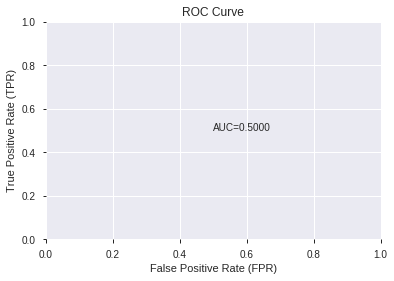

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


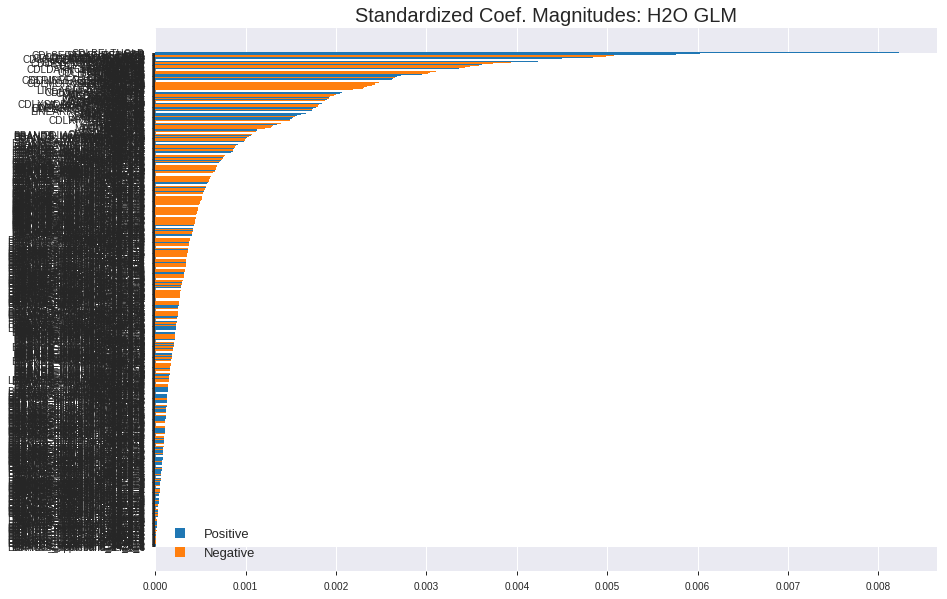

'log_likelihood'
--2019-08-24 00:58:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_005753_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_005753_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLBELTHOLD',
 'BOP',
 'STOCHRSI_fastk',
 'BETA_24',
 'AD',
 'CDLSEPARATINGLINES',
 'COS',
 'CCI_8',
 'CDLHOMINGPIGEON',
 'BETA_20',
 'CDLGRAVESTONEDOJI',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLCLOSINGMARUBOZU',
 'ROCP_8',
 'CDLSPINNINGTOP',
 'ROCR_8',
 'ROCR100_8',
 'ROC_8',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'SUB',
 'STOCH_slowd',
 'aroonup_8',
 'ULTOSC',
 'CDLEVENINGSTAR',
 'day',
 'aroondown_8',
 'CDLONNECK',
 'CORREL_20',
 'TRANGE',
 'TANH',
 'aroondown_12',
 'CDLDARKCLOUDCOVER',
 'BETA_14',
 'HT_TRENDMODE',
 'MOM_20',
 'is_month_start',
 'CORREL_14',
 'CORREL_8',
 'CDLHIKKAKEMOD',
 'CCI_14',
 'MFI_8',
 'ADX_24',
 'MOM_30',
 'TAN',
 'ADX_20',
 'BETA_30',
 'WILLR_14',
 'MFI_30',
 'CDLTAKURI',
 'CORREL_30',
 'CDLINNECK',
 'RSI_8',
 'PLUS_DI_8',
 'CMO_8',
 'CDLINVERTEDHAMMER',
 'CDLRISEFALL3METHODS',
 'is_quarter_end',
 'CDLPIERCING',
 'STOCHF_fastk',
 'CCI_12',
 'CDLMORNINGDOJISTAR',
 'VAR_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'MINUS_DI_8',
 'MOM_14',


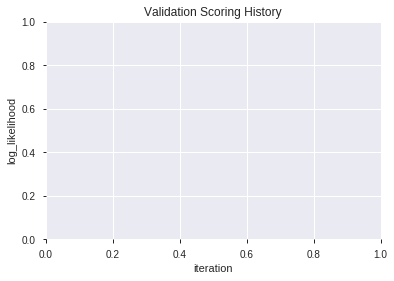

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_005923  0.582561  0.712213              0.500000  0.508323  0.258392
1               XGBoost_2_AutoML_20190824_005923  0.577174  0.690014              0.465596  0.498391  0.248394
2  XGBoost_grid_1_AutoML_20190824_005923_model_3  0.571213  0.708440              0.469870  0.506887  0.256934
3  XGBoost_grid_1_AutoML_20190824_005923_model_6  0.567981  0.724305              0.482762  0.514024  0.264221
4  XGBoost_grid_1_AutoML_20190824_005923_model_1  0.560799  0.731827              0.447928  0.516756  0.267036
5  XGBoost_grid_1_AutoML_20190824_005923_model_2  0.559290  0.690829              0.491309  0.498787  0.248788
6               XGBoost_1_AutoML_20190824_005923  0.555125  0.705350              0.500000  0.505211  0.255239
7  XGBoost_grid_1_AutoML_20190824_005923_model_7  0.544997  0.735197              0.500000  0.517852  0.268171
8  XGBoost_grid_1_AutoML_20190824_005923_model_4  0.538677  0.692343              0.491453  0.499579  0.249579
9  XGBoost_grid_1_AutoML_20190824_005923_model_5  0.537959  0.764871              0.487179  0.530545  0.281478

variable  relative_importance  scaled_importance  percentage
0                   CORREL_8           217.112396           1.000000    0.037901
1                        BOP           145.490707           0.670117    0.025398
2                   STDDEV_8           117.768745           0.542432    0.020559
3                     Volume           102.073586           0.470142    0.017819
4                     MFI_24            98.646629           0.454357    0.017220
..                       ...                  ...                ...         ...
296                  KAMA_30             0.515125           0.002373    0.000090
297  BBANDS_upperband_24_1_4             0.513648           0.002366    0.000090
298   BBANDS_lowerband_8_0_2             0.267888           0.001234    0.000047
299              MIDPRICE_14             0.148647           0.000685    0.000026
300  BBANDS_upperband_24_5_4             0.008625           0.000040    0.000002

[301 rows x 4 columns]

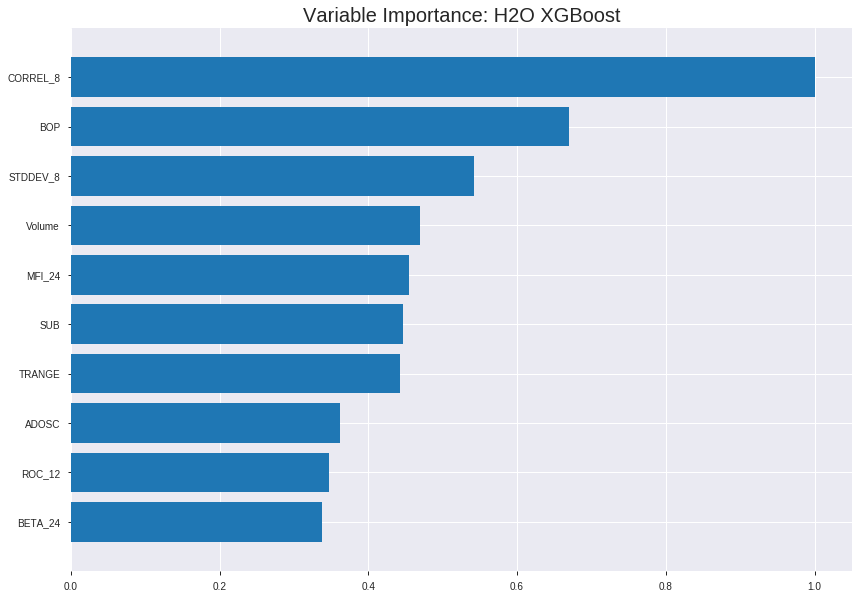

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_005923


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16944291287456456
RMSE: 0.41163444082652334
LogLoss: 0.5262621830520455
Mean Per-Class Error: 0.10989682284079927
AUC: 0.9548023767384554
pr_auc: 0.9599394758285786
Gini: 0.9096047534769107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.523373544216156: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      656  102  0.1346   (102.0/758.0)
1      77   816  0.0862   (77.0/893.0)
Total  733  918  0.1084   (179.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.523374     0.90116   212
max f2                       0.472457     0.931299  256
max f0point5                 0.559643     0.911256  182
max accuracy                 0.526272     0.891581  209
max precision                0.835084     1         0
max recall                   0.391157     1         323
max specificity              0.835084     1         0
max absolute_mcc             0.523374     0.781522  212
max min_per_class_accuracy   0.534894     0.888018  202
max mean_per_class_accuracy  0.526272     0.890103  209

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 53.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.75803            1.84882   1.84882            1                0.776468  1                           0.776468            0.019037        0.019037                   84.8824   84.8824
    2        0.0205936                   0.749113           1.84882   1.84882            1                0.753583  1                           0.765025            0.019037        0.0380739                  84.8824   84.8824
    3        0.0302847                   0.740859           1.84882   1.84882            1                0.744975  1                           0.758609            0.0179171       0.055991                   84.8824   84.8824
    4        0.0405815                   0.72979            1.84882   1.84882            1                0.734812  1                           0.752571            0.019037        0.075028                   84.8824   84.8824
    5        0.0502726                   0.719415           1.84882   1.84882            1                0.724259  1                           0.747113            0.0179171       0.0929451                  84.8824   84.8824
    6        0.100545                    0.691309           1.84882   1.84882            1                0.703517  1                           0.725315            0.0929451       0.18589                    84.8824   84.8824
    7        0.150212                    0.672023           1.84882   1.84882            1                0.681014  1                           0.710667            0.0918253       0.277716                   84.8824   84.8824
    8        0.200485                    0.653252           1.82655   1.84324            0.987952         0.662449  0.996979                    0.698576            0.0918253       0.369541                   82.6549   84.3239
    9        0.300424                    0.61598            1.71436   1.80037            0.927273         0.63391   0.97379                     0.677064            0.171333        0.540873                   71.4364   80.0367
    10       0.400363                    0.583477           1.68075   1.77051            0.909091         0.598969  0.95764                     0.65757             0.167973        0.708847                   68.0749   77.0508
    11       0.500303                    0.545857           1.45665   1.70781            0.787879         0.565337  0.923729                    0.639146            0.145577        0.854423                   45.6649   70.7812
    12       0.600242                    0.503587           0.8964    1.57271            0.484848         0.525308  0.850656                    0.620192            0.0895857       0.944009                   -10.36    57.2713
    13       0.700182                    0.462684           0.369765  1.40101            0.2              0.483439  0.757785                    0.600673            0.0369541       0.980963                   -63.0235  40.1012
    14       0.800121                    0.419795           0.13446   1.24281            0.0727273        0.441872  0.672218                    0.580838            0.0134378       0.994401                   -86.554   24.2813
    15       0.900061                    0.372019           0.056025  1.11104            0.030303         0.395525  0.600942                    0.560261            0.0055991       1                          -94.3975  11.1036
    16       1                           0.146889           0         1                  0                0.323448  0.540884                    0.536594         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2623055552139101
RMSE: 0.5121577444634711
LogLoss: 0.7203744869774132
Mean Per-Class Error: 0.454205943082862
AUC: 0.5378938863452734
pr_auc: 0.5212587870832283
Gini: 0.0757877726905467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2104119211435318: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    229  0.9662   (229.0/237.0)
1      3    232  0.0128   (3.0/235.0)
Total  11   461  0.4915   (232.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.210412     0.666667   389
max f2                       0.175899     0.832743   398
max f0point5                 0.247277     0.561048   375
max accuracy                 0.449611     0.54661    129
max precision                0.683078     1          0
max recall                   0.175899     1          398
max specificity              0.683078     1          0
max absolute_mcc             0.449611     0.0996118  129
max min_per_class_accuracy   0.398847     0.518987   201
max mean_per_class_accuracy  0.447864     0.545794   131

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 39.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.623452           1.20511   1.20511            0.6              0.654345  0.6                         0.654345            0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.588119           0.803404  1.00426            0.4              0.607585  0.5                         0.630965            0.00851064      0.0212766                  -19.6596  0.425532
    3        0.0317797                   0.576277           0.803404  0.937305           0.4              0.581302  0.466667                    0.614411            0.00851064      0.0297872                  -19.6596  -6.2695
    4        0.0402542                   0.564823           1.00426   0.9514             0.5              0.569648  0.473684                    0.604987            0.00851064      0.0382979                  0.425532  -4.86002
    5        0.0508475                   0.55904            0.803404  0.920567           0.4              0.562693  0.458333                    0.596176            0.00851064      0.0468085                  -19.6596  -7.94326
    6        0.101695                    0.5191             1.08794   1.00426            0.541667         0.537829  0.5                         0.567002            0.0553191       0.102128                   8.79433   0.425532
    7        0.150424                    0.496927           1.22257   1.07498            0.608696         0.508996  0.535211                    0.548211            0.0595745       0.161702                   22.2572   7.49775
    8        0.201271                    0.478831           1.17163   1.0994             0.583333         0.486638  0.547368                    0.532656            0.0595745       0.221277                   17.1631   9.93953
    9        0.300847                    0.449616           1.23929   1.1457             0.617021         0.464293  0.570423                    0.510029            0.123404        0.344681                   23.9294   14.57
    10       0.400424                    0.424714           0.683748  1.03082            0.340426         0.436302  0.513228                    0.491694            0.0680851       0.412766                   -31.6252  3.08229
    11       0.5                         0.398146           1.06836   1.0383             0.531915         0.410101  0.516949                    0.475445            0.106383        0.519149                   6.83567   3.82979
    12       0.599576                    0.375317           0.982888  1.0291             0.489362         0.385731  0.512367                    0.460545            0.0978723       0.617021                   -1.71118  2.90956
    13       0.699153                    0.353343           1.06836   1.03469            0.531915         0.366554  0.515152                    0.447159            0.106383        0.723404                   6.83567   3.46873
    14       0.798729                    0.313056           0.89742   1.01757            0.446809         0.337424  0.506631                    0.433478            0.0893617       0.812766                   -10.258   1.75744
    15       0.898305                    0.276474           1.02562   1.01847            0.510638         0.29521   0.507075                    0.418151            0.102128        0.914894                   2.56225   1.84665
    16       1                           0.165365           0.836879  1                  0.416667         0.238033  0.497881                    0.399834       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 00:59:34  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.459116                         0.5                0.693147              0.5               0                    1                  0.502119
    2019-08-24 00:59:34  0.561 sec   5                  0.486652         0.666751            0.797531        0.811716           1.84882          0.283465                         0.499285           0.691719              0.546647          0.538836             1.60681            0.5
    2019-08-24 00:59:34  0.742 sec   10                 0.475221         0.64453             0.848279        0.861455           1.84882          0.254391                         0.499091           0.691344              0.551207          0.551002             1.20511            0.495763
    2019-08-24 00:59:34  0.913 sec   15                 0.46567          0.626173            0.867352        0.873684           1.84882          0.213204                         0.499854           0.692902              0.54899           0.545881             1.20511            0.502119
    2019-08-24 00:59:35  1.085 sec   20                 0.45575          0.607388            0.894698        0.898187           1.84882          0.175651                         0.502191           0.697764              0.545722          0.541898             1.60681            0.480932
    2019-08-24 00:59:35  1.248 sec   25                 0.448084         0.592963            0.911893        0.91541            1.84882          0.162326                         0.504566           0.70282               0.544681          0.533947             1.60681            0.502119
    2019-08-24 00:59:35  1.404 sec   30                 0.441673         0.580978            0.919788        0.922824           1.84882          0.155663                         0.505783           0.705563              0.536556          0.530344             1.20511            0.480932
    2019-08-24 00:59:35  1.570 sec   35                 0.434223         0.56719             0.930523        0.933884           1.84882          0.136281                         0.506878           0.708062              0.540273          0.53284              1.60681            0.483051
    2019-08-24 00:59:35  1.736 sec   40                 0.426501         0.553046            0.941107        0.945679           1.84882          0.124773                         0.508128           0.710904              0.53995           0.532422             1.60681            0.483051
    2019-08-24 00:59:35  1.913 sec   45                 0.417854         0.537413            0.949553        0.954179           1.84882          0.112053                         0.511454           0.718396              0.540255          0.519726             1.20511            0.485169
    2019-08-24 00:59:36  2.075 sec   50                 0.411634         0.526262            0.954802        0.959939           1.84882          0.108419                         0.512158           0.720374              0.537894          0.521259             1.20511            0.491525

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
CORREL_8                 217.11239624023438     1.0                    0.03790076080682623
BOP                      145.49070739746094     0.6701169989228796     0.02539794408876429
STDDEV_8                 117.76874542236328     0.5424321570844459     0.020558591439588377
Volume                   102.0735855102539      0.4701416744408722     0.017818727148304264
MFI_24                   98.6466293334961       0.4543574251943856     0.017220492093097853
---                      ---                    ---                    ---
KAMA_30                  0.5151252746582031     0.002372620281378214   8.992411376994044e-05
BBANDS_upperband_24_1_4  0.5136480331420898     0.002365816240974741   8.966623546208844e-05
BBANDS_lowerband_8_0_2   0.26788806915283203    0.0012338681429153152  4.6764541351796244e-05
MIDPRICE_14              0.14864730834960938    0.0006846560165322457  2.594898391754311e-05
BBANDS_upperband_24_5_4  0.008625030517578125   3.97261080755359e-05   1.5056497199570141e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6016949152542372)

('F1', 0.6704225352112676)

('auc', 0.5825612296200532)

('logloss', 0.7122130638937835)

('mean_per_class_error', 0.39854916325504564)

('rmse', 0.5083230470213262)

('mse', 0.25839232013304547)

xgboost prediction progress: |████████████████████████████████████████████| 100%


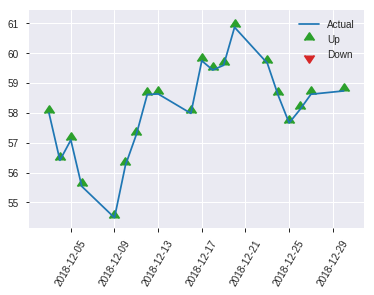


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25839232013304547
RMSE: 0.5083230470213262
LogLoss: 0.7122130638937835
Mean Per-Class Error: 0.39854916325504564
AUC: 0.5825612296200532
pr_auc: 0.5977192864323835
Gini: 0.16512245924010638
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2207333743572235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    117  1        (117.0/117.0)
1      0    119  0        (0.0/119.0)
Total  0    236  0.4958   (117.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.220733     0.670423  235
max f2                       0.220733     0.835674  235
max f0point5                 0.389256     0.605816  124
max accuracy                 0.389256     0.601695  124
max precision                0.51395      0.9       9
max recall                   0.220733     1         235
max specificity              0.590837     0.991453  0
max absolute_mcc             0.499254     0.210704  16
max min_per_class_accuracy   0.392349     0.581197  118
max mean_per_class_accuracy  0.389256     0.601451  124

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 39.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.547683           1.32213   1.32213            0.666667         0.568488  0.666667                    0.568488            0.0168067       0.0168067                  32.2129    32.2129
    2        0.0211864                   0.526501           1.98319   1.58655            1                0.539355  0.8                         0.556835            0.0168067       0.0336134                  98.3193    58.6555
    3        0.0338983                   0.522277           1.98319   1.73529            1                0.523569  0.875                       0.54436             0.0252101       0.0588235                  98.3193    73.5294
    4        0.0423729                   0.512858           1.98319   1.78487            1                0.513967  0.9                         0.538282            0.0168067       0.0756303                  98.3193    78.4874
    5        0.0508475                   0.505067           0.991597  1.65266            0.5              0.508663  0.833333                    0.533345            0.00840336      0.0840336                  -0.840336  65.2661
    6        0.101695                    0.486079           1.48739   1.57003            0.75             0.496332  0.791667                    0.514839            0.0756303       0.159664                   48.7395    57.0028
    7        0.152542                    0.469342           0.661064  1.26704            0.333333         0.47801   0.638889                    0.502563            0.0336134       0.193277                   -33.8936   26.704
    8        0.20339                     0.457615           0.991597  1.19818            0.5              0.462213  0.604167                    0.492475            0.0504202       0.243697                   -0.840336  19.8179
    9        0.300847                    0.432933           1.03471   1.14522            0.521739         0.445617  0.577465                    0.477296            0.10084         0.344538                   3.47095    14.5224
    10       0.402542                    0.410356           1.2395    1.16904            0.625            0.421458  0.589474                    0.463189            0.12605         0.470588                   23.9496    16.904
    11       0.5                         0.392477           1.12094   1.15966            0.565217         0.400607  0.584746                    0.450991            0.109244        0.579832                   12.0935    15.9664
    12       0.601695                    0.376116           0.908964  1.11729            0.458333         0.384901  0.56338                     0.439821            0.092437        0.672269                   -9.10364   11.7292
    13       0.699153                    0.357331           0.603581  1.04568            0.304348         0.366465  0.527273                    0.429596            0.0588235       0.731092                   -39.6419   4.56837
    14       0.800847                    0.340332           0.826331  1.01783            0.416667         0.349494  0.513228                    0.419424            0.0840336       0.815126                   -17.3669   1.78294
    15       0.898305                    0.285418           0.862258  1.00095            0.434783         0.316639  0.504717                    0.408273            0.0840336       0.89916                    -13.7742   0.0951324
    16       1                           0.220733           0.991597  1                  0.5              0.255956  0.504237                    

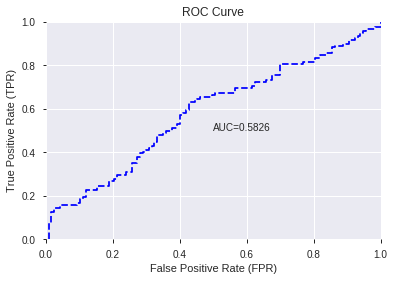

This function is available for GLM models only


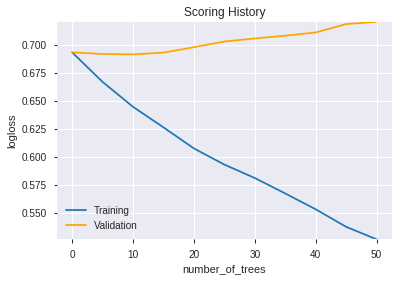

--2019-08-24 01:00:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_005923',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_005923',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_b870',
   'type

['CORREL_8',
 'BOP',
 'STDDEV_8',
 'Volume',
 'MFI_24',
 'SUB',
 'TRANGE',
 'ADOSC',
 'ROC_12',
 'BETA_24',
 'SIN',
 'AD',
 'DIV',
 'HT_PHASOR_inphase',
 'STOCHF_fastk',
 'MACDEXT_hist',
 'day',
 'COS',
 'MOM_12',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'MFI_30',
 'WILLR_14',
 'CORREL_12',
 'STOCHRSI_fastk',
 'MACDFIX_hist_8',
 'ROC_30',
 'MFI_12',
 'BETA_8',
 'TAN',
 'ADXR_8',
 'NATR_20',
 'MFI_14',
 'CORREL_24',
 'NATR_8',
 'WILLR_8',
 'MOM_20',
 'PLUS_DI_8',
 'ADX_20',
 'PLUS_DI_14',
 'ULTOSC',
 'BETA_12',
 'DX_8',
 'MACDFIX_signal_20',
 'CCI_12',
 'CMO_20',
 'BBANDS_upperband_30_7_2',
 'CCI_8',
 'ADXR_14',
 'BETA_20',
 'ADX_24',
 'MFI_20',
 'PLUS_DM_24',
 'MINUS_DI_8',
 'CORREL_14',
 'STOCH_slowk',
 'CMO_12',
 'STOCHRSI_fastd',
 'LINEARREG_ANGLE_30',
 'ATR_24',
 'LINEARREG_ANGLE_8',
 'CORREL_20',
 'ADXR_12',
 'MACDFIX_signal_14',
 'MOM_8',
 'dayofyear',
 'STOCH_slowd',
 'SAREXT',
 'ADX_8',
 'ATR_14',
 'aroondown_8',
 'ROC_8',
 'STDDEV_12',
 'TRIX_12',
 'ATR_30',
 'WILLR_30',
 'BBANDS

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

54

['MA_20_0',
 'BBANDS_upperband_20_6_5',
 'BOP',
 'ADX_8',
 'aroondown_8',
 'CCI_8',
 'DX_8',
 'PLUS_DM_8',
 'ROCP_8',
 'WILLR_8',
 'ADX_12',
 'CMO_12',
 'ROCP_12',
 'ROCR100_12',
 'AROONOSC_14',
 'MINUS_DI_14',
 'PLUS_DI_14',
 'TRIX_14',
 'WILLR_14',
 'ADX_20',
 'aroonup_20',
 'CCI_20',
 'CMO_20',
 'MFI_20',
 'MOM_20',
 'ADX_24',
 'MACDFIX_hist_24',
 'MFI_24',
 'MOM_24',
 'PLUS_DM_24',
 'ROC_24',
 'ROCR100_24',
 'aroondown_30',
 'CCI_30',
 'MOM_30',
 'PLUS_DI_30',
 'PLUS_DM_30',
 'ROC_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'NATR_8',
 'TRANGE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLHIKKAKE',
 'CDLSPINNINGTOP',
 'CORREL_8',
 'CORREL_12',
 'LINEARREG_INTERCEPT_12',
 'LINEARREG_SLOPE_12',
 'VAR_12',
 'BETA_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_010208_model_1  0.612009  1.288980              0.487179  0.569477  0.324304
1  DeepLearning_grid_1_AutoML_20190824_010208_model_2  0.606838  2.222885              0.452704  0.651868  0.424932
2  DeepLearning_grid_1_AutoML_20190824_010208_model_3  0.600373  1.561139              0.482906  0.646979  0.418582
3  DeepLearning_grid_1_AutoML_20190824_010208_model_6  0.588451  0.687123              0.452561  0.496966  0.246975
4  DeepLearning_grid_1_AutoML_20190824_010208_model_8  0.575882  0.688729              0.417726  0.497789  0.247793
5  DeepLearning_grid_1_AutoML_20190824_010208_model_5  0.572219  0.689446              0.487179  0.498020  0.248024
6  DeepLearning_grid_1_AutoML_20190824_010208_model_4  0.571716  0.950266              0.495726  0.555763  0.308873
7  DeepLearning_grid_1_AutoML_20190824_010208_model_7  0.570998  0.795435              0.461036  0.539683  0.291258
8               DeepLearning_1_AutoML_20190824_010208  0.566545  0.711626              0.487179  0.508386  0.258456
9  DeepLearning_grid_1_AutoML_20190824_010208_model_9  0.549881  0.689807              0.474359  0.498334  0.248336

variable  relative_importance  scaled_importance  percentage
0                  CORREL_8             1.000000           1.000000    0.022217
1                       BOP             0.994722           0.994722    0.022100
2                 CORREL_12             0.976247           0.976247    0.021690
3                    TRANGE             0.975030           0.975030    0.021663
4               aroondown_8             0.974533           0.974533    0.021651
5                    VAR_12             0.972701           0.972701    0.021611
6                   BETA_14             0.940093           0.940093    0.020886
7                aroonup_20             0.932436           0.932436    0.020716
8         HT_PHASOR_inphase             0.924331           0.924331    0.020536
9      HT_PHASOR_quadrature             0.912995           0.912995    0.020284
10                   NATR_8             0.897678           0.897678    0.019944
11             aroondown_30             0.879150           0.879150    0.019532
12           CDLSPINNINGTOP             0.871210           0.871210    0.019356
13               CDLHIKKAKE             0.868217           0.868217    0.019289
14             STOCHF_fastk             0.867870           0.867870    0.019282
15                     DX_8             0.860314           0.860314    0.019114
16                    ADX_8             0.854822           0.854822    0.018992
17              AROONOSC_14             0.848306           0.848306    0.018847
18                   ADX_24             0.842157           0.842157    0.018710
19                   MOM_30             0.835472           0.835472    0.018562
20                   ADX_12             0.833120           0.833120    0.018510
21               PLUS_DM_30             0.832578           0.832578    0.018498
22              STOCH_slowd             0.824558           0.824558    0.018319
23               PLUS_DM_24             0.824483           0.824483    0.018318
24              STOCH_slowk             0.822042           0.822042    0.018264
25                   ADX_20             0.816795           0.816795    0.018147
26                PLUS_DM_8             0.815047           0.815047    0.018108
27                   MOM_20             0.814017           0.814017    0.018085
28                  WILLR_8             0.806932           0.806932    0.017928
29          MACDFIX_hist_24             0.797799           0.797799    0.017725
30                   ROCP_8             0.797133           0.797133    0.017710
31                 WILLR_30             0.796198           0.796198    0.017689
32   LINEARREG_INTERCEPT_12             0.794864           0.794864    0.017660
33                  ROCP_12             0.794512           0.794512    0.017652
34                   MFI_24             0.793823           0.793823    0.017637
35               PLUS_DI_30             0.792444           0.792444    0.017606
36                   ROC_24             0.790889           0.790889    0.017571
37                   MFI_20             0.787776           0.787776    0.017502
38               PLUS_DI_14             0.781551           0.781551    0.017364
39       LINEARREG_SLOPE_12             0.779642           0.779642    0.017322
40                  TRIX_14             0.778193           0.778193    0.017289
41                    CCI_8             0.776886           0.776886    0.017260
42  BBANDS_upperband_20_6_5             0.775103           0.775103    0.017221
43              MINUS_DI_14             0.771051           0.771051    0.017131
44                 WILLR_14             0.769210           0.769210    0.017090
45                   CMO_20             0.766802           0.766802    0.017036
46                   ROC_30             0.766648           0.766648    0.017033
47                  MA_20_0             0.765786           0.765786    0.017014
48                   MOM_24             0.765432           0.765432    0.017006
49               RO

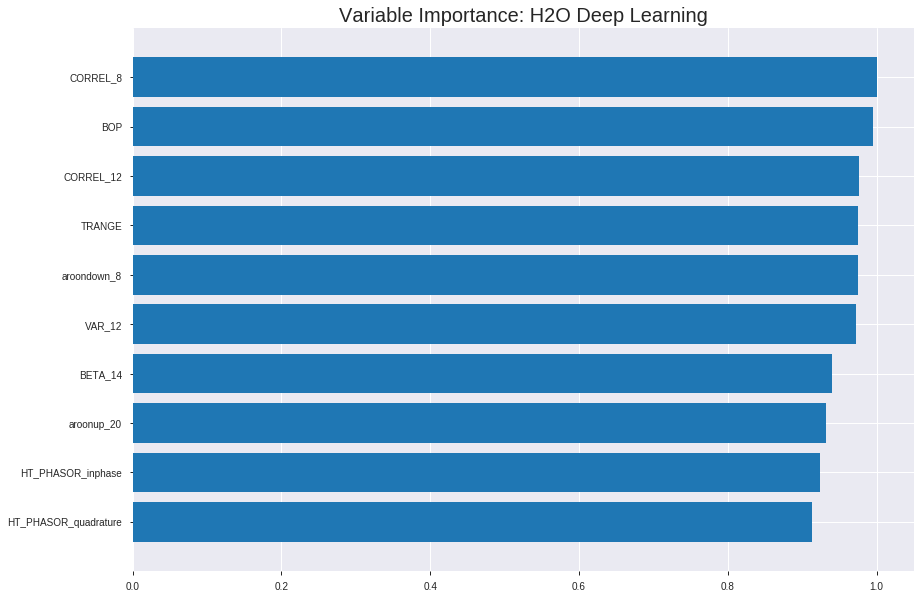

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_010208_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.29912346376665894
RMSE: 0.5469218077263504
LogLoss: 1.1601547461772603
Mean Per-Class Error: 0.3731950645152712
AUC: 0.6558959009830195
pr_auc: 0.6397435700611322
Gini: 0.31179180196603906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.003764265546419824: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      81   677   0.8931   (677.0/758.0)
1      36   857   0.0403   (36.0/893.0)
Total  117  1534  0.4319   (713.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00376427   0.706222  394
max f2                       0.000166901  0.854873  399
max f0point5                 0.283911     0.657923  264
max accuracy                 0.283911     0.631133  264
max precision                0.997448     0.75      3
max recall                   0.000166901  1         399
max specificity              0.999784     0.98153   0
max absolute_mcc             0.283911     0.254811  264
max min_per_class_accuracy   0.377978     0.621372  234
max mean_per_class_accuracy  0.283911     0.626805  264

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 46.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.999952           1.52256   1.52256            0.823529         0.999977    0.823529                    0.999977            0.0156775       0.0156775                  52.2561   52.2561
    2        0.0205936                   0.999675           1.30505   1.41381            0.705882         0.999821    0.764706                    0.999899            0.0134378       0.0291153                  30.5052   41.3807
    3        0.0302847                   0.99931            1.15552   1.33115            0.625            0.999512    0.72                        0.999775            0.0111982       0.0403135                  15.5515   33.1153
    4        0.0405815                   0.99856            1.41381   1.35213            0.764706         0.998968    0.731343                    0.999571            0.0145577       0.0548712                  41.3807   35.2125
    5        0.0502726                   0.997253           1.38662   1.35877            0.75             0.997981    0.73494                     0.999264            0.0134378       0.0683091                  38.6618   35.8774
    6        0.100545                    0.983439           1.2474    1.30309            0.674699         0.991949    0.704819                    0.995607            0.06271         0.131019                   24.7399   30.3087
    7        0.150212                    0.959609           1.44298   1.34934            0.780488         0.972429    0.729839                    0.987943            0.0716685       0.202688                   44.2985   34.9343
    8        0.200485                    0.926974           1.3365    1.34612            0.722892         0.944636    0.728097                    0.977084            0.0671892       0.269877                   33.6499   34.6123
    9        0.300424                    0.817862           1.24375   1.31207            0.672727         0.875028    0.709677                    0.943134            0.1243          0.394177                   24.3754   31.2069
    10       0.400363                    0.634762           1.07568   1.25306            0.581818         0.736207    0.677761                    0.89148             0.107503        0.50168                    7.56795   25.3061
    11       0.500303                    0.398301           1.09809   1.2221             0.593939         0.513182    0.661017                    0.815912            0.109742        0.611422                   9.80895   22.2104
    12       0.600242                    0.224156           0.91881   1.17161            0.49697          0.304135    0.633703                    0.730702            0.0918253       0.703247                   -8.11904  17.1606
    13       0.700182                    0.110395           0.862785  1.12753            0.466667         0.160889    0.609862                    0.649371            0.0862262       0.789474                   -13.7215  12.7527
    14       0.800121                    0.0389048          0.80676   1.08746            0.436364         0.0695267   0.588191                    0.576945            0.0806271       0.870101                   -19.324   8.74613
    15       0.900061                    0.00749849         0.64989   1.03887            0.351515         0.0217487   0.561911                    0.515298            0.0649496       0.93505                    -35.011   3.8875
    16       1                           3.02024e-16        0.64989   1                  0.351515         0.00240858  0.540884  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3974877483780241
RMSE: 0.6304662944028206
LogLoss: 1.9483554211141179
Mean Per-Class Error: 0.46132507406409917
AUC: 0.5025855103689739
pr_auc: 0.5230799392209139
Gini: 0.00517102073794784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.7616946257156613e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    235  0        (0.0/235.0)
Total  0    472  0.5021   (237.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.76169e-06  0.664781  399
max f2                       3.76169e-06  0.832153  399
max f0point5                 3.76169e-06  0.553462  399
max accuracy                 0.870119     0.540254  58
max precision                0.998045     1         0
max recall                   3.76169e-06  1         399
max specificity              0.998045     1         0
max absolute_mcc             0.870119     0.116103  58
max min_per_class_accuracy   0.150429     0.489451  233
max mean_per_class_accuracy  0.870119     0.538675  58

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 31.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.992985           1.20511   1.20511            0.6              0.99593      0.6                         0.99593             0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.986154           1.20511   1.20511            0.6              0.989479     0.6                         0.992705            0.012766        0.0255319                  20.5106   20.5106
    3        0.0317797                   0.980416           1.60681   1.33901            0.8              0.983113     0.666667                    0.989507            0.0170213       0.0425532                  60.6809   33.9007
    4        0.0402542                   0.972812           1.00426   1.26853            0.5              0.97813      0.631579                    0.987112            0.00851064      0.0510638                  0.425532  26.8533
    5        0.0508475                   0.958664           1.20511   1.25532            0.6              0.964809     0.625                       0.982466            0.012766        0.0638298                  20.5106   25.5319
    6        0.101695                    0.895116           1.08794   1.17163            0.541667         0.924453     0.583333                    0.953459            0.0553191       0.119149                   8.79433   17.1631
    7        0.150424                    0.844018           1.3099    1.21642            0.652174         0.868917     0.605634                    0.926072            0.0638298       0.182979                   30.9898   21.6422
    8        0.201271                    0.700754           0.836879  1.12054            0.416667         0.786678     0.557895                    0.890857            0.0425532       0.225532                   -16.3121  12.0538
    9        0.300847                    0.466104           0.769217  1.00426            0.382979         0.583317     0.5                         0.789066            0.0765957       0.302128                   -23.0783  0.425532
    10       0.400424                    0.292674           0.89742   0.977688           0.446809         0.369172     0.486772                    0.684648            0.0893617       0.391489                   -10.258   -2.23123
    11       0.5                         0.154093           0.982888  0.978723           0.489362         0.227288     0.487288                    0.593563            0.0978723       0.489362                   -1.71118  -2.12766
    12       0.599576                    0.0556829          1.06836   0.99361            0.531915         0.103        0.4947                      0.512092            0.106383        0.595745                   6.83567   -0.63905
    13       0.699153                    0.0161997          0.940154  0.985996           0.468085         0.0334036    0.490909                    0.443915            0.093617        0.689362                   -5.98461  -1.40039
    14       0.798729                    0.00279671         0.982888  0.985609           0.489362         0.0083078    0.490716                    0.389608            0.0978723       0.787234                   -1.71118  -1.43913
    15       0.898305                    9.18348e-05        1.11109   0.999518           0.553191         0.00117361   0.497642                    0.346551            0.110638        0.897872                   11.1091   -0.0481734
    16       1                           3.62535e-07        1.00426   1                  0.5         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 01:02:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 01:02:18  8.317 sec         2010 obs/sec      10        1             16510      0.626621         1.8589              -0.581189      0.551848        0.54538            1.1963           0.445185                         0.658345           2.90605               -0.733704        0.511401          0.510431             1.20511            0.502119
    2019-08-24 01:02:25  15.793 sec        2114 obs/sec      20        2             33020      0.603661         1.50729             -0.467437      0.579433        0.573654           1.52256          0.446396                         0.650234           2.68805               -0.691248        0.509642          0.516034             1.20511            0.502119
    2019-08-24 01:02:32  22.725 sec        2204 obs/sec      30        3             49530      0.592195         1.46872             -0.412224      0.608115        0.616917           1.30505          0.440945                         0.662795           3.04785               -0.757219        0.518422          0.529141             1.60681            0.502119
    2019-08-24 01:02:39  29.302 sec        2279 obs/sec      40        4             66040      0.568021         1.26849             -0.299279      0.638439        0.643425           1.41381          0.448819                         0.654279           2.69717               -0.712353        0.512416          0.541412             2.00851            0.502119
    2019-08-24 01:02:46  35.871 sec        2327 obs/sec      50        5             82550      0.546922         1.16015             -0.204548      0.655896        0.639744           1.52256          0.431859                         0.630466           1.94836               -0.58998         0.502586          0.52308              1.20511            0.502119
    2019-08-24 01:02:52  42.298 sec        2368 obs/sec      60        6             99060      0.520003         0.983526            -0.088892      0.701359        0.695971           1.63132          0.381587                         0.640095           2.35824               -0.638916        0.514508          0.545051             2.00851            0.502119
    2019-08-24 01:02:58  48.568 sec        2406 obs/sec      70        7             115570     0.512426         0.980976            -0.0573899     0.706597        0.704382           1.52256          0.359176                         0.628363           2.26641               -0.579389        0.512209          0.538899             1.60681            0.502119
    2019-08-24 01:03:04  54.798 sec        2437 obs/sec      80        8             132080     0.490876         0.87683             0.0296744      0.742389        0.728338           1.74007          0.33192                          0.655244           2.78025               -0.71741         0.530604          0.541435             1.60681            0.502119
    2019-08-24 01:03:10

Variable Importances: 


variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  --------------------
CORREL_8     1.0                    1.0                  0.022217277167564976
BOP          0.994722306728363      0.994722306728363    0.022100021193343627
CORREL_12    0.9762470126152039     0.9762470126152039   0.02168955046327929
TRANGE       0.9750301241874695     0.9750301241874695   0.02166251451579831
aroondown_8  0.9745331406593323     0.9745331406593323   0.021651472895005974
---          ---                    ---                  ---
ROCR100_24   0.7630231976509094     0.7630231976509094   0.01695229786749197
ROCR100_12   0.7552279829978943     0.7552279829978943   0.016779109422965267
CCI_30       0.7548827528953552     0.7548827528953552   0.01677143935009057
CCI_20       0.7435619831085205     0.7435619831085205   0.016519922669986267
CMO_12       0.733722448348999      0.733722448348999    0.01630131499903409


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6186440677966102)

('F1', 0.6761363636363636)

('auc', 0.6120089061265531)

('logloss', 1.2889801550514193)

('mean_per_class_error', 0.38044961574373337)

('rmse', 0.5694770445023368)

('mse', 0.32430410421511646)

deeplearning prediction progress: |███████████████████████████████████████| 100%


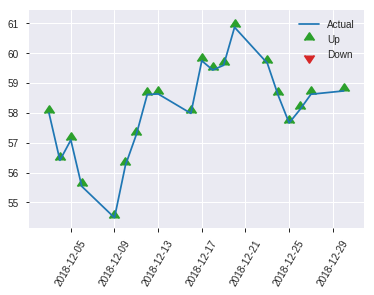


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.32430410421511646
RMSE: 0.5694770445023368
LogLoss: 1.2889801550514193
Mean Per-Class Error: 0.38044961574373337
AUC: 0.6120089061265531
pr_auc: 0.5950195113856894
Gini: 0.22401781225310624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.827965057879517e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    114  0.9744   (114.0/117.0)
1      0    119  0        (0.0/119.0)
Total  3    233  0.4831   (114.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.82797e-05  0.676136  232
max f2                       6.82797e-05  0.83921   232
max f0point5                 0.267538     0.621521  104
max accuracy                 0.361641     0.618644  92
max precision                0.994614     0.75      3
max recall                   6.82797e-05  1         232
max specificity              0.999514     0.991453  0
max absolute_mcc             0.361641     0.244646  92
max min_per_class_accuracy   0.178721     0.605042  117
max mean_per_class_accuracy  0.361641     0.61955   92

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 34.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.996497           1.32213   1.32213            0.666667         0.998615    0.666667                    0.998615            0.0168067       0.0168067                  32.2129    32.2129
    2        0.0211864                   0.985412           0.991597  1.18992            0.5              0.990027    0.6                         0.99518             0.00840336      0.0252101                  -0.840336  18.9916
    3        0.0338983                   0.981142           0.661064  0.991597           0.333333         0.983751    0.5                         0.990894            0.00840336      0.0336134                  -33.8936   -0.840336
    4        0.0423729                   0.974256           1.98319   1.18992            1                0.977959    0.6                         0.988307            0.0168067       0.0504202                  98.3193    18.9916
    5        0.0508475                   0.967322           1.98319   1.32213            1                0.971744    0.666667                    0.985547            0.0168067       0.0672269                  98.3193    32.2129
    6        0.101695                    0.921175           1.32213   1.32213            0.666667         0.94302     0.666667                    0.964283            0.0672269       0.134454                   32.2129    32.2129
    7        0.152542                    0.842196           1.32213   1.32213            0.666667         0.88055     0.666667                    0.936372            0.0672269       0.201681                   32.2129    32.2129
    8        0.20339                     0.755458           0.991597  1.2395             0.5              0.806491    0.625                       0.903902            0.0504202       0.252101                   -0.840336  23.9496
    9        0.300847                    0.561638           1.46584   1.31282            0.73913          0.661704    0.661972                    0.825443            0.142857        0.394958                   46.5839    31.2818
    10       0.402542                    0.354463           1.15686   1.27342            0.583333         0.451659    0.642105                    0.731014            0.117647        0.512605                   15.6863    27.3419
    11       0.5                         0.178321           0.948484  1.21008            0.478261         0.257866    0.610169                    0.63879             0.092437        0.605042                   -5.15163   21.0084
    12       0.601695                    0.0988114          0.578431  1.10333            0.291667         0.140449    0.556338                    0.554563            0.0588235       0.663866                   -42.1569   10.3326
    13       0.699153                    0.0507696          0.948484  1.08174            0.478261         0.072584    0.545455                    0.487378            0.092437        0.756303                   -5.15163   8.17418
    14       0.800847                    0.0177394          0.661064  1.02832            0.333333         0.0316192   0.518519                    0.429504            0.0672269       0.823529                   -33.8936   2.83224
    15       0.898305                    0.00315713         1.12094   1.03837            0.565217         0.00774696  0.523585                    0.383747            0.109244        0.932773                   12.0935    3.83701
    16       1                           7.35031e-07        0.661064  1                  0.333333         0.

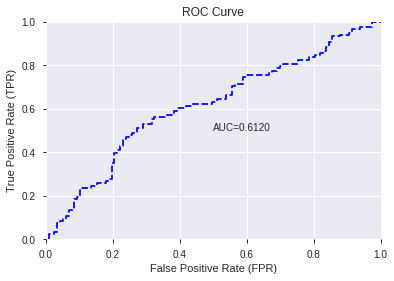

This function is available for GLM models only


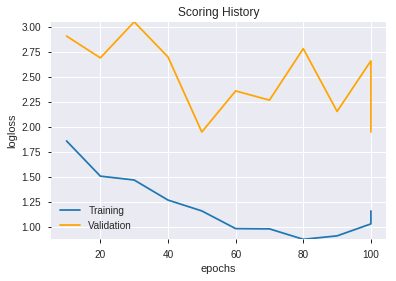

--2019-08-24 01:09:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.220
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_010208_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_010208_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_8',
 'BOP',
 'CORREL_12',
 'TRANGE',
 'aroondown_8',
 'VAR_12',
 'BETA_14',
 'aroonup_20',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'NATR_8',
 'aroondown_30',
 'CDLSPINNINGTOP',
 'CDLHIKKAKE',
 'STOCHF_fastk',
 'DX_8',
 'ADX_8',
 'AROONOSC_14',
 'ADX_24',
 'MOM_30',
 'ADX_12',
 'PLUS_DM_30',
 'STOCH_slowd',
 'PLUS_DM_24',
 'STOCH_slowk',
 'ADX_20',
 'PLUS_DM_8',
 'MOM_20',
 'WILLR_8',
 'MACDFIX_hist_24',
 'ROCP_8',
 'WILLR_30',
 'LINEARREG_INTERCEPT_12',
 'ROCP_12',
 'MFI_24',
 'PLUS_DI_30',
 'ROC_24',
 'MFI_20',
 'PLUS_DI_14',
 'LINEARREG_SLOPE_12',
 'TRIX_14',
 'CCI_8',
 'BBANDS_upperband_20_6_5',
 'MINUS_DI_14',
 'WILLR_14',
 'CMO_20',
 'ROC_30',
 'MA_20_0',
 'MOM_24',
 'ROCR100_24',
 'ROCR100_12',
 'CCI_30',
 'CCI_20',
 'CMO_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error    rmse       mse
0  GLM_grid_1_AutoML_20190824_011034_model_1  0.596854  0.68435              0.422215  0.4956  0.245619

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.037714           1.000000    0.060017
1                    ROCP_8             0.033030           0.875800    0.052563
2                     CCI_8             0.029142           0.772706    0.046375
3               STOCH_slowd             0.027261           0.722841    0.043383
4            CDLSPINNINGTOP             0.022553           0.598018    0.035891
5                    TRANGE             0.021817           0.578502    0.034720
6               aroondown_8             0.021449           0.568731    0.034134
7                   BETA_14             0.021041           0.557925    0.033485
8                    MOM_20             0.020953           0.555578    0.033344
9                    MOM_30             0.019623           0.520310    0.031227
10                 CORREL_8             0.017000           0.450770    0.027054
11                   ROC_30             0.015514           0.411361    0.024689
12                 WILLR_14             0.014251           0.377866    0.022678
13                   ADX_24             0.014108           0.374072    0.022451
14              STOCH_slowk             0.014015           0.371619    0.022303
15                   ADX_20             0.013548           0.359246    0.021561
16              MINUS_DI_14             0.013374           0.354609    0.021283
17                CORREL_12             0.013108           0.347579    0.020861
18               PLUS_DI_14             0.012787           0.339048    0.020349
19       LINEARREG_SLOPE_12             0.012224           0.324127    0.019453
20                   MFI_24             0.012175           0.322835    0.019376
21  BBANDS_upperband_20_6_5             0.012021           0.318733    0.019129
22                   MFI_20             0.011736           0.311183    0.018676
23                   CMO_12             0.011431           0.303087    0.018190
24          MACDFIX_hist_24             0.011409           0.302512    0.018156
25               PLUS_DI_30             0.010582           0.280592    0.016840
26                  TRIX_14             0.010501           0.278433    0.016711
27        HT_PHASOR_inphase             0.010085           0.267418    0.016050
28             STOCHF_fastk             0.009815           0.260256    0.015620
29               PLUS_DM_30             0.009395           0.249111    0.014951
30                     DX_8             0.009283           0.246131    0.014772
31                  MA_20_0             0.009261           0.245562    0.014738
32                   CMO_20             0.008888           0.235668    0.014144
33                  ROCP_12             0.008678           0.230104    0.013810
34                    ADX_8             0.008670           0.229892    0.013797
35               ROCR100_12             0.008654           0.229463    0.013772
36             aroondown_30             0.008494           0.225222    0.013517
37                  WILLR_8             0.008304           0.220183    0.013215
38               PLUS_DM_24             0.007809           0.207061    0.012427
39   LINEARREG_INTERCEPT_12             0.007806           0.206991    0.012423
40                   VAR_12             0.007587           0.201177    0.012074
41                   CCI_30             0.006158           0.163294    0.009800
42                   CCI_20             0.004731           0.125436    0.007528
43               CDLHIKKAKE             0.004493           0.119147    0.007151
44                   ROC_24             0.003665           0.097188    0.005833
45               ROCR100_24             0.003626           0.096153    0.005771
46                 WILLR_30             0.002559           0.067840    0.004072
47                PLUS_DM_8             0.001991           0.052787    0.003168
48                   NATR_8             0.001442           0.038226    0.002294
49                 

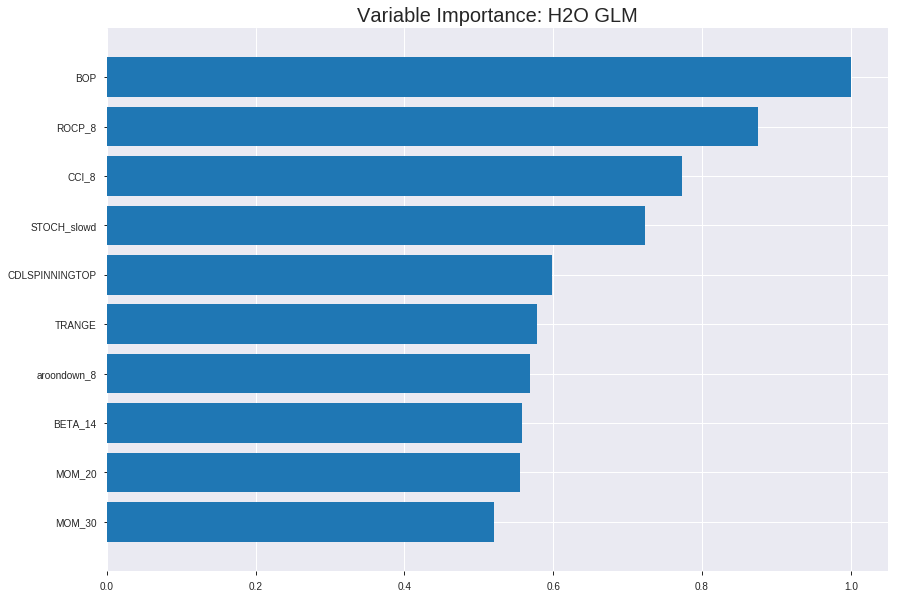

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_011034_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24446602233949966
RMSE: 0.49443505371231483
LogLoss: 0.6819729708807889
Null degrees of freedom: 1650
Residual degrees of freedom: 1596
Null deviance: 2277.720891745009
Residual deviance: 2251.874749848365
AIC: 2361.874749848365
AUC: 0.5849948440967123
pr_auc: 0.6100385214537484
Gini: 0.16998968819342464
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4588880599371089: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   743   0.9802   (743.0/758.0)
1      1    892   0.0011   (1.0/893.0)
Total  16   1635  0.4506   (744.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458888     0.705696  383
max f2                       0.458888     0.856539  383
max f0point5                 0.515017     0.61581   286
max accuracy                 0.521941     0.58086   263
max precision                0.606121     0.9       8
max recall                   0.342878     1         396
max specificity              0.649477     0.998681  0
max absolute_mcc             0.515017     0.141501  286
max min_per_class_accuracy   0.543495     0.557671  185
max mean_per_class_accuracy  0.548815     0.567601  166

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 54.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.599176           1.41381   1.41381            0.764706         0.613001  0.764706                    0.613001            0.0145577       0.0145577                  41.3807   41.3807
    2        0.0205936                   0.593536           1.30505   1.35943            0.705882         0.596332  0.735294                    0.604666            0.0134378       0.0279955                  30.5052   35.943
    3        0.0302847                   0.590335           1.03996   1.2572             0.5625           0.592058  0.68                        0.600632            0.0100784       0.0380739                  3.99636   25.72
    4        0.0405815                   0.587138           0.978789  1.18656            0.529412         0.588562  0.641791                    0.597569            0.0100784       0.0481523                  -2.12107  18.6559
    5        0.0502726                   0.584977           1.27107   1.20285            0.6875           0.586239  0.650602                    0.595385            0.012318        0.0604703                  27.1067   20.2849
    6        0.100545                    0.576661           1.2474    1.22512            0.674699         0.580361  0.662651                    0.587873            0.06271         0.12318                    24.7399   22.5124
    7        0.150212                    0.570515           1.14988   1.20024            0.621951         0.573371  0.649194                    0.583078            0.0571109       0.180291                   14.9878   20.0245
    8        0.200485                    0.566287           1.1583    1.18973            0.626506         0.56839   0.643505                    0.579395            0.0582307       0.238522                   15.8299   18.9727
    9        0.300424                    0.55778            1.07568   1.15179            0.581818         0.561822  0.622984                    0.573549            0.107503        0.346025                   7.56795   15.1788
    10       0.400363                    0.550165           1.07568   1.13279            0.581818         0.554049  0.612708                    0.568682            0.107503        0.453527                   7.56795   13.2789
    11       0.500303                    0.543526           1.01965   1.11019            0.551515         0.547159  0.600484                    0.564382            0.101904        0.555431                   1.96546   11.019
    12       0.600242                    0.535918           0.8964    1.07459            0.484848         0.539702  0.581231                    0.560273            0.0895857       0.645017                   -10.36    7.45941
    13       0.700182                    0.527498           1.08688   1.07635            0.587879         0.531538  0.58218                     0.556172            0.108623        0.753639                   8.68845   7.63483
    14       0.800121                    0.518357           0.952425  1.06087            0.515152         0.522902  0.573808                    0.552016            0.0951848       0.848824                   -4.75754  6.08696
    15       0.900061                    0.50321            0.82917   1.03514            0.448485         0.510682  0.559892                    0.547426            0.0828667       0.931691                   -17.083   3.51425
    16       1                           0.219757           0.683505  1                  0.369697         0.481966  0.540884                    0.540884            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2485501300815749
RMSE: 0.49854802184100067
LogLoss: 0.690252088022114
Null degrees of freedom: 471
Residual degrees of freedom: 417
Null deviance: 657.825185254164
Residual deviance: 651.5979710928756
AIC: 761.5979710928756
AUC: 0.5501660831313404
pr_auc: 0.5468605224404969
Gini: 0.10033216626268082
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3837479011942661: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    236  0.9958   (236.0/237.0)
1      0    235  0        (0.0/235.0)
Total  1    471  0.5      (236.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383748     0.665722  398
max f2                       0.383748     0.832743  398
max f0point5                 0.484132     0.55805   274
max accuracy                 0.508865     0.548729  153
max precision                0.547931     0.75      24
max recall                   0.383748     1         398
max specificity              0.582305     0.995781  0
max absolute_mcc             0.547931     0.126627  24
max min_per_class_accuracy   0.500908     0.531646  200
max mean_per_class_accuracy  0.50574      0.548406  170

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 49.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.565407           0.803404  0.803404           0.4              0.575818  0.4                         0.575818            0.00851064      0.00851064                 -19.6596  -19.6596
    2        0.0211864                   0.560137           1.60681   1.20511            0.8              0.562232  0.6                         0.569025            0.0170213       0.0255319                  60.6809   20.5106
    3        0.0317797                   0.557179           1.20511   1.20511            0.6              0.558293  0.6                         0.565448            0.012766        0.0382979                  20.5106   20.5106
    4        0.0402542                   0.554413           2.00851   1.37424            1                0.555335  0.684211                    0.563319            0.0170213       0.0553191                  100.851   37.4244
    5        0.0508475                   0.550066           1.60681   1.4227             0.8              0.552248  0.708333                    0.561012            0.0170213       0.0723404                  60.6809   42.2695
    6        0.101695                    0.541995           1.08794   1.25532            0.541667         0.545404  0.625                       0.553208            0.0553191       0.12766                    8.79433   25.5319
    7        0.150424                    0.533938           1.04792   1.18813            0.521739         0.537548  0.591549                    0.548135            0.0510638       0.178723                   4.79186   18.8133
    8        0.201271                    0.526931           1.08794   1.16282            0.541667         0.531053  0.578947                    0.54382             0.0553191       0.234043                   8.79433   16.2822
    9        0.300847                    0.516859           0.982888  1.10327            0.489362         0.521486  0.549296                    0.536428            0.0978723       0.331915                   -1.71118  10.3266
    10       0.400424                    0.507598           1.06836   1.09459            0.531915         0.511638  0.544974                    0.530263            0.106383        0.438298                   6.83567   9.45852
    11       0.5                         0.500718           0.940154  1.06383            0.468085         0.503874  0.529661                    0.525008            0.093617        0.531915                   -5.98461  6.38298
    12       0.599576                    0.493847           0.854685  1.0291             0.425532         0.496951  0.512367                    0.520348            0.0851064       0.617021                   -14.5315  2.90956
    13       0.699153                    0.484129           1.19656   1.05295            0.595745         0.488934  0.524242                    0.515874            0.119149        0.73617                    19.656    5.29465
    14       0.798729                    0.473561           0.811951  1.0229             0.404255         0.478875  0.509284                    0.511261            0.0808511       0.817021                   -18.8049  2.2902
    15       0.898305                    0.461237           0.854685  1.00426            0.425532         0.467427  0.5                         0.506402            0.0851064       0.902128                   -14.5315  0.425532
    16       1                           0.360591           0.962411  1                  0.479167         0.438498  0.497881                    0.499497        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 01:10:35  0.000 sec   2            3.6       55            1.37499           1.38718
    2019-08-24 01:10:35  0.012 sec   4            2.2       55            1.37302           1.38509
    2019-08-24 01:10:35  0.024 sec   6            1.4       55            1.37051           1.38303
    2019-08-24 01:10:35  0.039 sec   8            0.86      55            1.36747           1.38139
    2019-08-24 01:10:35  0.050 sec   10           0.53      55            1.36395           1.3805
    2019-08-24 01:10:35  0.061 sec   12           0.33      55            1.36007           1.38068
    2019-08-24 01:10:35  0.073 sec   14           0.2       55            1.356             1.38208
    2019-08-24 01:10:35  0.084 sec   16           0.13      55            1.35189           1.38477
    2019-08-24 01:10:35  0.095 sec   18           0.079     55            1.34791           1.38876
    2019-08-24 01:10:35  0.107 sec   20           0.049     55            1.34422           1.39403

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5889830508474576)

('F1', 0.6837060702875399)

('auc', 0.596854126265891)

('logloss', 0.6843498458641596)

('mean_per_class_error', 0.41007685125332183)

('rmse', 0.4955997966638571)

('mse', 0.24561915845325655)

glm prediction progress: |████████████████████████████████████████████████| 100%


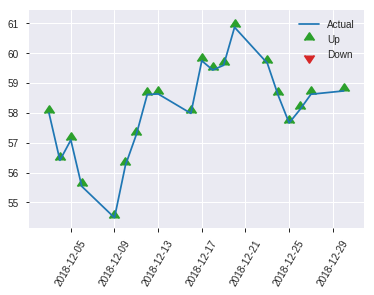


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24561915845325655
RMSE: 0.4955997966638571
LogLoss: 0.6843498458641596
Null degrees of freedom: 235
Residual degrees of freedom: 181
Null deviance: 328.4208830413794
Residual deviance: 323.01312724788335
AIC: 433.01312724788335
AUC: 0.596854126265891
pr_auc: 0.5781382759468002
Gini: 0.19370825253178192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46267950941893393: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      30   87   0.7436   (87.0/117.0)
1      12   107  0.1008   (12.0/119.0)
Total  42   194  0.4195   (99.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46268      0.683706  193
max f2                       0.405187     0.83685   234
max f0point5                 0.46268      0.597765  193
max accuracy                 0.504312     0.588983  91
max precision                0.571393     1         0
max recall                   0.405187     1         234
max specificity              0.571393     1         0
max absolute_mcc             0.46268      0.20336   193
max min_per_class_accuracy   0.493405     0.546218  117
max mean_per_class_accuracy  0.504312     0.589923  91

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.556501           1.98319   1.98319            1                0.564423  1                           0.564423            0.0252101       0.0252101                  98.3193    98.3193
    2        0.0211864                   0.547649           0.991597  1.58655            0.5              0.551643  0.8                         0.559311            0.00840336      0.0336134                  -0.840336  58.6555
    3        0.0338983                   0.540991           0.661064  1.2395             0.333333         0.543507  0.625                       0.553384            0.00840336      0.0420168                  -33.8936   23.9496
    4        0.0423729                   0.53573            0         0.991597           0                0.536745  0.5                         0.550056            0               0.0420168                  -100       -0.840336
    5        0.0508475                   0.533981           1.98319   1.15686            1                0.53493   0.583333                    0.547535            0.0168067       0.0588235                  98.3193    15.6863
    6        0.101695                    0.528661           1.15686   1.15686            0.583333         0.531683  0.583333                    0.539609            0.0588235       0.117647                   15.6863    15.6863
    7        0.152542                    0.522451           1.48739   1.26704            0.75             0.524851  0.638889                    0.53469             0.0756303       0.193277                   48.7395    26.704
    8        0.20339                     0.518161           1.32213   1.28081            0.666667         0.5206    0.645833                    0.531167            0.0672269       0.260504                   32.2129    28.0812
    9        0.300847                    0.510938           1.12094   1.22902            0.565217         0.514942  0.619718                    0.525911            0.109244        0.369748                   12.0935    22.9021
    10       0.402542                    0.502394           1.07423   1.18992            0.541667         0.506558  0.6                         0.521022            0.109244        0.478992                   7.42297    18.9916
    11       0.5                         0.493359           0.689806  1.09244            0.347826         0.496925  0.550847                    0.516325            0.0672269       0.546218                   -31.0194   9.2437
    12       0.601695                    0.483948           1.07423   1.08936            0.541667         0.48817   0.549296                    0.511566            0.109244        0.655462                   7.42297    8.93597
    13       0.699153                    0.475447           1.12094   1.09376            0.565217         0.48078   0.551515                    0.507275            0.109244        0.764706                   12.0935    9.37611
    14       0.800847                    0.465265           0.991597  1.08079            0.5              0.469579  0.544974                    0.502488            0.10084         0.865546                   -0.840336  8.07879
    15       0.898305                    0.446921           0.776032  1.04772            0.391304         0.456968  0.528302                    0.49755             0.0756303       0.941176                   -22.3968   4.77248
    16       1                           0.401128           0.578431  1                  0.291667         0.430343  0.504237                    

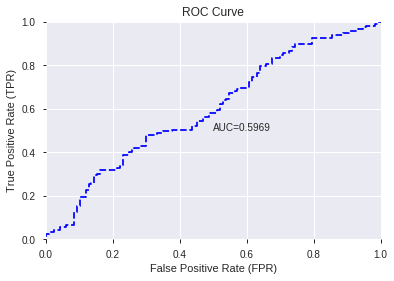

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


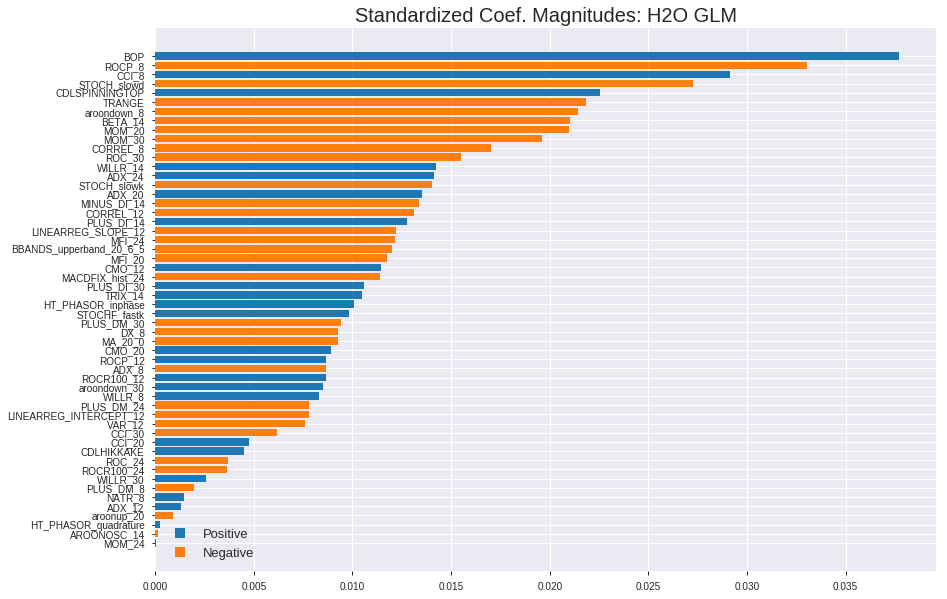

'log_likelihood'
--2019-08-24 01:10:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_011034_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_011034_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'ROCP_8',
 'CCI_8',
 'STOCH_slowd',
 'CDLSPINNINGTOP',
 'TRANGE',
 'aroondown_8',
 'BETA_14',
 'MOM_20',
 'MOM_30',
 'CORREL_8',
 'ROC_30',
 'WILLR_14',
 'ADX_24',
 'STOCH_slowk',
 'ADX_20',
 'MINUS_DI_14',
 'CORREL_12',
 'PLUS_DI_14',
 'LINEARREG_SLOPE_12',
 'MFI_24',
 'BBANDS_upperband_20_6_5',
 'MFI_20',
 'CMO_12',
 'MACDFIX_hist_24',
 'PLUS_DI_30',
 'TRIX_14',
 'HT_PHASOR_inphase',
 'STOCHF_fastk',
 'PLUS_DM_30',
 'DX_8',
 'MA_20_0',
 'CMO_20',
 'ROCP_12',
 'ADX_8',
 'ROCR100_12',
 'aroondown_30',
 'WILLR_8',
 'PLUS_DM_24',
 'LINEARREG_INTERCEPT_12',
 'VAR_12',
 'CCI_30',
 'CCI_20',
 'CDLHIKKAKE',
 'ROC_24',
 'ROCR100_24',
 'WILLR_30',
 'PLUS_DM_8',
 'NATR_8',
 'ADX_12',
 'aroonup_20',
 'HT_PHASOR_quadrature',
 'AROONOSC_14',
 'MOM_24']

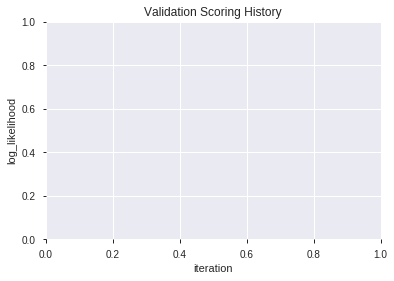

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_011141  0.604539  0.680135              0.417726  0.493469  0.243512
1  XGBoost_grid_1_AutoML_20190824_011141_model_1  0.597501  0.688387              0.456547  0.496822  0.246832
2               XGBoost_1_AutoML_20190824_011141  0.579545  0.685577              0.474287  0.496322  0.246336
3  XGBoost_grid_1_AutoML_20190824_011141_model_4  0.579186  0.685104              0.457265  0.495985  0.246001
4  XGBoost_grid_1_AutoML_20190824_011141_model_2  0.576815  0.684902              0.465668  0.495897  0.245914
5  XGBoost_grid_1_AutoML_20190824_011141_model_6  0.576097  0.688580              0.469655  0.497441  0.247448
6               XGBoost_2_AutoML_20190824_011141  0.566688  0.694492              0.491453  0.500305  0.250305
7  XGBoost_grid_1_AutoML_20190824_011141_model_7  0.561804  0.704923              0.491453  0.505025  0.255050
8  XGBoost_grid_1_AutoML_20190824_011141_model_5  0.556417  0.700516              0.482834  0.503020  0.253029
9  XGBoost_grid_1_AutoML_20190824_011141_model_3  0.546218  0.699086              0.486964  0.502660  0.252667

variable  relative_importance  scaled_importance  percentage
0                       BOP           265.629395           1.000000    0.055530
1                  CORREL_8           254.285370           0.957294    0.053159
2                    TRANGE           216.997498           0.816918    0.045364
3                    MFI_24           199.279190           0.750215    0.041660
4              STOCHF_fastk           177.625916           0.668698    0.037133
5                   ROCP_12           167.634598           0.631085    0.035044
6                    NATR_8           139.822296           0.526381    0.029230
7                     CCI_8           139.693268           0.525895    0.029203
8      HT_PHASOR_quadrature           132.943375           0.500484    0.027792
9                    ADX_20           127.008308           0.478141    0.026551
10                   ROCP_8           124.094604           0.467172    0.025942
11              STOCH_slowd           119.733971           0.450756    0.025031
12        HT_PHASOR_inphase           115.575432           0.435100    0.024161
13                  BETA_14           108.147903           0.407138    0.022609
14                   MFI_20           106.885506           0.402386    0.022345
15                 WILLR_14           105.797173           0.398289    0.022117
16   LINEARREG_INTERCEPT_12           102.766098           0.386878    0.021483
17                CORREL_12           102.589165           0.386212    0.021446
18              STOCH_slowk            95.975479           0.361313    0.020064
19                  MA_20_0            94.558662           0.355980    0.019768
20                   VAR_12            93.200279           0.350866    0.019484
21              AROONOSC_14            92.454529           0.348058    0.019328
22                   MOM_20            87.973846           0.331190    0.018391
23                   ADX_24            86.859550           0.326995    0.018158
24                 WILLR_30            84.365814           0.317607    0.017637
25                   ADX_12            76.441849           0.287776    0.015980
26               PLUS_DI_14            75.015678           0.282407    0.015682
27                   ROC_30            74.772621           0.281492    0.015631
28                  WILLR_8            74.608833           0.280876    0.015597
29               PLUS_DM_24            74.484337           0.280407    0.015571
30               PLUS_DM_30            69.033409           0.259886    0.014432
31              MINUS_DI_14            68.708672           0.258664    0.014364
32              aroondown_8            64.952789           0.244524    0.013579
33               PLUS_DI_30            64.513794           0.242871    0.013487
34                   CMO_20            63.509766           0.239092    0.013277
35                     DX_8            60.417133           0.227449    0.012630
36                    ADX_8            59.729866           0.224862    0.012487
37               ROCR100_12            56.802097           0.213840    0.011875
38                   CCI_30            55.721970           0.209773    0.011649
39                   ROC_24            54.205112           0.204063    0.011332
40                PLUS_DM_8            52.064991           0.196006    0.010884
41                   MOM_24            49.619442           0.186800    0.010373
42       LINEARREG_SLOPE_12            48.588287           0.182918    0.010157
43                   CCI_20            47.587280           0.179149    0.009948
44               aroonup_20            42.410736           0.159661    0.008866
45          MACDFIX_hist_24            38.388699           0.144520    0.008025
46                   CMO_12            35.613731           0.134073    0.007445
47             aroondown_30            33.821716           0.127327    0.007071
48                   MOM_30            32.966415           0.124107    0.006892
49                 

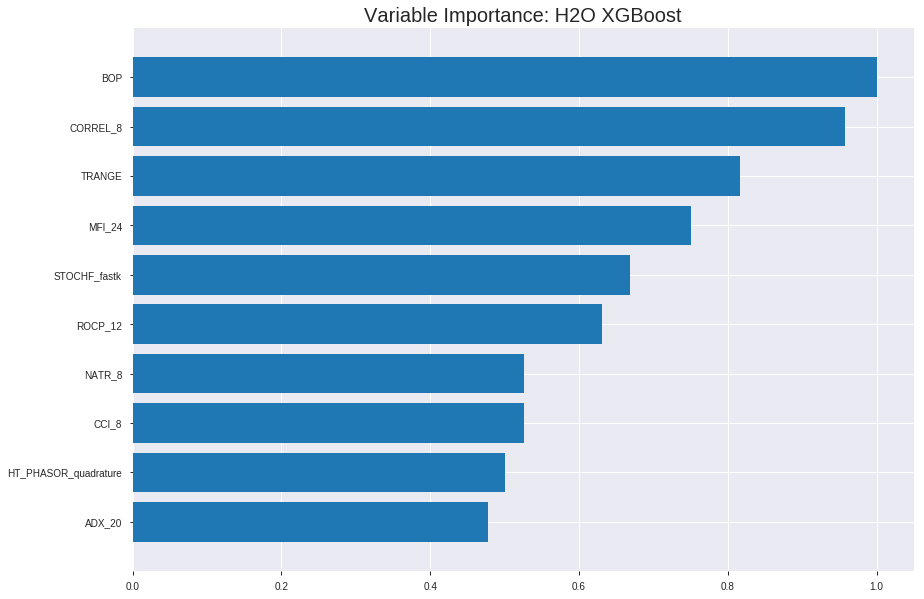

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_011141


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1816139825267771
RMSE: 0.42616192054989743
LogLoss: 0.5519575911000726
Mean Per-Class Error: 0.14764867172703555
AUC: 0.9276186522557446
pr_auc: 0.9370010075064756
Gini: 0.8552373045114892
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5367541670799255: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      653  105  0.1385   (105.0/758.0)
1      140  753  0.1568   (140.0/893.0)
Total  793  858  0.1484   (245.0/1651.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536754     0.86008   195
max f2                       0.473081     0.919079  255
max f0point5                 0.556832     0.881447  176
max accuracy                 0.536754     0.851605  195
max precision                0.813564     1         0
max recall                   0.37087      1         349
max specificity              0.813564     1         0
max absolute_mcc             0.536754     0.702888  195
max min_per_class_accuracy   0.53402      0.845646  198
max mean_per_class_accuracy  0.536754     0.852351  195

Gains/Lift Table: Avg response rate: 54.09 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102968                   0.75139            1.84882   1.84882            1                0.768518  1                           0.768518            0.019037        0.019037                   84.8824   84.8824
    2        0.0205936                   0.737875           1.84882   1.84882            1                0.743286  1                           0.755902            0.019037        0.0380739                  84.8824   84.8824
    3        0.0302847                   0.72545            1.84882   1.84882            1                0.731933  1                           0.748232            0.0179171       0.055991                   84.8824   84.8824
    4        0.0405815                   0.717783           1.84882   1.84882            1                0.721196  1                           0.741372            0.019037        0.075028                   84.8824   84.8824
    5        0.0502726                   0.709104           1.84882   1.84882            1                0.713     1                           0.735903            0.0179171       0.0929451                  84.8824   84.8824
    6        0.100545                    0.678314           1.84882   1.84882            1                0.693089  1                           0.714496            0.0929451       0.18589                    84.8824   84.8824
    7        0.150212                    0.658684           1.84882   1.84882            1                0.668806  1                           0.699389            0.0918253       0.277716                   84.8824   84.8824
    8        0.200485                    0.638394           1.6929    1.80973            0.915663         0.648454  0.978852                    0.686617            0.0851064       0.362822                   69.2899   80.9725
    9        0.300424                    0.608042           1.70316   1.77427            0.921212         0.622961  0.959677                    0.665441            0.170213        0.533035                   70.3159   77.4275
    10       0.400363                    0.571902           1.55749   1.72016            0.842424         0.590595  0.930408                    0.646758            0.155655        0.68869                    55.7494   72.0162
    11       0.500303                    0.542467           1.32219   1.64066            0.715152         0.557131  0.887409                    0.628854            0.132139        0.820829                   32.2189   64.0664
    12       0.600242                    0.510658           0.82917   1.50555            0.448485         0.527043  0.814329                    0.611903            0.0828667       0.903695                   -17.083   50.5551
    13       0.700182                    0.473631           0.69471   1.38982            0.375758         0.491673  0.75173                     0.594742            0.0694289       0.973124                   -30.529   38.9817
    14       0.800121                    0.433206           0.123255  1.23162            0.0666667        0.454546  0.666162                    0.577231            0.012318        0.985442                   -87.6745  23.1616
    15       0.900061                    0.392103           0.11205   1.1073             0.0606061        0.415104  0.598923                    0.559229            0.0111982       0.996641                   -88.795   10.7304
    16       1                           0.176026           0.033615  1                  0.0181818        0.347288  0.540884                    0.538047         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25312636109317654
RMSE: 0.5031166476009084
LogLoss: 0.7003601895915917
Mean Per-Class Error: 0.4526618188347248
AUC: 0.5359278211688662
pr_auc: 0.5311007978412572
Gini: 0.07185564233773234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2153286188840866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    236  0.9958   (236.0/237.0)
1      0    235  0        (0.0/235.0)
Total  1    471  0.5      (236.0/472.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.215329     0.665722  398
max f2                       0.215329     0.832743  398
max f0point5                 0.454736     0.562209  261
max accuracy                 0.454736     0.54661   261
max precision                0.641697     0.684211  17
max recall                   0.215329     1         398
max specificity              0.70382      0.995781  0
max absolute_mcc             0.454736     0.100799  261
max min_per_class_accuracy   0.48648      0.50211   198
max mean_per_class_accuracy  0.454736     0.547338  261

Gains/Lift Table: Avg response rate: 49.79 %, avg score: 48.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105932                   0.666457           1.20511   1.20511            0.6              0.684198  0.6                         0.684198            0.012766        0.012766                   20.5106   20.5106
    2        0.0211864                   0.649267           1.20511   1.20511            0.6              0.655556  0.6                         0.669877            0.012766        0.0255319                  20.5106   20.5106
    3        0.0317797                   0.644491           1.20511   1.20511            0.6              0.646843  0.6                         0.662199            0.012766        0.0382979                  20.5106   20.5106
    4        0.0402542                   0.636008           2.00851   1.37424            1                0.642543  0.684211                    0.658061            0.0170213       0.0553191                  100.851   37.4244
    5        0.0508475                   0.631271           0.401702  1.17163            0.2              0.632365  0.583333                    0.652707            0.00425532      0.0595745                  -59.8298  17.1631
    6        0.101695                    0.602755           1.17163   1.17163            0.583333         0.616557  0.583333                    0.634632            0.0595745       0.119149                   17.1631   17.1631
    7        0.150424                    0.575043           1.22257   1.18813            0.608696         0.589161  0.591549                    0.619902            0.0595745       0.178723                   22.2572   18.8133
    8        0.201271                    0.553692           1.00426   1.14168            0.5              0.564035  0.568421                    0.605788            0.0510638       0.229787                   0.425532  14.168
    9        0.300847                    0.52569            1.02562   1.10327            0.510638         0.539855  0.549296                    0.583965            0.102128        0.331915                   2.56225   10.3266
    10       0.400424                    0.508316           0.726483  1.00957            0.361702         0.517096  0.502646                    0.567336            0.0723404       0.404255                   -27.3517  0.956884
    11       0.5                         0.486294           0.982888  1.00426            0.489362         0.49941   0.5                         0.553809            0.0978723       0.502128                   -1.71118  0.425532
    12       0.599576                    0.467185           1.23929   1.04329            0.617021         0.476589  0.519435                    0.540984            0.123404        0.625532                   23.9294   4.329
    13       0.699153                    0.444134           1.15383   1.05903            0.574468         0.458337  0.527273                    0.529213            0.114894        0.740426                   15.3825   5.90329
    14       0.798729                    0.40636            0.726483  1.01757            0.361702         0.423617  0.506631                    0.516049            0.0723404       0.812766                   -27.3517  1.75744
    15       0.898305                    0.347355           0.982888  1.01373            0.489362         0.377653  0.504717                    0.500708            0.0978723       0.910638                   -1.71118  1.37294
    16       1                           0.175733           0.878723  1                  0.4375           0.29879   0.497881                    0.480174          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 01:11:43  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.459116                         0.5                0.693147              0.5               0                    1                  0.502119
    2019-08-24 01:11:43  0.054 sec   5                  0.488098         0.669571            0.767831        0.787504           1.74007          0.321018                         0.498637           0.690418              0.542329          0.5527               1.33901            0.502119
    2019-08-24 01:11:43  0.091 sec   10                 0.477426         0.648754            0.823209        0.836587           1.84882          0.273168                         0.499194           0.691522              0.527678          0.537728             1.60681            0.5
    2019-08-24 01:11:43  0.130 sec   15                 0.46909          0.632644            0.845947        0.857196           1.84882          0.229558                         0.498773           0.690673              0.537095          0.539171             1.20511            0.497881
    2019-08-24 01:11:43  0.167 sec   20                 0.462713         0.620404            0.861754        0.871055           1.84882          0.219261                         0.500452           0.694095              0.528432          0.523889             1.20511            0.5
    2019-08-24 01:11:43  0.208 sec   25                 0.455405         0.606417            0.876979        0.889345           1.84882          0.206541                         0.500212           0.693674              0.537194          0.537518             1.60681            0.5
    2019-08-24 01:11:43  0.247 sec   30                 0.448908         0.59421             0.893237        0.904538           1.84882          0.19685                          0.501528           0.696452              0.52871           0.529211             1.20511            0.5
    2019-08-24 01:11:43  0.293 sec   35                 0.442845         0.582827            0.902864        0.915668           1.84882          0.182314                         0.501321           0.69611               0.535847          0.535943             1.20511            0.5
    2019-08-24 01:11:44  0.335 sec   40                 0.437894         0.573544            0.910569        0.922568           1.84882          0.169594                         0.502152           0.697944              0.533639          0.531924             1.20511            0.5
    2019-08-24 01:11:44  0.377 sec   45                 0.431162         0.561084            0.919315        0.93014            1.84882          0.15748                          0.502616           0.699116              0.537526          0.532132             1.20511            0.5
    2019-08-24 01:11:44  0.419 sec   50                 0.426162         0.551958            0.927619        0.937001           1.84882          0.148395                         0.503117           0.70036               0.535928          0.531101             1.20511            0.5

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      265.62939453125        1.0                  0.055530423742349955
CORREL_8                 254.28536987304688     0.9572937901762655   0.05315892981440827
TRANGE                   216.99749755859375     0.8169182403232299   0.04536381604800383
MFI_24                   199.27919006347656     0.7502151274151715   0.041659763923285534
STOCHF_fastk             177.62591552734375     0.6686982660213342   0.037133098067939345
---                      ---                    ---                  ---
MOM_30                   32.96641540527344      0.1241068047587448   0.006891703457562193
TRIX_14                  25.189170837402344     0.0948282507734247   0.0052658529481940984
BBANDS_upperband_20_6_5  20.123769760131836     0.07575882102823667  0.004206919433918834
ROCR100_24               13.972986221313477     0.05260331314601413  0.0029210842692496924
CDLSPINNINGTOP           8.330646514892578      0.03136191508320634  0.0017415404339420448


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5932203389830508)

('F1', 0.6797385620915033)

('auc', 0.6045392515980751)

('logloss', 0.6801346780038399)

('mean_per_class_error', 0.40522875816993464)

('rmse', 0.49346931880619804)

('mse', 0.24351196860305313)

xgboost prediction progress: |████████████████████████████████████████████| 100%


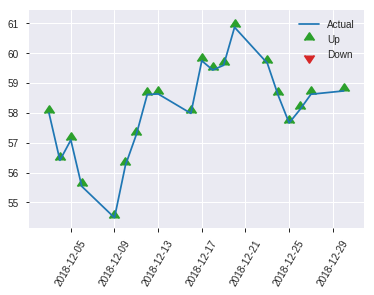


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24351196860305313
RMSE: 0.49346931880619804
LogLoss: 0.6801346780038399
Mean Per-Class Error: 0.40522875816993464
AUC: 0.6045392515980751
pr_auc: 0.587753919512578
Gini: 0.20907850319615018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3831053376197815: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      34   83   0.7094   (83.0/117.0)
1      15   104  0.1261   (15.0/119.0)
Total  49   187  0.4153   (98.0/236.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383105     0.679739  186
max f2                       0.259335     0.83685   234
max f0point5                 0.383105     0.599769  186
max accuracy                 0.514853     0.59322   74
max precision                0.667163     1         0
max recall                   0.259335     1         234
max specificity              0.667163     1         0
max absolute_mcc             0.514853     0.20353   74
max min_per_class_accuracy   0.469425     0.57265   118
max mean_per_class_accuracy  0.514853     0.594771  74

Gains/Lift Table: Avg response rate: 50.42 %, avg score: 46.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0127119                   0.658253           1.98319   1.98319            1                0.663061  1                           0.663061            0.0252101       0.0252101                  98.3193    98.3193
    2        0.0211864                   0.642095           0         1.18992            0                0.648299  0.6                         0.657156            0               0.0252101                  -100       18.9916
    3        0.0338983                   0.624444           1.32213   1.2395             0.666667         0.634159  0.625                       0.648532            0.0168067       0.0420168                  32.2129    23.9496
    4        0.0423729                   0.617666           1.98319   1.38824            1                0.620202  0.7                         0.642866            0.0168067       0.0588235                  98.3193    38.8235
    5        0.0508475                   0.614209           1.98319   1.48739            1                0.616036  0.75                        0.638394            0.0168067       0.0756303                  98.3193    48.7395
    6        0.101695                    0.583314           0.826331  1.15686            0.416667         0.598278  0.583333                    0.618336            0.0420168       0.117647                   -17.3669   15.6863
    7        0.152542                    0.565157           1.32213   1.21195            0.666667         0.573386  0.611111                    0.603353            0.0672269       0.184874                   32.2129    21.1951
    8        0.20339                     0.552725           1.15686   1.19818            0.583333         0.556726  0.604167                    0.591696            0.0588235       0.243697                   15.6863    19.8179
    9        0.300847                    0.522413           1.37961   1.25695            0.695652         0.53394   0.633803                    0.572987            0.134454        0.378151                   37.9613    25.6953
    10       0.402542                    0.500652           0.991597  1.18992            0.5              0.510054  0.6                         0.557088            0.10084         0.478992                   -0.840336  18.9916
    11       0.5                         0.469601           0.948484  1.14286            0.478261         0.481597  0.576271                    0.542373            0.092437        0.571429                   -5.15163   14.2857
    12       0.601695                    0.440747           0.991597  1.11729            0.5              0.454488  0.56338                     0.52752             0.10084         0.672269                   -0.840336  11.7292
    13       0.699153                    0.407633           0.776032  1.06972            0.391304         0.425131  0.539394                    0.513247            0.0756303       0.747899                   -22.3968   6.97224
    14       0.800847                    0.380367           1.2395    1.09128            0.625            0.394191  0.550265                    0.498129            0.12605         0.87395                    23.9496    9.1281
    15       0.898305                    0.346964           0.517355  1.02902            0.26087          0.36307   0.518868                    0.483476            0.0504202       0.92437                    -48.2645   2.90154
    16       1                           0.248206           0.743697  1                  0.375            0.31705   0.504237                    0

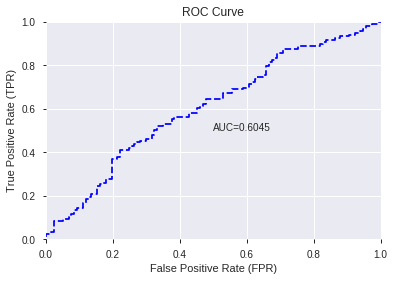

This function is available for GLM models only


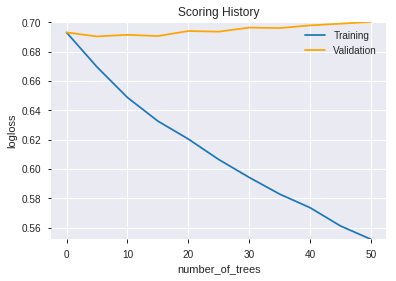

--2019-08-24 01:12:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_011141',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_011141',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b870',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b870',
   'ty

['BOP',
 'CORREL_8',
 'TRANGE',
 'MFI_24',
 'STOCHF_fastk',
 'ROCP_12',
 'NATR_8',
 'CCI_8',
 'HT_PHASOR_quadrature',
 'ADX_20',
 'ROCP_8',
 'STOCH_slowd',
 'HT_PHASOR_inphase',
 'BETA_14',
 'MFI_20',
 'WILLR_14',
 'LINEARREG_INTERCEPT_12',
 'CORREL_12',
 'STOCH_slowk',
 'MA_20_0',
 'VAR_12',
 'AROONOSC_14',
 'MOM_20',
 'ADX_24',
 'WILLR_30',
 'ADX_12',
 'PLUS_DI_14',
 'ROC_30',
 'WILLR_8',
 'PLUS_DM_24',
 'PLUS_DM_30',
 'MINUS_DI_14',
 'aroondown_8',
 'PLUS_DI_30',
 'CMO_20',
 'DX_8',
 'ADX_8',
 'ROCR100_12',
 'CCI_30',
 'ROC_24',
 'PLUS_DM_8',
 'MOM_24',
 'LINEARREG_SLOPE_12',
 'CCI_20',
 'aroonup_20',
 'MACDFIX_hist_24',
 'CMO_12',
 'aroondown_30',
 'MOM_30',
 'TRIX_14',
 'BBANDS_upperband_20_6_5',
 'ROCR100_24',
 'CDLSPINNINGTOP']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.619
GLM             0.589
XGBoost         0.602
dtype: float64

DeepLearning    GLM  XGBoost
All          0.504  0.504    0.602
DLF          0.504  0.504    0.589
Fwe          0.504  0.504    0.602
RFE          0.619  0.589    0.593
XGBF         0.504  0.504    0.589





F1


DeepLearning    0.676
GLM             0.684
XGBoost         0.680
dtype: float64

DeepLearning    GLM  XGBoost
All          0.670  0.670    0.670
DLF          0.670  0.670    0.676
Fwe          0.670  0.670    0.670
RFE          0.676  0.684    0.680
XGBF         0.670  0.670    0.676





auc


DeepLearning    0.612
GLM             0.597
XGBoost         0.605
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.583
DLF          0.500  0.500    0.570
Fwe          0.500  0.500    0.583
RFE          0.612  0.597    0.605
XGBF         0.500  0.500    0.570





logloss


DeepLearning    17.416
GLM             17.416
XGBoost          0.712
dtype: float64

DeepLearning     GLM  XGBoost
All         17.416  17.416    0.712
DLF         17.416  17.416    0.697
Fwe         17.416  17.416    0.712
RFE          1.289   0.684    0.680
XGBF         0.694  17.416    0.697





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.412
dtype: float64

DeepLearning   GLM  XGBoost
All           0.50  0.50    0.399
DLF           0.50  0.50    0.412
Fwe           0.50  0.50    0.399
RFE           0.38  0.41    0.405
XGBF          0.50  0.50    0.412





rmse


DeepLearning    0.710
GLM             0.710
XGBoost         0.508
dtype: float64

DeepLearning    GLM  XGBoost
All          0.710  0.710    0.508
DLF          0.710  0.710    0.502
Fwe          0.710  0.710    0.508
RFE          0.569  0.496    0.493
XGBF         0.500  0.710    0.502





mse


DeepLearning    0.504
GLM             0.504
XGBoost         0.258
dtype: float64

DeepLearning    GLM  XGBoost
All          0.504  0.504    0.258
DLF          0.504  0.504    0.252
Fwe          0.504  0.504    0.258
RFE          0.324  0.246    0.244
XGBF         0.250  0.504    0.252

{'F1':       DeepLearning    GLM  XGBoost
 All          0.670    NaN      NaN
 DLF          0.670    NaN      NaN
 DLF            NaN  0.670      NaN
 DLF            NaN    NaN    0.676
 All            NaN  0.670      NaN
 All            NaN    NaN    0.670
 XGBF         0.670    NaN      NaN
 XGBF           NaN  0.670      NaN
 XGBF           NaN    NaN    0.676
 Fwe          0.670    NaN      NaN
 Fwe            NaN  0.670      NaN
 Fwe            NaN    NaN    0.670
 RFE          0.676    NaN      NaN
 RFE            NaN  0.684      NaN
 RFE            NaN    NaN    0.680,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.504    NaN      NaN
 DLF          0.504    NaN      NaN
 DLF            NaN  0.504      NaN
 DLF            NaN    NaN    0.589
 All            NaN  0.504      NaN
 All            NaN    NaN    0.602
 XGBF         0.504    NaN      NaN
 XGBF           NaN  0.504      NaN
 XGBF           NaN    NaN    0.589
 Fwe          0.504    NaN      NaN
 Fwe     